<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/P1C3S2_why_sex/sequences/P1C3_RealEvolution/P1C3_Sequence2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **1.3.2: Why Sex**
### Objective: In the last sequence we explored the fundamentals of evolution using a simple 'strike-no-strike' (binary classification) problem 'solved' by the selective expression of (highly abstract) chemosensory receptors. Our primary focus was on the parellels between evolutionary processes and optimzation. We hinted at the importance of mutation, population size, and strength of selection in determining whether or not a 'good' solution could even be found by our evolutionary process. In this sequence we are going to go a little deeper in our analysis and look not only at whether or not a 'good' solution can be found at all, but also at how quickly such a solution is found by an evolutionary process, both in terms of number of generations and computational efficiency. We then show how sex (more specifically recombination) can radically accelerate this process. We end by introducing some of the arguments for the why evolution will select for mechanisms, like sex, that accelerate adaptation by natural selection (i.e. why we would expect evolution to be self accelerating!)

In this sequence we explore the following questions through simulations and mathematical analyses:

* How do population size, mutation rate, and strength of selection impact the number of generations required for an evolutionary process to discover an 'optimal' solution?

* How and why does sex (recombination) increase the speed with which an evolutionary process discovers an 'optimal' solution?

* Why does the rate of adaptation matter from an evolutionary persepctive?


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = ['gw_plotting.py', 'gw_board.py', 'gw_game.py',
             'gw_widgets.py', 'gw_NN_RL.py']
#filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P1C3_S1"




################################################################
# Graph Viz Helper Functions
################################################################
# @title Graphvis Helper Functions


def latex_to_png(latex_str, file_path, dpi, fontsize, figsize):
  """Convert a LaTeX string to a PNG image."""
  fig, ax = plt.subplots(figsize=figsize)
  ax.text(0.5, 0.5, f"${latex_str}$", size=fontsize, ha='center', va='center')
  ax.axis("off")
  #plt.tight_layout()
  plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
  plt.savefig(file_path, dpi=dpi, bbox_inches='tight', transparent=True, pad_inches=0.02)
  plt.close()

def add_latex_edge_labels(graph, edge_labels, dpi=150, fontsize=16, figsize=(0.4,0.2)):
  """Add LaTeX-rendered images as edge labels using the dummy node approach."""
  for edge in edge_labels:
    src, dest, latex_str = edge
    if graph.has_edge(src, dest):
      img_path = f"{src}_to_{dest}_{latex_str}.png"
      latex_to_png(latex_str, img_path, dpi=dpi, fontsize=fontsize, figsize=figsize)
      dummy_node_name = f"dummy_{src}_{dest}_{latex_str}"
      graph.add_node(dummy_node_name, shape="box", image=img_path, label="")
      graph.delete_edge(src, dest)
      graph.add_edge(src, dummy_node_name, dir="none", weight=10)
      graph.add_edge(dummy_node_name, dest, dir="forward", weight=10)
  return graph

def set_regular_node_sizes(graph, width=1.0, height=1.0):
  """Set the size of regular nodes (excluding dummy label nodes)."""
  for node in graph.nodes():
    if not node.startswith("dummy"):
      node.attr['width'] = width
      node.attr['height'] = height
  return graph

def create_and_render_graph(nodes_list, edges_list, latex_edge_labels, output_path="graphviz_output.png", dpi=300,
                            figsize=(0.6, 0.3), fontsize=16):
  """
  Create a graph with given nodes, edges, and LaTeX edge labels, then render and save it.

  Parameters:
    nodes_list (list): List of nodes in the graph.
    edges_list (list): List of edges in the graph.
    latex_edge_labels (list): List of tuples containing edge and its LaTeX label.
    output_path (str): Path to save the rendered graph.
    dpi (int): DPI for rendering the graph.
    figsize (tuple): Figure size for the LaTeX labels.

  Returns:
    str: Path to the saved graph image.
  """

  # Graph Creation and Configuration
  G = pgv.AGraph(directed=True, strict=False, rankdir='LR', ranksep=0.5, nodesep=0.5)
  G.add_nodes_from(nodes_list)
  for edge in edges_list:
    G.add_edge(edge[0], edge[1])

  # Set size for regular nodes and add LaTeX-rendered image labels to the edges
  G = set_regular_node_sizes(G, width=1, height=1)
  G = add_latex_edge_labels(G, latex_edge_labels, dpi=dpi, figsize=figsize, fontsize=fontsize)

  # Additional graph attributes
  G.graph_attr['size'] = "8,8"
  G.graph_attr['dpi'] = str(dpi)

  # Render and save the graph
  G.layout(prog='dot')
  G.draw(output_path)

  return output_path




#######################################################################
# make PatchyForageBoard class locally before integrating in shared utils
#######################################################################
# @title PatchyForageBoard class




class PatchyForageBoard():
  """
  A collection of methods and parameters of a patchy foraging game board that
  define the logic of the game, and allows for multiple critters on the same
  board

  game state is represented by primarily by food locations, forager locations,
  predator locations, scores, and rounds left
  food patch locations are stored on a batch x n_rows x n_cols numpy array,
  forager and predator(when we have them) locations are stored as dictionaries
  with integer keys corresponding to a forager/predatore 1, 2, 3 etc, and then
  np.argwhere style tuples of arrays of (batch_array, row_array, col_array)
  giving the locations

  scores is a batchsize x num_critters numpy array giving the scores for each
  critter on each board in the batch (note off by one indexing)

  rounds_left is how many rounds are left in the game.

  Note:
    In 2d np.array first dim is row (vertical), second dim is col (horizontal),
    i.e. top left corner is (0,0), so take care when visualizing/plotting
    as np.array visualization inline with typical tensor notation but at odds
    with conventional plotting where (0,0) is bottom left, first dim, x, is
    horizontal, second dim, y, is vertical
  """

  ARRAY_PAD_VALUE = -200

  def __init__(self, batch_size=1,
               n_rows=10, n_cols=5,
               num_foragers=1,
               death_rate=0.04,
               food_patch_prob = 0.5,
               food_regen_prob=0.0,
               forage_success_prob = 0.9,
               food_extinct_prob = 0.2, rng=None):
    """Set the parameters of the game."""
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.batch_size = batch_size
    self.num_foragers = num_foragers
    self.death_rate = death_rate
    self.food_patch_prob = food_patch_prob
    self.forage_success_prob = forage_success_prob
    self.food_extinct_prob = food_extinct_prob
    self.food_regen_prob = food_regen_prob
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng


  def init_loc(self, n_rows, n_cols, num, rng=None):
    """
    Samples random 2d grid locations without replacement

    Args:
      n_rows: int, number of rows in the grid
      n_cols: int, number of columns in the grid
      num:    int, number of samples to generate. Should throw an error if num > n_rows x n_cols
      rng:    instance of numpy.random's default rng. Used for reproducibility.

    Returns:
      int_loc: ndarray(int) of shape (num,), flat indices for a 2D grid flattened into 1D
      rc_index: tuple(ndarray(int), ndarray(int)), a pair of arrays with the first giving
        the row indices and the second giving the col indices. Useful for indexing into
        an n_rows by n_cols numpy array.
      rc_plotting: ndarray(int) of shape (num, 2), 2D coordinates suitable for matplotlib plotting
    """

    # Set up default random generator, use the boards default if none explicitly given
    if rng is None:
      rng = self.rng
    # Choose 'num' unique random indices from a flat 1D array of size n_rows*n_cols
    int_loc = rng.choice(n_rows * n_cols, num, replace=False)
    # Convert the flat indices to 2D indices based on the original shape (n_rows, n_cols)
    rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
    # Transpose indices to get num x 2 array for easy plotting with matplotlib
    rc_plotting = np.array(rc_index).T
    # Return 1D flat indices, 2D indices for numpy array indexing and 2D indices for plotting
    return int_loc, rc_index, rc_plotting


  def get_init_board_state(self):
    """
    Set up starting board using game parameters

    Returns:
      state (dict):
      The state dictionary contains:
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': Dictionary of current locations of the foragers on the board.
        - 'misses_new_patch': List of counts for missed attempts at new patches for each critter.
        - 'misses_known_patch': List of counts for missed attempts at known patches for each critter.
        - 'at_new_patch': List of booleans indicating if each critter is at a new
    """
    # note that is_over applies at the batch level not the batch x forager level
    self.is_over = np.zeros(self.batch_size, dtype=bool)
    self.rounds_alive = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    self.scores = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    # create an empty board array for food locs
    self.pieces = np.zeros((self.batch_size, self.n_rows, self.n_cols),
                           dtype=int)
    # Place critters in top left corner of the board
    self.forager_locs = {}
    for c in (np.arange(self.num_foragers)+1):
      self.forager_locs[c] = (np.arange(self.batch_size, dtype=int),
                              np.zeros(self.batch_size, dtype=int),
                              np.zeros(self.batch_size, dtype=int))
    # Initial food patches on the board randomly
    # each grid has an independent prob of being a pathc (to make the math
    # easier later) so total number of patches on a board is binomially
    # distributed
    num_foods = self.rng.binomial(n=self.n_rows * self.n_cols,
                                  p=self.food_patch_prob,
                                  size=self.batch_size)
    for ii in np.arange(self.batch_size):
      int_loc, rc_idx, rc_plot = self.init_loc(self.n_rows, self.n_cols,
                                               num_foods[ii])
      # food patch start locations (do each patch separate in case we
      # want to have different kinds of patches)
      for f_ in np.arange(num_foods[ii]):
        self.pieces[(ii, rc_idx[0][f_],
                         rc_idx[1][f_])] = - 1
    # keep track of which foragers have missed how many times
    # at what kind of patch
    self.misses_new_patch = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    self.misses_known_patch = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    self.at_new_patch = np.ones((self.batch_size, self.num_foragers), dtype=bool)
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_alive': self.rounds_alive.copy(),
             'is_over': self.is_over.copy(),
             'forager_locs': copy.deepcopy(self.forager_locs),
             'misses_new_patch': self.misses_new_patch.copy(),
             'misses_known_patch': self.misses_known_patch.copy(),
             'at_new_patch': self.at_new_patch.copy()}
    return state


  def set_state(self, board):
    """
    Sets the state given a board dictionary.

    Args:
      board (dict):
      The board dictionary contains:
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': Dictionary of current locations of the foragers on the board.
        - 'misses_new_patch': List of counts for missed attempts at new patches for each critter.
        - 'misses_known_patch': List of counts for missed attempts at known patches for each critter.
        - 'at_new_patch': List of booleans indicating if each critter is at a new patch.
    """
    self.pieces = board['pieces'].copy()
    self.forager_locs = copy.deepcopy(board['forager_locs'])
    self.rounds_alive = board['rounds_alive'].copy()
    self.scores = board['scores'].copy()
    self.is_over = board['is_over'].copy()
    self.misses_new_patch = board['misses_new_patch'].copy()
    self.misses_known_patch = board['misses_known_patch'].copy()
    self.at_new_patch = board['at_new_patch'].copy()


  def get_state(self):
    """
    Returns the current board state.

    Returns:
      state (dict):
      The state dictionary contains:
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': Dictionary of current locations of the foragers on the board.
        - 'misses_new_patch': List of counts for missed attempts at new patches for each critter.
        - 'misses_known_patch': List of counts for missed attempts at known patches for each critter.
        - 'at_new_patch': List of booleans indicating if each critter is at a new patch.
    """
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_alive': self.rounds_alive.copy(),
             'is_over': self.is_over.copy(),
             'forager_locs': copy.deepcopy(self.forager_locs),
             'misses_new_patch': self.misses_new_patch.copy(),
             'misses_known_patch': self.misses_known_patch.copy(),
             'at_new_patch': self.at_new_patch.copy()}
    return state


  ################# CORE GAME STATE UPDATE LOGIC ##############################
  ################# execute_moves is main, uses these helper functions ########


  def execute_moves(self, moves, which_critter):
    """
    Execute the moves on the board. A move to the current location implies
    foraging. If foraging, check if foraging is successful, update scores,
    and check if the food goes extinct. If moving to a new location, simply
    update the critter's location.

    Args:
      moves (tuple): A tuple of three arrays:
        - batch_array: Specifies which board in the batch the move corresponds to.
        - row_array: Specifies the target row for each move.
        - col_array: Specifies the target column for each move.
        Each array in the tuple has the same length. A move is represented by
        the combination of a batch index, row index, and column index at the
        same position in their respective arrays.
      which_critter (int): Index to identify the critter. Starts from 1.

    Returns: Nothing, just updates state related attributes of the board object

    """
    #expand moves tuple
    batch_moves, row_moves, col_moves = moves

    # Get current locations of the critter
    current_locs = self.forager_locs[which_critter]

    # Iterate over each board in the batch
    for ii in np.arange(self.batch_size):
      # If the game is over for this board, skip
      if self.is_over[ii]:
        continue

      # increment rounds alive if not over
      self.rounds_alive[ii, which_critter - 1] += 1

      # Get new location directly from the moves
      new_row = int(row_moves[ii])
      new_col = int(col_moves[ii])

      # Check if the critter has moved to a new patch
      if (new_row, new_col) != (current_locs[1][ii], current_locs[2][ii]):
        # Moved to a new patch
        self.misses_new_patch[ii, which_critter - 1] = 0
        self.misses_known_patch[ii, which_critter - 1] = 0
        self.at_new_patch[ii, which_critter - 1] = True

      # If the critter's position has not changed, it's trying to forage
      elif (new_row, new_col) == (current_locs[1][ii], current_locs[2][ii]):
        # Check if there's food at the location
        if self.pieces[ii, new_row, new_col] < 0:
          # Check if foraging is successful
          if self.rng.random() < self.forage_success_prob:
            # Successful foraging, increase critter's score
            self.scores[ii, which_critter - 1] += 1
            # misses are zeroed and no longer at new patch
            self.misses_new_patch[ii, which_critter - 1] = 0
            self.misses_known_patch[ii, which_critter - 1] = 0
            self.at_new_patch[ii, which_critter - 1] = False
            # Check if food goes extinct (only on success)
            if self.rng.random() < self.food_extinct_prob:
              self.pieces[ii, new_row, new_col] = 0  # Set it to empty
          else:
            #unsuccessful foraging at patch with food
            if self.at_new_patch[ii, which_critter - 1]:
              # at a new patch
              self.misses_new_patch[ii, which_critter - 1] += 1
            else:
              # at a known patch
              self.misses_known_patch[ii, which_critter - 1] += 1
        else:
          #unsuccessful foraging at patch without food
            if self.at_new_patch[ii, which_critter - 1]:
              # at a new patch
              self.misses_new_patch[ii, which_critter - 1] += 1
            else:
              # at a known patch
              self.misses_known_patch[ii, which_critter - 1] += 1

      # Always check if session is over
      if self.rng.random() < self.death_rate:
        self.is_over[ii] = True

    # assume moves are legal and update locs for whole batch at once
    self.forager_locs[which_critter] = (batch_moves, row_moves, col_moves)

  ###### Getting Legal Moves and Perceptions #########################
  ####################################################################
  def get_neighbor_grc_indices(self, which_critter, radius, pad=False):
    """
    Returns all grid positions within a certain cityblock distance radius from
    the place corresponding to which_critter.

    Args:
        which_critter (int): The idex of the focal critter_food.
        radius (int): The cityblock distance.
        pad (bool): whether or not to pad the array, if padded all row, col
          indexes are valid for the padded array, useful for getting percept
          if not all indexes are correct for the original array, useful for
          figuring out legal moves.

    Returns:
        an array of indices, each row is a g, r, c index for the neighborhoods
        around the critters, can use the g value to know which board you are in.
        if pad=True also returns the padded array (the indices in that case) are
        for the padded array, so won't work on self.pieces, whereas if pad is
        False the indices will be for the offsets in reference to the original
        self.pieces, but note that some of these will be invalid, and will
        need to be filtered out (as we do in get_legal)
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    batch, rows, cols = self.forager_locs[which_critter]
    # Create meshgrid for offsets
    if pad is True:
      padded_arr = np.pad(self.pieces, ((0, 0), (radius, radius),
        (radius, radius)), constant_values=self.ARRAY_PAD_VALUE)
      rows = rows + radius
      cols = cols + radius

    row_offsets, col_offsets = np.meshgrid(
        np.arange(-radius, radius + 1),
        np.arange(-radius, radius + 1),
        indexing='ij')

    # Filter for valid cityblock distances
    mask = np.abs(row_offsets) + np.abs(col_offsets) <= radius
    valid_row_offsets = row_offsets[mask]
    valid_col_offsets = col_offsets[mask]
    # Extend rows and cols dimensions for broadcasting
    extended_rows = rows[:, np.newaxis]
    extended_cols = cols[:, np.newaxis]
    # Compute all neighbors for each position in the batch
    neighbors_rows = extended_rows + valid_row_offsets
    neighbors_cols = extended_cols + valid_col_offsets

    indices = np.column_stack((np.repeat(np.arange(batch_size),
                                         neighbors_rows.shape[1]),
                               neighbors_rows.ravel(),
                               neighbors_cols.ravel()))
    if pad is False:
      return indices
    elif pad is True:
      return indices, padded_arr


  def get_legal_moves(self, which_critter, radius=1):
    """
    Identifies all legal moves for the critter.

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offset on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """

    critter_locs = np.array(self.forager_locs[which_critter])
    # turn those row, col offsets into a set of legal offsets
    legal_offsets = self.get_neighbor_grc_indices(which_critter, radius)
    legal_offsets = {tuple(m_) for m_ in legal_offsets}

    legal_destinations = np.where(np.ones(self.pieces.shape, dtype=bool))
    legal_destinations = {tuple(coords) for coords in zip(*legal_destinations)}
    # Add the current locations of the critters to legal_destinations
    current_locations = {tuple(loc) for loc in critter_locs.T}
    legal_destinations = legal_destinations.union(current_locations)

    # legal moves are both legal offsets and legal destinations
    legal_moves = legal_offsets.intersection(legal_destinations)
    return legal_moves


  def get_perceptions(self, critter_food, radius):
    idx, pad_pieces = self.get_neighbor_grc_indices(critter_food,
                                                    radius, pad=True)
    #percept_mask = np.zeros(pad_pieces.shape, dtype=bool)
    #percept_mask[idx[:,0], idx[:,1]], idx[:,2]] = True
    percept = pad_pieces[idx[:,0], idx[:,1], idx[:,2]]
    return(percept.reshape(self.batch_size, -1))




#######################################################################
# make PatchyForageGame class locally before integrating in shared utils
#######################################################################
# @title PatchyForageGame class




class PatchyForagingGame():
  """
  A collection of methods and parameters of a patchy foraging game that allow
  for interaction with and display of PatchyForageBoard objects.
  """


  def __init__(self, batch_size=1, n_rows=10, n_cols=5, num_foragers=1,
               death_rate=0.04, food_patch_prob=0.5, food_regen_prob=0.0,
               forage_success_prob=0.9, food_extinct_prob=0.2, rng=None):
    """
    Initializes an instance of the PatchyForagingGame with the specified parameters.
    Args:
    ... [same as in PatchyForageBoard]
    """
    self.batch_size = batch_size
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.num_foragers = num_foragers
    self.death_rate = death_rate
    self.food_patch_prob = food_patch_prob
    self.forage_success_prob = forage_success_prob
    self.food_extinct_prob = food_extinct_prob
    self.food_regen_prob = food_regen_prob
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng

  def get_init_board(self):
    """
    Generates a starting board given the parameters of the game.
    Returns the initial state of the game.
    """
    board = PatchyForageBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                              n_cols=self.n_cols, num_foragers=self.num_foragers,
                              death_rate=self.death_rate, food_patch_prob=self.food_patch_prob,
                              forage_success_prob=self.forage_success_prob,
                              food_extinct_prob=self.food_extinct_prob,
                              food_regen_prob=self.food_regen_prob, rng=self.rng)
    return board.get_init_board_state()


  def get_board_shape(self):
    """Shape of a single board, doesn't give batch size"""
    return (self.n_rows, self.n_cols)

  def get_action_size(self):
    """
    Returns the number of all possible actions, even though only a subset
    of these will ever be valid on a given turn.
    Actions correspond to integer indexes of board locations,
    moves to (batch,) row and column coordinate indexes of board locations.
    """
    return self.n_rows * self.n_cols

  def get_batch_size(self):
    return self.batch_size

  def get_scores(self, board):
    return board['scores'].copy()

  def get_rounds_alive(self, board):
    return board['rounds_alive'].copy()

  def get_square_symbol(self, piece, has_forager):
    """Returns the symbol representation of a board square."""
    if has_forager and piece < 0: return 'C'  # Critter on food patch
    if has_forager: return 'P'  # Forager on an empty square
    if piece == 0: return '.'  # Empty square
    if piece < 0: return 'F'  # Food patch
    return '?'  # Unknown piece type, for debugging

  def display(self, board, g=0):
    """Displays the g-th game in the batch of boards."""
    print("   ", end="")
    for c_ in range(self.n_cols):
      print(c_, end=" ")
    print("")
    print("-----------------------")
    for r_ in range(self.n_rows):
      print(r_, "|", end="")  # Print the row number
      for c_ in range(self.n_cols):
        piece = board['pieces'][g, r_, c_]  # Get the piece to print
        # Check if the square is occupied by a forager
        has_forager = False
        for forager_num, locs in board['forager_locs'].items():
          if g in locs[0] and r_ in locs[1] and c_ in locs[2]:
            has_forager = True
            break

        print(self.get_square_symbol(piece, has_forager), end=" ")
      print("|")
    print("-----------------------")
    print("Rounds Alive: " + str(board['rounds_alive'][g]))
    print("Score: " + str(board['scores'][g]))

  def get_critter_rc(self, board, g, which_critter):
    critter_locs = board['forager_locs'][which_critter]
    return critter_locs[1][g], critter_locs[2][g]

  def plot_board(self, board, g=0,
                 fig=None, ax=None, critter_specs=None, food=None, fov=None,
                 legend_type='included',
                 has_fov=False, #fog_of_war field_of_view
                 fov_opaque=False, #let human see through fog of war or not
                 show_food=True,
                 radius=2, figsize=(6,5), title=None,
                 name='Critter',
                 focal_critter_index = 0):
    """Uses plotting functions to make picture of the current board state"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    # get food locs and plot them
    rc_food_index = np.array(np.where(board['pieces'][g] <= -1))
    rc_food_plotting = np.array(rc_food_index).T
    if food is None:
      food = plot_food(fig, ax, rc_food_plotting, size=550, show_food=show_food)
    else:
      food = plot_food(fig, ax, rc_food_plotting, food, show_food=show_food)

    # generate critter plotting specs if we don't already have them
    if critter_specs is None:
      critter_specs = []
      markers = ['h', 'd']  # hexagon and diamond
      colors = sns.color_palette("colorblind")
      for i in range(self.num_foragers):
        critter_name = name if self.num_foragers == 1 else f'{name} {i+1}'
        spec = {'marker': markers[i % len(markers)],
                'color': colors[i // len(markers) % len(colors)],
                'name': critter_name,
                'int_id': i+1}
        critter_specs.append(spec)
    # get critter locs and plot them
    assert len(critter_specs) == self.num_foragers, "More/fewer specs than critters"
    for spec in critter_specs:
      rc_loc = np.array(self.get_critter_rc(board, g, spec['int_id'])).T
      spec.update({'rc_loc': rc_loc})
    critter_specs = plot_critters(fig, ax, critter_specs)

    #plot field of view if doing that
    if has_fov:
      # plot field of view around the 'active player'
      if fov is None:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque)
      else:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque, fov=fov)
    # make legend and draw and return figure
    if legend_type == 'included':
      fig.legend(loc = "outside right upper", markerscale=0.8)
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov
    elif legend_type == 'separate':
      fig_legend, ax_legend = plt.subplots(figsize=(1.5,1.5), layout='constrained')
      fig_legend.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)
      handles, labels = ax.get_legend_handles_labels()
      ax_legend.legend(handles, labels, loc='center', markerscale=0.8)
      ax_legend.axis('off')
      fig_legend.canvas.header_visible = False
      fig_legend.canvas.toolbar_visible = False
      fig_legend.canvas.resizable = False
      fig_legend.canvas.footer_visible = False
      fig_legend.canvas.draw()
      return fig, ax, critter_specs, food, fov, fig_legend, ax_legend
    else: #no legend
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov


  def get_legal_moves(self, board, which_critter=1, radius=1):
    """
    A Helper function to get the legal moves, as a set of batch, row, col triples
    for the given board. Does return moves that are technically legal
    but that will result in a blocking move

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.

      which_critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      moves: set or tuples (g, r, c)
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = PatchyForageBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                          n_cols=self.n_cols, num_foragers=self.num_foragers,
                          death_rate=self.death_rate,
                          food_patch_prob=self.food_patch_prob,
                          forage_success_prob=self.forage_success_prob,
                          food_extinct_prob=self.food_extinct_prob,
                          food_regen_prob=self.food_regen_prob, rng=self.rng)
    b.set_state(board)
    legal_moves =  b.get_legal_moves(which_critter, radius)
    return legal_moves

  def get_valid_actions(self, board, which_critter=1, radius=1):
    """
    A Helper function to translate the g,x,y, tuples provided the
    get_legal_moves method into valid actions, represented
    as binary vectors of len num_actions.

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      valids: np.ndarray(binary) batch_size x num_actions, 1's represent
              valid moves
    """
    legal_moves =  self.get_legal_moves(board, which_critter, radius)
    g, r, c = zip(*legal_moves)
    valids = np.zeros((self.batch_size, self.n_rows * self.n_cols))
    valids[g, np.array(r) * self.n_cols + np.array(c)] = 1
    return valids


  def get_next_state(self, board, which_critter, actions):
    """
    Helper function using GridworldBoard.execute_moves to update board state
    given actions on a batch of boards, for a given critter

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter: integer index of the critter type
      actions: list of flat integer indexes of critter's new board positions

    Returns:
      a board triple signifying next state

    Note:
      if len(actions) > batch_size of board the returned board state will have
      an expanded batch size, allowing multiple paths in the game tree to be
      explored in parallel

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    assert batch_size == len(actions)
    b = PatchyForageBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                          n_cols=self.n_cols, num_foragers=self.num_foragers,
                          death_rate=self.death_rate,
                          food_patch_prob=self.food_patch_prob,
                          forage_success_prob=self.forage_success_prob,
                          food_extinct_prob=self.food_extinct_prob,
                          food_regen_prob=self.food_regen_prob, rng=self.rng)
    b.set_state(board)
    moves = self.actions_to_moves(actions)
    b.execute_moves(moves, which_critter)
    return b.get_state()

  def actions_to_moves(self, actions):
    """
    Args:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    Returns
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    """
    moves = (np.arange(len(actions)),
             np.floor_divide(actions, self.n_cols),
             np.remainder(actions, self.n_cols))
    return moves

  def moves_to_actions(self, moves):
    """
    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    Returns:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    """
    _, rows, cols = moves
    actions = rows * self.n_cols + cols
    return actions

  def critter_oriented_get_next_state(self, board, which_critter, offsets):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then get's the next state.

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter: integer index of the critter type
      offsets: batch length list of strings one 'up', 'down', 'left', 'right' 'still'

    Returns:
      a board triple signifying next state

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = PatchyForageBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                          n_cols=self.n_cols, num_foragers=self.num_foragers,
                          death_rate=self.death_rate,
                          food_patch_prob=self.food_patch_prob,
                          forage_success_prob=self.forage_success_prob,
                          food_extinct_prob=self.food_extinct_prob,
                          food_regen_prob=self.food_regen_prob, rng=self.rng)
    b.set_state(board)
    moves = self.critter_direction_to_move(board, offsets, which_critter)
    b.execute_moves(moves, which_critter)
    return(b.get_state())

  def critter_direction_to_move(self, board, offsets, critter):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then returns moves. Doesn't check for collisions with
    other critters though. In general player's move methods should be checking
    valid moves and only making legal ones.

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter: integer index of the critter type
      offsets: batch length list of strings,
        one of 'up', 'down', 'left', 'right', 'still'

    Returns:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for numpy.
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {'up': (0, -1, 0),
                   'down': (0, 1, 0),
                   'left': (0, 0, -1),
                   'right': (0, 0, 1),
                   'still': (0, 0, 0)}
    this_critter_locs = board['forager_locs'][critter]
    all_critter_locs = np.where(board['pieces'] >= 1)
    offsets_array = np.hstack([np.array(offset_dict[ost_]).reshape((3,1))
                           for ost_ in offsets])
    new_locs = np.array(this_critter_locs) + offsets_array
    #check bounces at boundaries
    new_locs[1,:] = np.where(new_locs[1] >=
                               n_rows, n_rows-2, new_locs[1])
    new_locs[2,:] = np.where(new_locs[2,:] >=
                               n_cols, n_cols-2, new_locs[2,:])
    new_locs[1,:] = np.where(new_locs[1,:] < 0, 1, new_locs[1,:])
    new_locs[2,:] = np.where(new_locs[2,:] < 0, 1, new_locs[2,:])
    moves = tuple(new_locs)
    return moves

  def critter_directions_to_actions(self, board, directions, critter):
    """
    Converts a list of direction strings to a list of action indices for the given board state and critter.

    Args:
      board (dict): The current state of the game.
      directions (list of str): List of directions, where each direction is one of 'up', 'down', 'left', 'right', 'still'.
      critter (int): The critter index.

    Returns:
      list of int: List of action indices corresponding to the directions.
    """
    # Ensure the length of directions matches the batch size
    assert len(directions) == board['pieces'].shape[0], "Mismatch between directions length and batch size"

    # Convert directions to moves
    moves = self.critter_direction_to_move(board, directions, critter)

    # Convert moves to actions
    actions = self.moves_to_actions(moves)

    return actions


  def get_valid_directions(self, board, which_critter):
    """
    Transforms output of get_valid_actions to a list of the valid directions
    for each board in the batch for a given critter.
    """
    offset_dict = {( 0, 1): 'right',
                   ( 0,-1): 'left',
                   ( 1, 0): 'down',
                   (-1, 0): 'up',
                   ( 0, 0): 'still'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    valid_actions = self.get_valid_actions(board, which_critter)
    if batch_size != len(valid_actions):
      raise ValueError("Need Exactly one set of valid actions per board in batch")
    critter_locs = board['forager_locs'][which_critter]
    valid_directions = []
    for g, batch_valid in enumerate(valid_actions):
      valid_int_indices = np.where(batch_valid==1)[0]
      critter_loc = np.array([[critter_locs[1][g],critter_locs[2][g]]])
      # critter_loc shape is (1, 2)
      moves = np.column_stack([valid_int_indices // n_cols, valid_int_indices % n_cols])
      offsets = moves - critter_loc
      batch_valid_directions = [offset_dict[tuple(offset)] for offset in offsets]
      valid_directions.append(batch_valid_directions)
    return valid_directions


  def get_perceptions(self, board, radius, which_critter):
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = PatchyForageBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                          n_cols=self.n_cols, num_foragers=self.num_foragers,
                          death_rate=self.death_rate,
                          food_patch_prob=self.food_patch_prob,
                          forage_success_prob=self.forage_success_prob,
                          food_extinct_prob=self.food_extinct_prob,
                          food_regen_prob=self.food_regen_prob, rng=self.rng)
    b.set_state(board)
    return(b.get_perceptions(radius, which_critter))


  def play_game(self, players=[], visualize = False):
    """This method takes a list of players the same length as num_foragers,
        and then plays a batch of games with them and returns the final board
        states of each game"""
    if len(players) != self.num_foragers:
      raise ValueError("number of players different than expected")

    board = self.get_init_board()
    if visualize == True:
      self.display(board, 0)

    for p_idx, player_ in enumerate(players):
      if player_.critter_index != p_idx+1:
        print(player_.critter_index)
        print(p_idx + 1)
        raise ValueError("player order does not match assigned critter index")

    while np.any(board['is_over'] == False):
      for player_ in players:
        old_scores = board['scores']
        if player_.return_direction:
          directions = player_.play(board)
          a_player = self.critter_directions_to_actions(board, directions, player_.critter_index)
        else: # player returns actions directly
          a_player, _, _ = player_.play(board)
        board = self.get_next_state(board, player_.critter_index, a_player)
        if visualize == True:
          self.display(board, 0)
    return board


  def plot_visualizations(board):
    # Extracting scores and rounds_alive for all batches
    scores = board['scores']
    rounds_alive = board['rounds_alive']

    # Calculating average scores per round for each batch
    avg_scores_per_round = scores / rounds_alive

    # Histogram of Average Score Per Round
    plt.figure()
    plt.hist(avg_scores_per_round, bins=30, edgecolor='black')
    plt.xlabel('Average Score Per Round')
    plt.ylabel('Frequency')
    plt.title('Histogram of Average Score Per Round')
    plt.show()

    # Scatter Plot of Averages vs. Rounds Alive
    plt.figure()
    plt.scatter(rounds_alive, avg_scores_per_round, c='blue', alpha=0.5)
    plt.xlabel('Rounds Alive')
    plt.ylabel('Average Score Per Round')
    plt.title('Scatter Plot of Average Scores vs. Rounds Alive')
    plt.grid(True)
    plt.show()





#######################################################################
# make InteractivePatchyForage class locally before integrating in shared utils
#######################################################################
# @title Interactive Patchy Foraging




class InteractivePatchyForage():
  """
  A widget based object for interacting with a gridworld game
  """

  def __init__(self, PatchyForage_game, init_board=None, has_fov=False,
               radius=2, fov_opaque=False, show_food=True, show_misses=False,
               figsize=(6,5), critter_names=['Critter'], players=['human']):
    """
    Initializes a widget based object for interacting with a patchy foraging game

    Args:
      gridworld_game: an instance of PatchyForageGame object
        expects this to have batchsize 1
      init_board: (optional) a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'rounds_alive': The number of rounds each critter has been alive.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
      critter_names: a list of strings that determines what the critter is called
        in the plot legend, order should align with players
      player: a list of either 'human', None, or a player object with a play
        method and a critter_index attribute. If 'human' use buttons,  if None
        default to making a RandomValidPlayer object, otherwise use the
        player class provided to make the player objects and use a start button.
        The list needs to be as long as the PatchyForage_game.num_foragers
        attribute. Order should align with critter_name.

      Note: fov only turns on for the 'active' player.
    """

    # Set GridworldGame object and initialize the board state
    self.pfg = PatchyForage_game
    self.has_fov = has_fov
    self.radius = radius
    self.fov_opaque = fov_opaque
    self.show_food = show_food
    self.percept_len = 2*self.radius*(self.radius+1)
    self.figsize = figsize
    # initialize players and plotting specs together to ensure alignment
    self.players = []
    self.any_human_players = False
    self.active_player_index = 0
    self.crit_specs = []
    markers = ['h', 'd']  # hexagon and diamond
    colors = sns.color_palette("colorblind")
    for i in range(self.pfg.num_foragers):
      spec = {'marker': markers[i % len(markers)],
              'color': colors[i // len(markers) % len(colors)],
              'name': critter_names[i],
              'int_id': i+1}
      self.crit_specs.append(spec)
      player = players[i] #implicit check that players is at least long enough
      if player is None:
        self.players.append(RandomValidPlayer(self.gwg, critter_index=i+1))
      elif player == 'human':
        self.players.append('human')
        # right now only ever have on human player with index 1
        self.any_human_players = True
      else:
        # player objects expected to have a critter_index attribute
        # we set it appropriately here so it aligns with the players list
        # used to create the widget
        player.critter_index = i+1
        self.players.append(player)
    self.final_scores = []
    # Initialize the sidebar for displaying misses if needed
    self.show_misses = show_misses
    if self.show_misses:
      self.misses_sidebar = widgets.Output(layout=widgets.Layout(
          min_width='12.5em', max_width='18.8em',
          min_height='6.3em', overflow='auto'))
      self.misses_new_patch = [0] * self.pfg.num_foragers
      self.misses_known_patch = ['--'] * self.pfg.num_foragers
      self.at_new_patch = [True] * self.pfg.num_foragers

    if init_board is None:
      self.board_state = self.pfg.get_init_board()
    else:
      self.board_state = init_board
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='12.5em', max_width='18.8em',
      min_height='6.3em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
      layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
      layout=widgets.Layout(width='6.3em'))
    self.forage_button = widgets.Button(description="Forage",
      layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em'))
    self.empty_space = widgets.Box(layout=widgets.Layout(height='2.5em'))

    # get plot canvas widgets and other plotting objects
    plt.ioff()
    if len(self.players) > 1:
      self.legend_type=None # don't keep regenerating the legend
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.pfg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          has_fov=self.has_fov, legend_type='separate',
          radius=self.radius, fov_opaque=self.fov_opaque, figsize=self.figsize,
          show_food=self.show_food)
    else:
      self.legend_type = 'included'
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
        ) = self.pfg.plot_board(self.board_state, g=0,
                                critter_specs=self.crit_specs,
                                has_fov=self.has_fov,
                                fov_opaque=self.fov_opaque,
                                show_food=self.show_food,
                                radius=self.radius, figsize=self.figsize)
    # lump buttons together
    self.buttons = widgets.HBox([widgets.VBox([self.forage_button, self.left_button]),
                                 widgets.VBox([self.up_button, self.down_button]),
                                 widgets.VBox([self.empty_space, self.right_button])])
    # automatically pick different layouts for different situations
    if self.any_human_players:
      self.board_and_buttons = widgets.VBox([self.b_fig.canvas,
                                             self.buttons])
      if len(self.players) == 1:
        #one human player
        self.output_and_score = widgets.VBox([self.scoreboard, self.output])
        if self.show_misses:
            self.final_display = widgets.HBox([self.board_and_buttons,
                widgets.VBox([self.misses_sidebar, self.output_and_score])])
        else:
            self.final_display = widgets.VBox([self.board_and_buttons,
                                               self.output_and_score])
      else:
        # more than one player, one of them human
        self.V_board_output= widgets.VBox([self.board_and_buttons,
                                             self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
        self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        if self.show_misses:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend,
                                             self.misses_sidebar])
        else:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])
    else: # all players are ai
      if len(self.players) == 1:
        # one ai player
        if self.show_misses:
          self.final_display = widgets.HBox(
              [widgets.VBox([self.b_fig.canvas, self.scoreboard]),
               widgets.VBox([self.misses_sidebar, self.output,
                             self.start_button])])
        else:
          self.H_score_output_start = widgets.HBox([
            self.scoreboard, self.output, self.start_button])
          self.final_display = self.HBox(
              [widgets.VBox([self.b_fig.canvas, self.H_score_output_start])])
      else:
        # more than one ai player
        self.V_board_output = widgets.VBox([self.b_fig.canvas, self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
          self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        if self.show_misses:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend,
                                             self.misses_sidebar])
        else:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])
    # initialize text outputs
    with self.scoreboard:
      table = [['Best Eating Rate:'] + ['--'] * self.pfg.num_foragers,
               ['Last Eating Rate:'] + ['--'] * self.pfg.num_foragers,
               ['Average Eating Rate:'] + ['--'] * self.pfg.num_foragers,]
      if len(self.players) > 1:
        headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
        print(tabulate(table, headers=headers))
      else: # len(self.players) == 1
        print(tabulate(table))
    with self.output:
      if self.any_human_players:
        print('Click a button to start playing')
      else:
        print('Click the start button to run the simulation')
    # If show_misses is enabled, initialize the misses_sidebar content
    if self.show_misses:
      with self.misses_sidebar:
        table = [['Misses (New Patch):'] + ['0'] * self.pfg.num_foragers,
                 ['Misses (Known Patch):'] + ['--'] * self.pfg.num_foragers]
        if len(self.players) > 1:
          headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
          print(tabulate(table, headers=headers))
        else: # len(self.players) == 1
            print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.forage_button.on_click(self.on_forage_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def update_state_based_on_move(self, direction):
    old_board = self.board_state.copy()
    # index of players is 0 through num_critter-1,
    # same player represented by value of index + 1 in
    if (isinstance(self.players[self.active_player_index], str) and
        'human' in self.players[self.active_player_index]):
      direction = direction
    else:
      if self.players[self.active_player_index].return_direction:
        directions = self.players[self.active_player_index].play(old_board)
      else:
        a_player, _, _ = self.players[self.active_player_index].play(old_board)
        # print(a_player)
        directions = self.pfg.action_to_critter_direction(old_board,
                                                        self.active_player_index+1,
                                                        a_player)
      # but we only want to apply their move to the appropriate board
      direction = directions[0]
    self.board_state = self.pfg.critter_oriented_get_next_state(
          self.board_state, self.active_player_index+1, [direction])
    return direction


  def update_output_and_scores(self, direction, old_board):
    old_scores = old_board['scores'][0]
    old_row, old_col = self.pfg.get_critter_rc(old_board, 0,
                                               self.active_player_index+1)
    new_scores = self.board_state['scores'][0] #first batch first critter type
    rounds_alive = self.board_state['rounds_alive'][0]
    row, col = self.pfg.get_critter_rc(self.board_state, 0,
                                       self.active_player_index+1)

    did_eat = False
    # Check if the forager moved or tried to forage and what happened
    if (row, col) != (old_row, old_col):
      # Moved to a new patch
      self.misses_new_patch[self.active_player_index] = 0
      self.misses_known_patch[self.active_player_index] = '--'
      self.at_new_patch[self.active_player_index] = True
      action_string = "tried to move " + direction + " to ({}, {})".format(row, col)
      eating_string = "They were too busy moving to look for food."
    elif (row, col) == (old_row, old_col):
      # they didn't move, tried to forage
      action_string = "tried to forage."
      if new_scores[self.active_player_index] > old_scores[self.active_player_index]:
        # They found food
        eating_string = "They found some food at the patch!"
        did_eat = True
        if self.at_new_patch[self.active_player_index]:
          # They found food at a new patch
          self.misses_new_patch[self.active_player_index] = '--'
          self.misses_known_patch[self.active_player_index] = 0
          self.at_new_patch[self.active_player_index] = False
        else:
          # They found food at a known patch
          # Reset count as they found food
          self.misses_known_patch[self.active_player_index] = 0
      else:
        # They didn't find food
        eating_string = "They didn't find any food at the patch."
        if self.at_new_patch[self.active_player_index]:
          # They are at a new patch
          self.misses_new_patch[self.active_player_index] += 1
        else:
          # They are at a known patch
          self.misses_known_patch[self.active_player_index] += 1

    #make the picture of the new board position
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.pfg.plot_board(self.board_state, g=0,
                             fig=self.b_fig, ax=self.b_ax,
                             critter_specs=self.b_crit_specs, food=self.b_food,
                             fov=self.b_fov, has_fov=self.has_fov,
                             fov_opaque=self.fov_opaque,
                             show_food=self.show_food,
                             radius=self.radius, legend_type=self.legend_type)
    with self.output:
      clear_output()
      if len(self.players) == 1:
        print("The critter {}".format(action_string))
        print(eating_string)
        print("Rounds Alive: {}\nFood Eaten: {}\nFood Per Move: {:.2f}".format(
          rounds_alive[self.active_player_index],
          new_scores[self.active_player_index],
          new_scores[self.active_player_index] / rounds_alive[self.active_player_index]))
      else:  # more than one player
        print("Critter {} {}".format(self.active_player_index+1, action_string))
        print(eating_string)
        print("Rounds Alive: {}\nFood Eaten: {}".format(
          rounds_alive, new_scores))

    if self.show_misses:
      with self.misses_sidebar:
        clear_output()
        table = [['Misses (New Patch):'] + [str(miss) for miss in self.misses_new_patch],
                 ['Misses (Known Patch):'] + [str(miss) for miss in self.misses_known_patch]]
        if len(self.players) > 1:
          headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
          print(tabulate(table, headers=headers))
        else: # len(self.players) == 1
            print(tabulate(table))


  def handle_game_end(self):
    """Handle the logic when the game is over."""
    self.final_scores.append(self.board_state['scores'][0] / self.board_state['rounds_alive'][0])
    self.board_state = self.pfg.get_init_board()
    for player in self.players:
      if hasattr(player, 'last_direction'):
        player.last_direction = ['right'] * self.pfg.batch_size
    if self.show_misses:
      self.misses_new_patch = [0] * self.pfg.num_foragers
      self.misses_known_patch = ['--'] * self.pfg.num_foragers
      self.at_new_patch = [True] * self.pfg.num_foragers
    with self.output:
      clear_output()
      print('Game Over. Final Food per Move {}'.format(self.final_scores[-1]))
      print('Resetting the board for another game')
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.pfg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                             self.b_crit_specs, self.b_food, self.b_fov,
                             has_fov=self.has_fov, radius=self.radius,
                             fov_opaque=self.fov_opaque,
                             show_food=self.show_food,
                             legend_type=self.legend_type)
    with self.scoreboard:
      clear_output()
      print('Games Played: ' + str(len(self.final_scores)))
      if len(self.players) == 1:
        if len(self.final_scores) > 0:
          table = [
            ['Best Eating Rate: ', '{:.2f}'.format(np.max(np.array(self.final_scores)))],
            ['Last Eating Rate: ', '{:.2f}'.format(self.final_scores[-1][0])],
            ['Average Eating Rate', '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
        else:
          table = [['Best Eating Rate:', '--'],
                   ['Last Eating Rate:', '--'],
                   ['Average Eating Rate:', '--']]
        print(tabulate(table))
      else: # len(self.players) > 1
        headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
        if len(self.final_scores) > 0:
          table = []
          # Assuming the batch size is 1 for now
          current_scores = self.final_scores[-1]
          max_scores = np.max(np.array(self.final_scores), axis=0)
          average_scores = np.mean(np.array(self.final_scores), axis=0)
          table.append(['Besat Rates:'] +
          [str(score) for score in max_scores])
          table.append(['Last Rates:'] +
            [str(score) for score in current_scores])
          table.append(['Average Rates:'] +
              ['{:.2f}'.format(score) for score in average_scores])
        else:
          table = [
            ['High Score:'] + ['--'] * self.pfg.num_foragers,
            ['Last Score:'] + ['--'] * self.pfg.num_foragers,
            ['Average Score:'] + ['--'] * self.pfg.num_foragers,]
        print(tabulate(table, headers=headers))

  def disable_direction_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True
    self.forage_button.disabled = True

  def enable_direction_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False
    self.forage_button.disabled = False

  def on_up_button_clicked(self, *args):
    self.on_direction_button_click('up')

  def on_down_button_clicked(self, *args):
    self.on_direction_button_click('down')

  def on_left_button_clicked(self, *args):
    self.on_direction_button_click('left')

  def on_right_button_clicked(self, *args):
    self.on_direction_button_click('right')

  def on_forage_button_clicked(self, *args):
    self.on_direction_button_click('still')

  def execute_moves(self, human_direction=None):
    ai_direction = None
    while not self.board_state['is_over'][0]:
      old_board = self.board_state.copy()
      # Check if the current player is human
      if self.players[self.active_player_index] == 'human':
        if human_direction is None:
          # If the human direction is not provided,
          # it means the human has not yet made a move
          # Break out and wait for one
          break
        else:
          # The human made a move, so execute it and reset the human_direction
          self.update_state_based_on_move(human_direction)
          self.update_output_and_scores(human_direction, old_board)
          human_direction = None  # Reset for next loop iteration
      else:
        # AI player
        ai_direction = self.update_state_based_on_move('tbd')
        self.update_output_and_scores(ai_direction, old_board)

      # Move to the next player
      self.active_player_index = (self.active_player_index + 1) % len(self.players)

  def on_direction_button_click(self, direction):
    self.disable_direction_buttons()  # Disable buttons, no double clicks
    self.execute_moves(human_direction=direction)
    if self.board_state['is_over'][0]:
        self.handle_game_end()
    self.enable_direction_buttons()  # Re-enable buttons

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    self.execute_moves()
    if self.board_state['is_over'][0]:
        self.handle_game_end()
    self.start_button.disabled = False




################################################################
# refactor Monte Carlo for boards that support multiple critters
################################################################




class MonteCarlo():
  """
  Implementation of Monte Carlo Algorithm
  """


  def __init__(self, game, nnet, default_depth=5, random_seed=None):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.nnet = nnet
    self.default_depth = default_depth
    self.rng = np.random.default_rng(seed=random_seed)


  def pis_vs_from_board(self, board, critter):
    #helper function, to put board in canonical form that nn was trained on
    batch_size, n_rows, n_cols = board['pieces'].shape
    co_pieces = board['pieces'].copy()
    this_critter_locs = np.where(co_pieces == critter)
    all_critter_locs = np.where(co_pieces >= 1)
    # other critters are invisible to this player
    co_pieces[all_critter_locs] = 0
    # nnet trained to see self as 1
    co_pieces[this_critter_locs] = 1
    scalar_rounds_left = board['rounds_left'][0]
    co_rounds_left = scalar_rounds_left // self.game.num_critters
    if critter-1 < scalar_rounds_left % self.game.num_critters:
       # add an extra if we haven't had this players turn yet in the round cycle
       co_rounds_left = co_rounds_left + 1
    co_rounds_left = np.array([co_rounds_left]*batch_size)
    pis, vs = self.nnet.predict(co_pieces,
                                board['scores'][:,critter-1],
                                co_rounds_left)
    return pis, vs


  def simulate(self, board, actions, action_indexes, critter=1, depth=None):
    """
    Helper function to simulate one Monte Carlo rollout

    Args:
      board: triple (batch_size x x_size x y_size np.array of board position,
                     scalar of current score,
                     scalar of rounds left
      actions: batch size list/array of integer indexes for moves on each board
      these are assumed to be legal, no check for validity of moves
    Returns:
      temp_v:
        Terminal State
    """
    batch_size, x_size, y_size = board['pieces'].shape
    next_board = self.game.get_next_state(board, critter,
                                          actions, action_indexes)
    # in this version of the mc player, the existence of other players is
    # ignored, in another version of mc other players moves might be simulated
    next_board['active_player'] = critter-1

    if depth is None:
      depth = self.default_depth
    # potentially expand the game tree here,
    # but just do straight rollouts after this
    # doesn't expand to deal with all random food generation possibilities
    # just expands based on the actions given
    expand_bs, _, _ = next_board['pieces'].shape

    for i in range(depth):  # maxDepth
      if next_board['rounds_left'][0] <= 0:
        # check that game isn't over
        # assumes all boards have the same rounds left
        # no rounds left return scores as true values
        terminal_vs = next_board['scores'][:,critter-1].copy()
        return terminal_vs
      else:
        #pis, vs = self.nnet.predict(next_board['pieces'], next_board['scores'], next_board['rounds_left'])
        pis, vs = self.pis_vs_from_board(next_board, critter)
        valids = self.game.get_valid_actions(next_board, critter)
        masked_pis = pis * valids
        sum_pis = np.sum(masked_pis, axis=1)
        probs = np.array(
            [masked_pi / masked_pi.sum() if masked_pi.sum() > 0
             else valid / valid.sum()
             for valid, masked_pi in zip(valids, masked_pis)])
        samp = self.rng.uniform(size = expand_bs).reshape((expand_bs,1))
        sampled_actions = np.argmax(probs.cumsum(axis=1) > samp, axis=1)
      next_board = self.game.get_next_state(next_board, critter,
                                            sampled_actions)
      # in this version of the mc player, existence of other players is ignored
      # in another better version other players moves might be simulated, either
      # as copies of self, or as distinct environmental dynamics
      next_board['active_player'] = critter-1


    pis, vs = self.pis_vs_from_board(next_board, critter)
    #pis, vs = self.nnet.predict(next_board['pieces'], next_board['scores'],
    #                            next_board['rounds_left'])
    #print(vs.shape)
    return vs




# @title plotting functions
#################################################
# More plotting functions
#################################################


def plot_directions(fig, ax, loc_prob_dict, critter, deterministic=False,
                    name=None):
  """
  Plot vector field indicating critter direction probabilities.

  Args:
    fig, ax (matplotlib objects): Figure and axes objects for plotting.
    loc_prob_dict (dict): Dictionary with keys as (row, col) location tuples
      and values as lists of direction probabilities corresponding to the
      directions ['right', 'down', 'left', 'up'].
    critter (int): Identifier for which critter directions are associated with.
    deterministic (bool, optional): If True, the probabilities array is
      converted to 1-hot, and the arrows are plotted at the center of the cell
      and are larger. Defaults to False.
  """

  #looks like direction ignores inverted axis
  direction_vectors = {'right': (1, 0), 'down': (0, -1),
                       'left': (-1, 0), 'up': (0, 1)}
  # but offsets need to be aware of inverted
  direction_offsets = {'right': (0.1, 0), 'down': (0, 0.1),
                       'left': (-0.1, 0), 'up': (0, -0.1)}
  # Offsets for each critter type 1 and 2 to be used together, 0 by itself
  critter_offsets = {0: (0, 0), 1: (-0.05, -0.05), 2: (0.05, 0.05)}
  # same logic for colors
  critter_colors = {0: 'black', 1: 'red', 2: 'blue'}
  # Get the offset and color for this critter
  critter_offset = critter_offsets[critter]
  critter_color = critter_colors[critter]

  # Add legend only if critter is not 0
  custom_leg_handles = []
  if critter != 0:
    if name is None:
      name = f'Critter {critter}'
    legend_patch = mpatches.Patch(color=critter_color, label=name)
    # Add the legend for this critter
    custom_leg_handles.append(legend_patch)

  C, R, U, V, A = [], [], [], [], []

  for loc in loc_prob_dict.keys():
    row, col = loc
    probs = loc_prob_dict[loc]
    for dir_key, prob in probs.items():
      C.append(col + critter_offset[0] + direction_offsets[dir_key][0])
      R.append(row + critter_offset[1] + direction_offsets[dir_key][1])
      U.append(direction_vectors[dir_key][0])
      V.append(direction_vectors[dir_key][1])

      if deterministic:
        A.append(1 if prob == max(probs.values()) else 0)
      else:
        A.append(prob)

  linewidth = 1.5 if deterministic else 0.5
  scale = 15 if deterministic else 30

  ax.quiver(C, R, U, V, alpha=A, color=critter_color,
            scale=scale, linewidth=linewidth)
  return fig, ax, custom_leg_handles


def make_grid(num_rows, num_cols, figsize=(7,6), title=None):
  """Plots an n_rows by n_cols grid with cells centered on integer indices and
  returns fig and ax handles for further use
  Args:
    num_rows (int): number of rows in the grid (vertical dimension)
    num_cols (int): number of cols in the grid (horizontal dimension)

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  # Create a new figure and axes with given figsize
  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  # Set width and height padding, remove horizontal and vertical spacing
  fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0, wspace=0)
  # Show right and top borders (spines) of the plot
  ax.spines[['right', 'top']].set_visible(True)
  # Set major ticks (where grid lines will be) on x and y axes
  ax.set_xticks(np.arange(0, num_cols, 1))
  ax.set_yticks(np.arange(0, num_rows, 1))
  # Set labels for major ticks with font size of 8
  ax.set_xticklabels(np.arange(0, num_cols, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, num_rows, 1),fontsize=8)
  # Set minor ticks (no grid lines here) to be between major ticks
  ax.set_xticks(np.arange(0.5, num_cols-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, num_rows-0.5, 1), minor=True)
  # Move x-axis ticks to the top of the plot
  ax.xaxis.tick_top()
  # Set grid lines based on minor ticks, make them grey, dashed, and half transparent
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)
  # Remove minor ticks (not the grid lines)
  ax.tick_params(which='minor', bottom=False, left=False)
  # Set limits of x and y axes
  ax.set_xlim(( -0.5, num_cols-0.5))
  ax.set_ylim(( -0.5, num_rows-0.5))
  # Invert y axis direction
  ax.invert_yaxis()
  # If title is provided, set it as the figure title
  if title is not None:
    fig.suptitle(title)
  # Hide header and footer, disable toolbar and resizing of the figure
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  # Redraw the figure with these settings
  fig.canvas.draw()
  # Return figure and axes handles for further customization
  return fig, ax


def plot_food(fig, ax, rc_food_loc, food=None, size=None,
              show_food=True):
  """
  Plots "food" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_food_loc: ndarry(int) of shape (N:num_food x 2:row,col)
    food: a handle for the existing food matplotlib PatchCollection object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of food scatter plot, either
    new if no handle was passed or updated if it was
  """
  # if no PathCollection handle passed in:
  if size is None:
    size=150
  if food is None:
    food = ax.scatter([], [], s=size, marker='o',
                      color='red', label='Food')
  if show_food:
    rc_food_loc = np.array(rc_food_loc, dtype=int)
    #matrix indexing convention is is [row-vertical, col-horizontal]
    #plotting indexing convention is (x-horizontal,y-vertical), hence flip
    food.set_offsets(np.fliplr(rc_food_loc))
  return food


def plot_critters(fig, ax, critter_specs: List[Dict[str, object]],
                  size=None) -> List[Dict[str, object]]:
  """
  Plots multiple types of "critters" on a grid implied by the given
  fig, ax arguments.

  Args:
    fig, ax: matplotlib figure and axes objects.
    critter_specs: List of dictionaries with keys 'location', 'name', 'color',
    'marker', 'int_id', 'rc_critter_loc' and optionally 'handle' for each
    critter.

  Returns:
    Updated critter_specs with handles.
  """
  if size is None:
    size=250
  for spec in critter_specs:
    # Ensure required keys are present
    for key in ['marker', 'color', 'name', 'rc_loc']:
      if key not in spec:
        raise ValueError(f"Key '{key}' missing in critter spec.")
    handle_ = spec.get('handle')
    if handle_ is None:
      handle_ = ax.scatter([], [], s=size, marker=spec['marker'],
                           color=spec['color'], label=spec['name'],
                           edgecolors='white', linewidths=1)
    handle_.set_offsets(np.flip(spec['rc_loc']))
    spec.update({'handle': handle_})
  return critter_specs


def plot_critter(fig, ax, rc_critter_loc,
                 critter=None, critter_name='Critter'):
  """
  Plots "critter" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter_loc: ndarry(int) of shape (N:num_critters x 2:row,col)
    critter: a handle for the existing food matplotlib PatchCollection object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of critter scatter plot,
    either new if no handle was passed in or updated if it was.
  """
  if critter is None:
    critter = ax.scatter([], [], s=250, marker='h',
                         color='blue', label=critter_name)
  # matrix indexing convention is is [row-vertical, col-horizontal]
  # plotting indexing convention is (x-horizontal,y-vertical), hence flip
  critter.set_offsets(np.flip(rc_critter_loc))
  return critter


def plot_fov(fig, ax, rc_critter, n_rows, n_cols, radius, has_fov,
             opaque=False, fov=None):
  """
  Plots a mask on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter: ndarry(int) (row,col) of the critter
    mask: a handle for the existing mask matplotlib Image object if one exists
  Returns:
    a handle for matplotlib Image object of mask, either new if no handle
    was passed in or updated if it was.
  """

  # Initialize mask as a semi-transparent overlay for the entire grid
  mask_array = np.ones((n_rows, n_cols, 4))
  mask_array[:, :, :3] = 0.5  # light grey color
  if has_fov == True:
    if opaque:
      mask_array[:, :, 3] = 1.0  # 50% opacity
    else:
      mask_array[:, :, 3] = 0.5  # 50% opacity
    # Create arrays representing the row and column indices
    rows = np.arange(n_rows)[:, np.newaxis]
    cols = np.arange(n_cols)[np.newaxis, :]
    # Iterate over each critter location
    dist = np.abs(rows - rc_critter[0]) + np.abs(cols - rc_critter[1])
    # Set the region within the specified radius around the critter to transparent
    mask_array[dist <= radius, 3] = 0
  else:
    mask_array[:, :, 3] = 0

  if fov is None:
    fov = ax.imshow(mask_array, origin='lower', zorder=2)
  else:
    fov.set_data(mask_array)

  return fov


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()




# @title GridworldBoard class
#######################################################################
# extend GridworldGame class locally before integrating in shared utils
#######################################################################




class GridworldBoard():
  """
  A collection methods and parameters of a gridworld game board that
  define the logic of the game, and allows for multiple critters on the same
  board

  board state is represented by primarily by pieces, score, and rounds left
  pieces is a batch x n_rows x n_cols numpy array positive integers are critter
  locations 0's are empty space and -1's are food.

  For pieces first dim is batch, second dim row , third is col,
  so pieces[0][1][7] is the square in row 2, in column 8 of the first board in
  the batch of boards.

  scores is a batchsize x num_critters numpy array giving the scores for each
  critter on each board in the batch (note off by one indexing)

  rounds_left is how many rounds are left in the game.

  active_player keeps track of which players turn it is

  Note:
    In 2d np.array first dim is row (vertical), second dim is col (horizontal),
    i.e. top left corner is (0,0), so take care when visualizing/plotting
    as np.array visualization inline with typical tensor notation but at odds
    with conventional plotting where (0,0) is bottom left, first dim, x, is
    horizontal, second dim, y, is vertical
  """


  class CritterFoodType(Enum):
    FOOD = "food"
    PREY = "prey"
    PREDATOR = "predator"

  ARRAY_PAD_VALUE = -200

  def __init__(self, batch_size=1,
               n_rows=7, n_cols=7,
               num_food=10, num_prey=1, num_pred=1,
               lifetime=30, rng=None):
    """Set the parameters of the game."""
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.batch_size = batch_size
    self.num_food = num_food
    self.num_prey = num_prey
    self.num_pred = num_pred
    self.num_critters = num_pred + num_prey
    self.lifetime = lifetime
    self.pred_prey_threshold = self.num_prey
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng
    self.check_sum = np.sum(np.arange(start=-self.num_food,
                                      stop=self.num_critters+1))


  def init_loc(self, n_rows, n_cols, num, rng=None):
    """
    Samples random 2d grid locations without replacement

    Args:
      n_rows: int, number of rows in the grid
      n_cols: int, number of columns in the grid
      num:    int, number of samples to generate. Should throw an error if num > n_rows x n_cols
      rng:    instance of numpy.random's default rng. Used for reproducibility.

    Returns:
      int_loc: ndarray(int) of shape (num,), flat indices for a 2D grid flattened into 1D
      rc_index: tuple(ndarray(int), ndarray(int)), a pair of arrays with the first giving
        the row indices and the second giving the col indices. Useful for indexing into
        an n_rows by n_cols numpy array.
      rc_plotting: ndarray(int) of shape (num, 2), 2D coordinates suitable for matplotlib plotting
    """

    # Set up default random generator, use the boards default if none explicitly given
    if rng is None:
      rng = self.rng
    # Choose 'num' unique random indices from a flat 1D array of size n_rows*n_cols
    int_loc = rng.choice(n_rows * n_cols, num, replace=False)
    # Convert the flat indices to 2D indices based on the original shape (n_rows, n_cols)
    rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
    # Transpose indices to get num x 2 array for easy plotting with matplotlib
    rc_plotting = np.array(rc_index).T
    # Return 1D flat indices, 2D indices for numpy array indexing and 2D indices for plotting
    return int_loc, rc_index, rc_plotting


  def get_init_board_state(self):
    """Set up starting board using game parameters"""
    #set rounds_left and score
    self.rounds_left = (np.ones(self.batch_size) *
                        self.lifetime)
    self.is_over = np.zeros(self.batch_size, dtype=bool)
    self.scores = np.zeros((self.batch_size, self.num_critters))
    # create an empty board array.
    self.pieces = np.zeros((self.batch_size, self.n_rows, self.n_cols),
                           dtype=int)
    # Place critter and initial food items on the board randomly
    for ii in np.arange(self.batch_size):
      # num_food+num_critter because we want critter and food locations
      int_loc, rc_idx, rc_plot = self.init_loc(
        self.n_rows, self.n_cols, self.num_food+self.num_critters)
      # critter random start locations
      for c_ in np.arange(self.num_critters):
        self.pieces[(ii, rc_idx[0][c_], rc_idx[1][c_])] = c_ + 1
      # food random start locations
      for f_ in np.arange(self.num_food):
        self.pieces[(ii, rc_idx[0][self.num_critters + f_],
                         rc_idx[1][self.num_critters + f_])] = -f_ - 1
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_left': self.rounds_left.copy(),
             'is_over': self.is_over.copy()}
    return state


  def set_state(self, board):
    """ board is dictionary giving game state a triple of np arrays
      pieces:        numpy array (batch_size x n_rows x n_cols),
      scores:        numpy array (batch_size x num_critters)
      rounds_left:   numpy array (batch_size)
    """
    self.pieces = board['pieces'].copy()
    self.scores = board['scores'].copy()
    self.rounds_left = board['rounds_left'].copy()
    self.is_over = board['is_over'].copy()


  def get_state(self):
    """ returns a board state, which is a triple of np arrays
    pieces,       - batch_size x n_rows x n_cols
    scores,       - batch_size
    rounds_left   - batch_size
    """
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_left': self.rounds_left.copy(),
             'is_over': self.is_over.copy()}
    return state


  def __getitem__(self, index):
    return self.pieces[index]


  ################# CORE GAME STATE UPDATE LOGIC ##############################
  ################# execute_moves is main, uses these helper functions ########
  def get_critter_food_type(self, critter_food):
    if critter_food <= -1:
        critter_food_type = self.CritterFoodType.FOOD
    elif critter_food > self.pred_prey_threshold:
        critter_food_type = self.CritterFoodType.PREDATOR
    else:
        critter_food_type = self.CritterFoodType.PREY
    return critter_food_type


  def get_type_masks(self):
    """
    Returns masks indicating the position types on the board.
    Returns:
        tuple: Tuple containing masks for empty spaces, food, prey, and predator.
    """
    empt_mask = self.pieces == 0
    food_mask = self.pieces <= -1
    prey_mask = (1 <= self.pieces) & (self.pieces <= self.pred_prey_threshold)
    pred_mask = self.pred_prey_threshold < self.pieces
    return empt_mask, food_mask, prey_mask, pred_mask


  def get_collisions(self, moves, critter_food, critter_food_type):
    """
    Determine the collision results and update scores accordingly.
    Args:
        moves (tuple): Tuple of arrays indicating the moves.
        critter_food (int): Index to identify the critter or food.
        critter_food_type (enum): Type of the critter or food
    Returns:
        tuple: Tuple containing move collision messages and separates out the
        moves by where they land i.e., empty spaces, food, prey, and predator.
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    move_mask = np.zeros(self.pieces.shape, dtype=bool)
    move_mask[moves] = True
    (empt_mask, food_mask,
     prey_mask, pred_mask) = self.get_type_masks()

    move_coll_msg = np.zeros(batch_size)
    empt_moves = np.where(empt_mask & move_mask)
    food_moves = np.where(food_mask & move_mask)
    prey_moves = np.where(prey_mask & move_mask)
    pred_moves = np.where(pred_mask & move_mask)
    move_coll_msg[empt_moves[0]] = 1

    if critter_food_type == self.CritterFoodType.PREY:
      move_coll_msg[food_moves[0]] = 2
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      move_coll_msg[food_moves[0]] = 3
      move_coll_msg[prey_moves[0]] = 4
    # all collision types are blocking for food types

    return (move_coll_msg, empt_moves, food_moves, prey_moves, pred_moves)


  def update_scores(self, move_coll_msg, critter_food,
                    critter_food_type, prey_moves):
    if critter_food_type == self.CritterFoodType.PREY:
      self.scores[:, critter_food-1] += (move_coll_msg == 2)
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      # predators that eat get a point
      self.scores[:, critter_food-1] += (move_coll_msg == 4)
      # prey that are eaten lose 10 points
      who_eaten = self.pieces[prey_moves]
      self.scores[prey_moves[0], who_eaten-1] -= 10
    # food types don't get a score, it's a neuro book


  def move_pieces(self, critter_food, move_coll_msg, moves):
    """
    Move the pieces on the board based on the collision messages.

    Args:
        critter_food (int): Index to identify the critter or food.
        move_coll_msg (np.array): Array of collision messages.
        moves (tuple): Tuple of arrays indicating the moves.
    """
    old_locs = np.where(self.pieces == critter_food)
    vacated_old_locs = np.column_stack(old_locs)[np.where(move_coll_msg > 0)]
    vacated_old_locs_idx = (vacated_old_locs[:,0],
                            vacated_old_locs[:,1],
                            vacated_old_locs[:,2])
    self.pieces[vacated_old_locs_idx] = 0
    new_locs = np.column_stack(moves)[np.where(move_coll_msg > 0)]
    new_locs_idx = (new_locs[:,0], new_locs[:,1], new_locs[:,2])
    self.pieces[new_locs_idx] = critter_food


  def replace_destroyed(self, destroying_moves, old_pieces):
    """
    Replace the destroyed pieces on the board.

    Args:
        destroying_moves (tuple): Tuple of arrays indicating the moves that
        resulted in destruction.
    """
    batch_size, n_rows, n_cols = old_pieces.shape
    g_gone = np.zeros(batch_size)
    g_gone[destroying_moves[0]] = 1
    which_gone = old_pieces[destroying_moves]
    if np.sum(g_gone) > 0:
      num_empty_after = (n_rows*n_cols - self.num_food - self.num_critters + 1)
      p_new_locs = np.where(np.logical_and(
        self.pieces == 0, g_gone.reshape(batch_size, 1, 1)))
      food_sample_ = self.rng.choice(num_empty_after, size=int(np.sum(g_gone)))
      food_sample = food_sample_ + np.arange(int(np.sum(g_gone)))*num_empty_after
      new_loc_vals = self.pieces[(p_new_locs[0][food_sample],
                   p_new_locs[1][food_sample],
                   p_new_locs[2][food_sample])]
      # this requires that p_new_locs and destroying moves are both
      # lexographically sorted... but they are not always
      self.pieces[(p_new_locs[0][food_sample],
                   p_new_locs[1][food_sample],
                   p_new_locs[2][food_sample])] = which_gone


  def execute_moves(self, moves, critter_food):
    """
    Execute the moves on the board, handle collisions, update scores,
    and replace destroyed/eaten pieces.

    Args:
      moves (tuple): Tuple of arrays indicating the moves.
      critter_food (int): Index to identify the critter or food.
    """
    # what type of critter is moving
    critter_food_type = self.get_critter_food_type(critter_food)
    # what do they land on when the move
    (move_coll_msg, empt_moves, food_moves,
     prey_moves, pred_moves) = self.get_collisions(
        moves, critter_food, critter_food_type)
    # based on what they move onto increment/decrement scores
    self.update_scores(move_coll_msg, critter_food,
                       critter_food_type, prey_moves)
    # move the pieces
    old_pieces = self.pieces.copy()
    self.move_pieces(critter_food, move_coll_msg, moves)
    # eaten food and prey respawn
    if critter_food_type == self.CritterFoodType.PREY:
      self.replace_destroyed(food_moves, old_pieces)
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      self.replace_destroyed(food_moves, old_pieces)
      self.replace_destroyed(prey_moves, old_pieces)
    if np.any(np.sum(self.pieces, axis=(1,2)) != self.check_sum):
      print('something went terribly wrong')
      print(old_pieces)
      print(critter_food)
      print(moves)
      print(self.pieces)


  def get_neighbor_grc_indices(self, critter_food, radius, pad=False):
    """
    Returns all grid positions within a certain cityblock distance radius from
    the place corresponding to critter_food.

    Args:
        critter_food (int): The idex of the focal critter_food.
        radius (int): The cityblock distance.
        pad (bool): whether or not to pad the array, if padded all row, col
          indexes are valid for the padded array, useful for getting percept
          if not all indexes are correct for the original array, useful for
          figuring out legal moves.

    Returns:
        an array of indices, each row is a g, r, c index for the neighborhoods
        around the critters, can use the g value to know which board you are in.
        if pad=True also returns the padded array (the indices in that case) are
        for the padded array, so won't work on self.pieces, whereas if pad is
        False the indices will be for the offsets in reference to the original
        self.pieces, but note that some of these will be invalid, and will
        need to be filtered out (as we do in get_legal)
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    # Create meshgrid for offsets
    if pad is True:
      padded_arr = np.pad(self.pieces, ((0, 0), (radius, radius),
        (radius, radius)), constant_values=self.ARRAY_PAD_VALUE)
      batch, rows, cols = np.where(padded_arr == critter_food)
    else:
      batch, rows, cols = np.where(self.pieces == critter_food)
    row_offsets, col_offsets = np.meshgrid(
        np.arange(-radius, radius + 1),
        np.arange(-radius, radius + 1),
        indexing='ij')

    # Filter for valid cityblock distances
    mask = np.abs(row_offsets) + np.abs(col_offsets) <= radius
    valid_row_offsets = row_offsets[mask]
    valid_col_offsets = col_offsets[mask]
    # Extend rows and cols dimensions for broadcasting
    extended_rows = rows[:, np.newaxis]
    extended_cols = cols[:, np.newaxis]
    # Compute all neighbors for each position in the batch
    neighbors_rows = extended_rows + valid_row_offsets
    neighbors_cols = extended_cols + valid_col_offsets

    indices = np.column_stack((np.repeat(np.arange(batch_size),
                                         neighbors_rows.shape[1]),
                               neighbors_rows.ravel(),
                               neighbors_cols.ravel()))
    if pad is False:
      return indices
    elif pad is True:
      return indices, padded_arr


  def get_legal_moves(self, critter_food, radius=1):
    """
    Identifies all legal moves for the critter, taking into acount which moves
    are blocking based on type.

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offset on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """

    critter_locs = np.array(np.where(self.pieces == critter_food))
    # turn those row, col offsets into a set of legal offsets
    legal_offsets = self.get_neighbor_grc_indices(critter_food, radius)
    legal_offsets = {tuple(m_) for m_ in legal_offsets}

    # Apply logic of where a successful move can be made, by which
    # type of critter, be they food, prey, predator or something else
    empt_mask, food_mask, prey_mask, pred_mask = self.get_type_masks()
    critter_food_type = self.get_critter_food_type(critter_food)
    #print(critter_food_type)
    if critter_food_type == self.CritterFoodType.FOOD:
      #food only drifts into empty places
      legal_destinations = np.where(empt_mask)
    elif critter_food_type == self.CritterFoodType.PREY:
      legal_destinations = np.where(empt_mask | food_mask)
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      legal_destinations = np.where(empt_mask | food_mask | prey_mask)
    else:
      raise ValueError("Unexpected value for critter_food_type.")
    legal_destinations = {tuple(coords) for coords in zip(*legal_destinations)}
    # Add the current locations of the critters to legal_destinations
    current_locations = {tuple(loc) for loc in critter_locs.T}
    legal_destinations = legal_destinations.union(current_locations)

    # legal moves are both legal offsets and legal destinations
    legal_moves = legal_offsets.intersection(legal_destinations)
    return legal_moves


  def get_legal_offsets(self, critter_food, radius):
    """
    Identifies all legal offsets for a critter or food, so filter out moves
    that are off the board, but does not filter out collisions that would be
    blocking. For a random valid player likely better to use get_legal_moves,
    but this is much quicker, because it doesn't check collision types, for
    use by RL agents in training loops

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offset on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    batch, rows, cols = np.where(self.pieces == critter_food)
    row_offsets, col_offsets = np.meshgrid(
        np.arange(-radius, radius + 1),
        np.arange(-radius, radius + 1),
        indexing='ij')
    # Filter for valid cityblock distances
    mask = np.abs(row_offsets) + np.abs(col_offsets) <= radius
    valid_row_offsets = row_offsets[mask]
    valid_col_offsets = col_offsets[mask]
    # Extend rows and cols dimensions for broadcasting
    extended_rows = rows[:, np.newaxis]
    extended_cols = cols[:, np.newaxis]
    # Compute all neighbors for each position in the batch
    potential_moves_rows = extended_rows + valid_row_offsets
    potential_moves_cols = extended_cols + valid_col_offsets

    # Filter offsets that would take the critter outside the board
    c1 = potential_moves_rows >= 0
    c2 = potential_moves_rows <= n_rows-1
    c3 = potential_moves_cols >= 0
    c4 = potential_moves_cols <= n_cols-1
    valid_move_mask = np.logical_and.reduce([c1, c2, c3, c4])

    legal_offsets_rows = potential_moves_rows[valid_move_mask]
    legal_offsets_cols = potential_moves_cols[valid_move_mask]
    batch_indexes = np.repeat(batch, valid_row_offsets.shape[0])
    legal_offsets = np.column_stack((batch_indexes[valid_move_mask.ravel()],
                                     legal_offsets_rows.ravel(),
                                     legal_offsets_cols.ravel()))
    return legal_offsets, valid_move_mask


  def get_perceptions(self, critter_food, radius):
    idx, pad_pieces = self.get_neighbor_grc_indices(critter_food,
                                                    radius, pad=True)
    #percept_mask = np.zeros(pad_pieces.shape, dtype=bool)
    #percept_mask[idx[:,0], idx[:,1]], idx[:,2]] = True
    percept = pad_pieces[idx[:,0], idx[:,1], idx[:,2]]
    return(percept.reshape(self.batch_size, -1))




# @title GridworldGame class
#######################################################################
# extend GridworldGame class locally before integrating in shared utils
#######################################################################



class GridworldGame():
  """
  A collection methods and parameters of a gridworld game that allow
  for interaction with and display of GridwordlBoard objects.
  """


  def __init__(self, batch_size=1, n_rows=7, n_cols=7,
               num_food=10, num_prey=1, num_pred=1,
               lifetime=30, rng=None, drift_player=None):
    """
    Initializes an instance of the class with the specified parameters.
    Args:
      batch_size (int, optional): Number of instances in a batch. Default is 1.
      n_rows (int, optional): Number of rows in the grid. Default is 7.
      n_cols (int, optional): Number of columns in the grid. Default is 7.
      num_food (int, optional): Number of food items. Default is 10.
      num_prey (int, optional): Number of different agents running around
        on each board in the batch eating food. Default is 1.
      num_pred (int, optional): Number of different agents running around
        on each board in the batch eating prey. Default is 1.
      lifetime (int, optional): Time before critter's life ends, in terms of
        time steps. Default is 30.
      rng (numpy random number generator, optional): Random number generator
        for reproducibility. If None, uses default RNG with a preset seed.
      drift_player (player object, optional): a 'player' who moves the food
        pieces around (drifting) if none, skip food movement
    """

    # Check for positive integer inputs
    assert all(isinstance(i, int) and i >= 0
               for i in [batch_size, n_rows, n_cols, num_food, num_prey, num_pred,
                         lifetime]), "All inputs must be non-negative integers."
    self.batch_size = batch_size
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.num_food = num_food
    self.num_prey = num_prey
    self.num_pred = num_pred
    self.num_critters = num_pred + num_prey
    self.pred_prey_threshold = self.num_prey
    # Check for num_food exceeding maximum possible value
    max_food = n_rows * n_cols - self.num_critters
    if num_food > max_food:
      print(f'num_food is too large, setting it to maximum possible value: {max_food}')
      num_food = max_food
    self.num_food = num_food
    self.lifetime = lifetime
    # Set up random number generator
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng
    self.drift_player = drift_player


  def get_init_board(self):
    """
    Generates a starting board given the parameters of the game.
    Returns a tuple giving current state of the game
    """
    # current score, and rounds left in the episode
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_food=self.num_food,
                       num_prey=self.num_prey, num_pred=self.num_pred,
                       lifetime=self.lifetime, rng=self.rng)
    return b.get_init_board_state()


  def get_board_shape(self):
    """Shape of a single board, doesn't give batch size"""
    return (self.n_rows, self.n_cols)


  def get_action_size(self):
    """
    Returns the number of all possible actions, even though only  2-4 of
    these will ever be valid on a given turn.
    Actions correspond to integer indexes of board locations,
    moves to g,r,c coordinate indexes of board locations
    """
    return self.n_rows * self.n_cols


  def get_batch_size(self):
    """
    Returns the number of actions, only 0-4 of these will ever be valid.
    Actions correspond to integer indexes of board locations,
    moves to r,c indexes of board locations
    """
    return self.batch_size


  def string_rep(self, board, g=0):
    """ A bytestring representation board g's state in the batch of boards"""
    return (board['pieces'][g].tobytes() + board['scores'][g].tobytes() +
            board['rounds_left'][g].tobytes())


  def get_square_symbol(self, piece):
    """ Translate integer piece value to symbol for display"""
    if piece == -1:
      return "X"
    elif piece == 0:
      return "-"
    elif piece >= 1:
      return "0"
    else:
      return "???????????????????????????"


  def string_rep_readable(self, board, g=0):
    """ A human readable representation of g-th board's state in the batch"""
    board_s = "".join([self.get_square_symbol(square)
                        for row in board['pieces'][g]
                          for square in row])
    board_s = board_s + '_' + str(board['scores'][g])
    board_s = board_s + '_' + str(board['rounds_left'][g])
    return board_s


  def get_scores(self, board):
    return board['scores'].copy()


  def get_rounds_left(self, board):
    return board['rounds_left'].copy()


  def display(self, board, g=0):
    """Displays the g-th games in the batch of boards"""
    print("   ", end="")
    for c_ in range(self.n_cols):
      print(c_, end=" ")
    print("")
    print("-----------------------")
    for c_ in range(self.n_cols):
      print(c_, "|", end="")    # Print the row
      for r_ in range(self.n_rows):
        piece = board['pieces'][g,c_,r_]    # Get the piece to print
        #print(piece)
        print(self.get_square_symbol(piece), end=" ")
      print("|")
    print("-----------------------")
    print("Rounds Left: " + str(board['rounds_left'][g]))
    print("Score: " + str(board['scores'][g]))


  def get_critter_rc(self, board, g, critter_index):
    return np.squeeze(np.array(np.where(board['pieces'][g]==critter_index)))


  def plot_moves(self, board, player0, g=0, player1=None,
                 fig=None, ax=None, p0_name='Player 0', p1_name='Player 1',
                 figsize=(6,5), critter_name='Critter', title=None,
                 deterministic=False):
    """
    Uses plotting functions to make picture of the current board state, and what
    a critter would do at each non-food location in the current board state
    """
    def make_prob_dict(critter_locs, play):
      offset_dict = {(0, 1): 'right',
                     (0,-1): 'left',
                     ( 1, 0): 'down',
                     (-1, 0): 'up'}
      index_probs = play[2].copy()
      loc_prob_dict = {}
      # for each non food locations
      for g, loc_ in enumerate(critter_locs):
        # this is the location as an r, c tuple
        rc_tup = tuple((loc_[1], loc_[2]))
        # the relevant probabilities
        raw_probs = index_probs[g]
        probs = raw_probs[raw_probs > 0]
        indexes = np.argwhere(raw_probs > 0)
        # turn the probability indexes into r, c coords
        rows = np.floor_divide(indexes, gwg.n_cols)
        cols = np.remainder(indexes, gwg.n_cols)
        moves = np.squeeze(np.array([z for z in zip(rows, cols)]), axis=2)
        #compute the offsets and turn them to strings
        offsets = moves - loc_[1:]
        str_offsets = np.array(list(map(offset_dict.get, map(tuple, offsets))))
        # update the loc_prob_dict for plotting
        prob_dict = dict(zip(str_offsets, probs))
        loc_prob_dict.update({rc_tup: prob_dict})
      return loc_prob_dict

    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    rc_food_index = np.array(np.where(board['pieces'][g] <= -1))
    rc_food_plotting = np.array(rc_food_index).T
    food = plot_food(fig, ax, rc_food_plotting)

    expanded_board = self.critter_everywhere_state_expansion(
      board, player0.critter_index, to_expand=g)
    critter_locs = np.argwhere(expanded_board['pieces']==player0.critter_index)
    #play the expanded state
    p0_play = player0.play(expanded_board)
    #get the prob dict
    p0_loc_prob_dict = make_prob_dict(critter_locs, p0_play)
    # same for player1 if there is one
    if player1 is not None:
      p1_play = player1.play(expanded_board)
      p1_loc_prob_dict = make_prob_dict(critter_locs, p1_play)

    existing_handels, _ = ax.get_legend_handles_labels()
    if player1 is None:
      fig, ax, leg_handles_0 = plot_directions(fig, ax, p0_loc_prob_dict,
        critter=0, deterministic=deterministic)
      leg_handles = existing_handels
    else:
      fig, ax, leg_handles_0 = plot_directions(fig, ax, p0_loc_prob_dict,
        critter=1, deterministic=deterministic, name=p0_name)
      fig, ax, leg_handles_1 = plot_directions(fig, ax, p1_loc_prob_dict,
        critter=2, deterministic=deterministic, name=p1_name)
      leg_handles = existing_handels + leg_handles_0 + leg_handles_1

    fig.legend(handles=leg_handles, loc="outside right upper")
    fig.canvas.draw()
    return fig, ax


  def plot_board(self, board, g=0,
                 fig=None, ax=None, critter_specs=None, food=None, fov=None,
                 legend_type='included',
                 has_fov=False, #fog_of_war feild_of_view
                 fov_opaque=False, #let human see trhough fog of war or not
                 radius=2, figsize=(6,5), title=None,
                 name='Critter',
                 focal_critter_index = 0):
    """Uses plotting functions to make picture of the current board state"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    # generate critter plotting specs if we don't already have them
    if critter_specs is None:
      critter_specs = []
      markers = ['h', 'd']  # hexagon and diamond
      colors = sns.color_palette("colorblind")
      for i in range(self.num_critters):
        critter_name = name if self.num_critters == 1 else f'{name} {i+1}'
        spec = {'marker': markers[i % len(markers)],
                'color': colors[i // len(markers) % len(colors)],
                'name': critter_name,
                'int_id': i+1}
        critter_specs.append(spec)
    # get critter locs and plot them
    assert len(critter_specs) == self.num_critters, "More/fewer specs than critters"
    for spec in critter_specs:
      rc_loc = np.array(np.where(board['pieces'][g] == spec['int_id'])).T
      spec.update({'rc_loc': rc_loc})
    critter_specs = plot_critters(fig, ax, critter_specs)

    # get food locs and plot them
    rc_food_index = np.array(np.where(board['pieces'][g] <= -1))
    rc_food_plotting = np.array(rc_food_index).T
    if food is None:
      food = plot_food(fig, ax, rc_food_plotting)
    else:
      food = plot_food(fig, ax, rc_food_plotting, food)

    #plot field of view if doing that
    if has_fov:
      # plot field of view around the 'active player'
      if fov is None:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque)
      else:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque, fov=fov)
    # make legend and draw and return figure
    if legend_type == 'included':
      fig.legend(loc = "outside right upper", markerscale=0.8)
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov
    elif legend_type == 'separate':
      fig_legend, ax_legend = plt.subplots(figsize=(1.5,1.5), layout='constrained')
      fig_legend.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)
      handles, labels = ax.get_legend_handles_labels()
      ax_legend.legend(handles, labels, loc='center', markerscale=0.8)
      ax_legend.axis('off')
      fig_legend.canvas.header_visible = False
      fig_legend.canvas.toolbar_visible = False
      fig_legend.canvas.resizable = False
      fig_legend.canvas.footer_visible = False
      fig_legend.canvas.draw()
      return fig, ax, critter_specs, food, fov, fig_legend, ax_legend
    else: #no legend
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov


  def get_legal_moves(self, board, critter=1, radius=1):
    """
    A Helper function to get the legal moves, as set of batch, row, col triples
    giving for the given board. Does return moves that are technically legal
    but that will result in a blocking move, this is good for a random valid
    player, so that the don't have a high probability of staying still if
    there are lots of blocking moves.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      moves: set or tuples (g, r, c)
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_food=self.num_food,
                       num_prey=self.num_prey, num_pred=self.num_pred,
                       lifetime=self.lifetime, rng=self.rng)
    b.set_state(board)
    legal_moves =  b.get_legal_moves(critter, radius)
    return legal_moves


  def get_legal_offsets(self, board, critter=1, radius=1):
    """
    A Helper function to the legal moves, as an array where each row is
    a batch, row, col index giving legal moves on a given board. Includes
    blocking moves, but excludes offsets that will take the critter off the
    board

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      moves: set or tuples (g, r, c)
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_food=self.num_food,
                       num_prey=self.num_prey, num_pred=self.num_pred,
                       lifetime=self.lifetime, rng=self.rng)
    b.set_state(board)
    legal_offsets, valid_moves_mask =  b.get_legal_offsets(critter, radius)
    return legal_offsets, valid_moves_mask


  def get_valid_actions(self, board, critter=1, radius=1):
    """
    A Helper function to translate the g,x,y, tuples provided the
    GridworldBoard.get_legal_moves method into valid actions, represented
    as binary vectors of len num_actions.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      valids: np.ndarray(binary) batch_size x num_actions, 1's represent
              valid moves
    """
    legal_moves =  self.get_legal_moves(board, critter, radius)
    g, r, c = zip(*legal_moves)
    valids = np.zeros((self.batch_size, self.n_rows * self.n_cols))
    valids[g, np.array(r) * self.n_cols + np.array(c)] = 1
    return valids


  def display_moves(self, board, critter=1, g=0):
    """Displays possible moves for the g-th games in the batch of boards"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    A=np.reshape(self.get_valid_actions(board, critter)[g],
                 (n_rows, n_cols))
    print("  ")
    print("possible moves")
    print("   ", end="")
    for col in range(self.n_cols):
      print(col, end=" ")
    print("")
    print("-----------------------")
    for col in range(self.n_cols):
      print(col, "|", end="")    # Print the row
      for row in range(self.n_rows):
        piece = A[col][row]    # Get the piece to print
        print(self.get_square_symbol(piece), end=" ")
      print("|")
    print("-----------------------")


  def get_perceptions(self, board, radius, critter):
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_food=self.num_food,
                       num_prey=self.num_prey, num_pred=self.num_pred,
                       lifetime=self.lifetime, rng=self.rng)
    b.set_state(board)
    return(b.get_perceptions(radius, critter))


  def get_next_state(self, board, critter, actions, a_indx=None):
    """
    Helper function using GridworldBoard.execute_moves to update board state
    given actions on a batch of boards, for a given critter

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter: integer index of the critter type
      actions: list of flat integer indexes of critter's new board positions
      a_indx: list of integer indexes indicating which actions are being taken
        on which boards in the batch

    Returns:
      a board triple signifying next state

    Note:
      if len(actions) > batch_size of board the returned board state will have
      an expanded batch size, allowing multiple paths in the game tree to be
      explored in parallel

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    if board['rounds_left'][0] <= 0:
      # assumes all boards in the batch have the same rounds left
      # no rounds left return the board unchanged
      return board
    else:
      b = GridworldBoard(batch_size=len(actions), n_rows=n_rows,
                         n_cols=n_cols, num_food=self.num_food,
                         num_prey=self.num_prey, num_pred=self.num_pred,
                         lifetime=self.lifetime, rng=self.rng)

      if a_indx is None:
        # just one move on each board in the batch
        assert batch_size == len(actions)
        b.set_state(board)
      else:
        # potentially multiple moves on each board, expand the batch
        assert len(actions) == len(a_indx)
        new_pieces = np.array([board['pieces'][ai].copy() for ai in a_indx])
        new_scores = np.array([board['scores'][ai].copy() for ai in a_indx])
        new_rounds_left = np.array([board['rounds_left'][ai].copy() for ai in a_indx])
        new_active_player = copy(board['active_player'])
        new_state = {'pieces': new_pieces,
                     'scores': new_scores,
                     'rounds_left': new_rounds_left,
                     'active_player': new_active_player}
        b.set_state(new_state)
      moves = self.actions_to_moves(actions)
      b.execute_moves(moves, critter)
      return b.get_state()


  def actions_to_moves(self, actions):
    """
    Args:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    Returns
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    """
    moves = (np.arange(len(actions)),
             np.floor_divide(actions, self.n_cols),
             np.remainder(actions, self.n_cols))
    return moves


  def moves_to_actions(self, moves):
    """
    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    Returns:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    """
    _, rows, cols = moves
    actions = rows * self.n_cols + cols
    return actions


  def critter_oriented_get_next_state(self, board, critter, offsets):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then get's the next state.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      offsets: batch length list of strings one 'up', 'down', 'left', 'right'

    Returns:
      a board triple signifying next state

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_food=self.num_food,
                       num_prey=self.num_prey, num_pred=self.num_pred,
                       lifetime=self.lifetime, rng=self.rng)
    b.set_state(board)
    moves = self.critter_direction_to_move(board, offsets, critter)
    b.execute_moves(moves, critter)
    return(b.get_state())


  def critter_direction_to_move(self, board, offsets, critter):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then returns moves. Doesn't check for collisions with
    other critters though. In general player's move methods should be checking
    valid moves and only making legal ones.

    Args:
      board: dict of np arrays representing board state
        'pieces':       batch_size x n_rows x n_cols
        'scores':       batch_size
        'rounds_left':  batch_size
      offsets: batch length list of strings,
        one of 'up', 'down', 'left', 'right'
      critter: integer index for the critter we want moves for

    Returns:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for numpy.

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {'up': (0, -1, 0),
                   'down': (0, 1, 0),
                   'left': (0, 0, -1),
                   'right': (0, 0, 1),
                   'still': (0, 0, 0)}
    this_critter_locs = np.where(board['pieces'] == critter)
    all_critter_locs = np.where(board['pieces'] >= 1)
    offsets_array = np.hstack([np.array(offset_dict[ost_]).reshape((3,1))
                           for ost_ in offsets])
    new_locs = np.array(this_critter_locs) + offsets_array
    #check bounces at boundaries
    new_locs[1,:] = np.where(new_locs[1] >=
                               n_rows, n_rows-2, new_locs[1])
    new_locs[2,:] = np.where(new_locs[2,:] >=
                               n_cols, n_cols-2, new_locs[2,:])
    new_locs[1,:] = np.where(new_locs[1,:] < 0, 1, new_locs[1,:])
    new_locs[2,:] = np.where(new_locs[2,:] < 0, 1, new_locs[2,:])
    moves = tuple(new_locs)
    return moves


  def direction_probs_to_flat_probs(self, board, direction_probs, critter):
    """
    Converts direction probabilities in reference to the critter's location into
    probability arrays on the flattened board.

    Args:
      board: dict of np arrays representing board state
        'pieces':       batch_size x n_rows x n_cols
        'scores':       batch_size
        'rounds_left':  batch_size
      direction_probs: batch length list of dictionaries with keys
        ['up', 'down', 'left', 'right'] and corresponding probabilities.

    Returns:
      probs_arrays: list of arrays, where each array is of length n_rows*n_cols
                    and represents the flattened probability distribution for
                    board in the batch.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {
        'up': np.array((0, -1, 0)),
        'down': np.array((0, 1, 0)),
        'left': np.array((0, 0, -1)),
        'right': np.array((0, 0, 1))}
    critter_locs = np.where(board['pieces'] == critter)
    probs_arrays = np.zeros((batch_size, n_rows * n_cols))
    for batch_index in range(batch_size):
      prob_array = np.zeros(n_rows * n_cols)
      for direction, prob in direction_probs[batch_index].items():
          offset = offset_dict[direction]
          new_loc = np.array(critter_locs)[:, batch_index] + offset
          # Check bounces at boundaries
          new_loc[1] = np.where(new_loc[1] >= n_rows, n_rows-2, new_loc[1])
          new_loc[2] = np.where(new_loc[2] >= n_cols, n_cols-2, new_loc[2])
          new_loc[1] = np.where(new_loc[1] < 0, 1, new_loc[1])
          new_loc[2] = np.where(new_loc[2] < 0, 1, new_loc[2])
          # Convert 2D location to flattened index
          flattened_index = new_loc[1] * n_cols + new_loc[2]
          prob_array[flattened_index] += prob
      probs_arrays[batch_index, :] = prob_array
    return list(probs_arrays)


  def action_to_critter_direction(self, board, critter, actions):
    """
    Translates an integer index action into up/down/left/right

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      actions: a batch size ndarry of integer indexes for actions on each board

    Returns:
      offsets: a batch length list of strings 'up', 'down', 'left', 'right', 'still'
    """
    offset_dict = {(0, 0, 0): 'still',
                   (0, 0, 1): 'right',
                   (0, 0,-1): 'left',
                   (0, 1, 0): 'down',
                   (0,-1, 0): 'up'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    critter_locs = np.where(board['pieces'] == critter)
    moves = (np.arange(len(actions)),
               np.floor_divide(actions, n_cols),
               np.remainder(actions, n_cols))
    # need to reverse this from above, moves is equiv to new_locs
    # new_locs = np.array(critter_locs) + offsets_array
    offsets_array = np.array(moves) - np.array(critter_locs)
    offsets = [offset_dict[tuple(o_)] for o_ in offsets_array.T]
    return offsets


  def get_valid_directions(self, board, critter):
    """
    Transforms output of get_valid_actions to a list of the valid directions
    for each board in the batch for a given critter.
    """
    offset_dict = {( 0, 1): 'right',
                   ( 0,-1): 'left',
                   ( 1, 0): 'down',
                   (-1, 0): 'up',
                   ( 0, 0): 'still'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    valid_actions = self.get_valid_actions(board, critter)
    if batch_size != len(valid_actions):
      raise ValueError("Need Exactly one set of valid actions per board in batch")
    critter_locs = np.column_stack(np.where(board['pieces'] == critter))
    valid_directions = []
    for g, batch_valid in enumerate(valid_actions):
      valid_int_indices = np.where(batch_valid==1)[0]
      critter_loc = critter_locs[critter_locs[:, 0] == g, 1:]
      # critter_loc shape is (1, 2)
      critter_loc = np.squeeze(critter_loc)
      moves = np.column_stack([valid_int_indices // n_cols, valid_int_indices % n_cols])
      offsets = moves - critter_loc
      batch_valid_directions = [offset_dict[tuple(offset)] for offset in offsets]
      valid_directions.append(batch_valid_directions)
    return valid_directions


  def get_game_ended(self, board):
    """
    Helper function to signify if game has ended
    Returns a batch size np.array of -1 if not ended, and scores for each game
    in the batch if it is ended, note only returns scores if all games in the
    batch have ended
    """
    rounds_left = board['rounds_left']
    scores = board['scores']
    if np.any(rounds_left >= 1):
      return np.ones(self.batch_size) * -1.0
    else:
      return scores


  def critter_everywhere_state_expansion(self, board_state,
                                         critter=1, to_expand=0):
    """
    Expand a given board state by placing a critter at each non-food location.

    The function takes a game state and returns an expanded version of it. For
    each board in the state, it creates a new version of the board for every
    non-food location, placing a critter at that location. The scores and
    remaining rounds are copied for each new board. The result is a new game state
    with a larger number of boards, each representing a possible configuration
    with a critter at a different location.

    Args:
      board_state (dict): A dictionary containing the current game state.
      It should have the following keys:
        - 'pieces': a 3D numpy array (batch x n_col x n_row) representing the game
          board. -1 -> food, 0 -> empty cell, and 1 -> critter.
        - 'scores': 1D numpy array of the score for each board in the batch.
        - 'rounds_left': a 1D numpy array of the rounds left for
          each board in the batch.
      critter: integer index to place on the expanded board state
      to_expand (list (int)): list of batch indices to have state expanded

    Returns:
      dict: A dictionary containing the expanded game state with the same keys
        as the input. The number of boards will be larger than the input state.
    """
    pieces = board_state['pieces'].copy()
    scores = board_state['scores'].copy()
    rounds_left = board_state['rounds_left'].copy()
    active_player = copy.copy(board_state['active_player'])
    # Determine non-food locations
    non_food_locs = np.argwhere(pieces[to_expand] != -1)
    #scrub all existing critter locations,
    # maybe later only scrub specific critter type
    pieces[pieces >= 1] = 0
    # lists to store expanded states
    expanded_pieces = []
    expanded_scores = []
    expanded_rounds_left = []
    # Iterate over each non-food location
    for i in range(non_food_locs.shape[0]):
      # Create a copy of the board
      expanded_board = np.copy(pieces[to_expand])
      # Place the critter at the non-food location
      # later consider only placing at non-food,
      # non-other critter locs
      expanded_board[tuple(non_food_locs[i])] = critter
      # Add the expanded board to the list along score and rounds_left
      expanded_pieces.append(expanded_board)
      expanded_scores.append(scores[to_expand])
      expanded_rounds_left.append(rounds_left[to_expand])
    # Convert to arrays and create expanded board state
    expanded_state = {'pieces': np.stack(expanded_pieces),
                      'scores': np.array(expanded_scores),
                      'rounds_left': np.array(expanded_rounds_left),
                      'active_player': active_player}
    return expanded_state


  def play_game(self, players=[], collect_fov_data=False, fov_radius=2,
                visualize = False):
    """This method takes a list of players the same length as num_critters,
        and then plays a batch of games with them and returns the final board
        state"""
    if len(players) != self.num_critters:
      raise ValueError("number of players different than expected")

    board = self.get_init_board()
    if visualize == True:
      self.display(board, 0)

    if collect_fov_data is True:
      batch_size, n_rows, n_cols = board['pieces'].shape
      b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                         n_cols=self.n_cols, num_food=self.num_food,
                         num_prey=self.num_prey, num_pred=self.num_pred,
                         lifetime=self.lifetime, rng=self.rng)
    for p_idx, player_ in enumerate(players):
      if player_.critter_index != p_idx+1:
        print(player_.critter_index)
        print(p_idx + 1)
        raise ValueError("player order does not match assigned critter index")

    for ii in range(self.lifetime):
      for player_ in players:
        old_scores = board['scores']
        if collect_fov_data is True:
          b.set_state(board)
          percepts = b.get_perceptions(fov_radius)

        a_player, _, _ = player_.play(board)
        board = self.get_next_state(board, player_.critter_index, a_player)
        if visualize == True:
          self.display(board, 0)
    return board




# @title player zoo
###########################################################################
# make a separate player zoo
###########################################################################

class FoodDriftPlayer():
  """
  A player the executes the drifting pattern of the food,
  Treating move made by the environment as though maybe by another player as
  a convenient coding abstraction... also just a good way to think about things
  This will drift the food on the board based on the given offsets probabilities.
  Collisions are handled by the execute moves logic of the board object

  Parameters:
  - offset_probs: Probabilities corresponding to each offset, note implicit
    order dependence here
  - wrapping, a boolean indicating whether drifting food can fall off the edge
    of the board and re-appear on the other side of the board.


  The play method returns a batch of moves
    - nothing, just updates self.pieces
  """

  def __init__(self, game, critter_index=-1, offset_probs=[1.0, 0, 0, 0, 0],
               wrapping=False, wrap_type='random'):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
          self.game.num_food  <= critter_index <= -1), "Value is not a negative integer or exceeds the limit."
    self.offset_probs = offset_probs
    self.wrapping = wrapping
    self.wrap_type = wrap_type


  def play(self, board):
    possible_offsets = np.array([[ 0, -1,  0], # up
                                 [ 0,  1,  0], # down
                                 [ 0,  0, -1], # left
                                 [ 0,  0,  1], # right
                                 [ 0,  0,  0]]) # still
    batch_size, n_rows, n_cols = board['pieces'].shape
    # original food locations
    food_locations = np.argwhere(board['pieces'] == self.critter_index)
    # Sample offsets for each food location
    num_food = food_locations.shape[0]
    sampled_offsets = possible_offsets[self.rng.choice(
        np.arange(possible_offsets.shape[0]),
        size=num_food, replace=True, p=self.offset_probs)]
    # Possible new food locations
    p_new_locs = food_locations + sampled_offsets

    #out of bounds rows and cols
    oob_rows = (p_new_locs[:, 1] >= n_rows) | (p_new_locs[:, 1] < 0)
    oob_cols = (p_new_locs[:, 2] >= n_cols) | (p_new_locs[:, 2] < 0)

    if self.wrapping is True:
      if self.wrap_type == 'random':
        p_wrap_row_indexes = self.rng.choice(np.arange(n_rows),
                                             size=num_food)
        p_wrap_col_indexes = self.rng.choice(np.arange(n_cols),
                                             size=num_food)
        p_new_locs[oob_rows, 1] = p_wrap_row_indexes[oob_rows]
        p_new_locs[oob_cols, 1] = p_wrap_col_indexes[oob_cols]
      else:
        #deterministic wrapping
        p_new_locs[:, 1] = np.mod(p_new_locs[:, 1], n_rows)
        p_new_locs[:, 2] = np.mod(p_new_locs[:, 2], n_cols)
    else:
      # they don't move if they hit an edge
      p_new_locs[oob_rows, 1] = food_locations[oob_rows, 1]
      p_new_locs[oob_cols, 2] = food_locations[oob_cols, 2]

    a = p_new_locs[:,1] * n_cols + p_new_locs[:,2]
    a_1hots = np.zeros((batch_size, n_cols*n_rows))
    a_1hots[(range(batch_size), a)] = 1.0
    return a, a_1hots, a_1hots, p_new_locs


class RandomValidPlayer():
  """
  Instantiate random player for GridWorld, could be prey or pred... or even food
  It leans hard on the game's get valid method and then just samples from there
  """


  def __init__(self, game, critter_index=1, speed=1):
    self.game = game
    self.critter_index = critter_index
    self.speed = speed
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."


  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function computes the probability of each valid move being played
    (uniform for valid moves, 0 for others), then selects a move randomly for
    each game in the batch based on these probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, x_size, y_size = board['pieces'].shape
    valids = self.game.get_valid_actions(board, self.critter_index, self.speed)
    action_size = self.game.get_action_size()

    probs = valids / np.sum(valids, axis=1).reshape(batch_size,1)

    a = [self.game.rng.choice(action_size, p=probs[ii])
                                for ii in range(batch_size)]
    a_1hots = np.zeros((batch_size, action_size))
    a_1hots[(range(batch_size), a)] = 1.0
    return np.array(a), a_1hots, probs




class GeneralLinearPlayer():
  """
  A Player playing a linear policy defined by the given weights. Content and
  size of percept is parameterized, as is speed. Whether it is treated as a
  prey or predator type by the game depends on the critter_index, specifically
  0 < critter_index <= game.pred_prey_threshold --> prey type
  game.pred_prey_threshold < critter_index --> predator type
  note that many game loops re-assign critter index based on the order of the
  player list handed to the game loop.
  """

  def __init__(self, game, critter_index=1, weights=None, fov_radius=1, speed=1,
               has_food_percept = True,  has_edge_percept=False,
               has_prey_percept = False, has_pred_percept=False,
               get_probs=False, deterministic=False):
    """
    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      weights: a numpy array that gives the connection strengths between the
      'perception' neurons and the direction 'neurons'
      fov_radius: int how far around itself the critter perceives
      speed: int how many grid cells a critter can move in a round
    Returns:
      Nothing
    """
    # all critters need these things
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.get_probs = get_probs
    # these things are specific to this kind of critter
    self.deterministic = deterministic
    self.fov_radius = fov_radius
    self.speed = speed
    self.W_out_shape = 2*self.speed**2 + 2*self.speed + 1
    self.W_in_shape = 2*self.fov_radius**2 + 2*self.fov_radius + 1
    self.has_food_percept = has_food_percept
    self.has_edge_percept = has_edge_percept
    self.has_prey_percept = has_prey_percept
    self.has_pred_percept = has_pred_percept
    self.W_layers = np.sum([has_food_percept, has_edge_percept,
                            has_prey_percept, has_pred_percept])
    if weights is None:
      self.W = np.ones((self.W_layers, self.W_out_shape, self.W_in_shape))
    else:
      self.W = weights
    if self.W.shape != (self.W_layers, self.W_out_shape, self.W_in_shape):
      raise ValueError("Weights don't match expected shape given fov, speed, and percepts")
    self.default_softmax_temp = 0.05


  def direction_value_from_percept(self, percepts, W):
    """
    Determine an action based on perception.

    Args:
      percept: A batch by self.W_in_shape array representing the perceptions of
        the organism. Indices correspond to spaces around the organism. The
        values in the array can be -200 (out-of-bounds), 0 (empty space),
        or negative integers (food), or positive integers below or equal
        game.pred_prey_threshold for prey organisms or positive integers above
        game.predy_prey_threshold for predator organisms
      W: a W_layers x W_out_shape x W_in_shape weight matrix of parameters
        representing the connection strengths between the perception inputs and
        the possible output actions.

    Returns:
      output: raw output activations, these filtered by which moves are valid
        and then softmax normalized later
    """
    expanded_percepts = []
    if self.has_food_percept:
      x_food = np.asarray((percepts <= -1) & (percepts > -200), float) # batch x len W_in
      expanded_percepts.append(x_food)
    if self.has_edge_percept:
      x_edge = np.asarray(percepts == -200, float) # batch x len W_in
      expanded_percepts.append(x_edge)
    if self.has_prey_percept:
      x_prey = np.asarray((percepts > 0) &
       (percepts <= self.game.pred_prey_threshold), float) # batch x len W_in
      expanded_percepts.append(x_prey)
    if self.has_pred_percept:
      x_pred = np.asarray(percepts > self.game.pred_prey_threshold, float) # batch x len W_in
      expanded_percepts.append(x_pred)
    percept_stack = np.stack(expanded_percepts) # W_layers x batch x len_W_in

    output_activations = np.tensordot(percept_stack, W, [[0, 2], [0, 2]])
    # output activations is batch by W_out, so each row gives the raw output
    # activations for that batch.
    return output_activations


  def play(self, board, temp=None, W=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    if temp is None:
      temp = self.default_softmax_temp
    if W is None:
      W = self.W
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.critter_index,
                                            self.fov_radius)
    direction_v = self.direction_value_from_percept(perceptions, W)
    #direction_v is batch x w_out, i.e. number of different moves
    legal_offsets, valid_moves_mask = self.game.get_legal_offsets(
        board, critter=self.critter_index, radius=self.speed)
    flat_dv = direction_v[valid_moves_mask]
    batch_indexes = legal_offsets[:,0]
    # turn offsets into flat indexes, i.e. ints in range(n_rows*n_cols)
    action_indexes = legal_offsets[:,1] * n_cols + legal_offsets[:,2]
    # Set invalid positions to -inf
    value_expand = np.ones((batch_size, n_rows*n_cols)) * -np.inf
    # Fragile order dependency here in how legal offsets and flat_dv 'line up'
    # and we can slot the direction values into value expand like this
    value_expand[(batch_indexes, action_indexes)] = flat_dv

    if self.deterministic:
      sampled_actions = np.argmax(value_expand, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows * n_cols))
      a_1Hots[np.arange(batch_size), sampled_actions] = 1.0
      v_probs = a_1Hots
    else:
      # Subtract max for numerical stability
      value_expand_shift = value_expand - np.max(value_expand,
                                                 axis=1, keepdims=True)
      # softmax temp scaling
      value_expand_scale = value_expand_shift/temp
      exp_value = np.exp(value_expand_scale)
      # Normalize by the sum of the exponentiated values for each row
      v_probs = exp_value / np.sum(exp_value, axis=1, keepdims=True)
      v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
      samp = self.game.rng.uniform(size = batch_size).reshape((batch_size,1))
      sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows*n_cols))
      a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    return sampled_actions, a_1Hots, v_probs




class EatNearPredPlayer():
  """
  A Player playing a parameterized policy defined by the given weights
  """


  def __init__(self, game, weights=None, fov_radius=1, critter_index=2,
               get_probs=False, deterministic=False):
    """
    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      weights: 4 x 12 numpy array (assumes fov_radius = 2), that gives the
        connection strengths between the 'perception' neurons and the direction
        'neurons'
      fov_radius: int how far around itself the critter perceives, weights is
        expecting fov_radius = 1
    Returns:
      Nothing
    """
    # all critters need these things
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.get_probs = get_probs
    # these things are specific to this kind of critter
    self.deterministic = deterministic
    if weights is None:
      self.W = np.array(
      [[20.,  0., 0.,  0.,  0.],
       [ 0., 20., 0.,  0.,  0.],
       [ 0.,  0., 0.,  0.,  0.],
       [ 0.,  0., 0., 20.,  0.],
       [ 0.,  0., 0.,  0., 20.]])
    else:
      self.W = weights
    self.fov_radius = fov_radius
    self.default_softmax_temp = 0.05


  def direction_value_from_percept(self, percepts, W):
    """
    Determine an action based on perception.

    Args:
      percept: A batch by 1D len 12 array representing the perceptions of the
      organism. Indices correspond to spaces around the organism. The values in
      the array can be -2 (out-of-bounds), 0 (empty space), or -1 (food).
      W: a 4 x 12 weight matrix parameter representing the connection strengths
        between the 12 perceptions inputs and the 4 possible output actions.

    Returns:
      direction_probs: array of probabilities of taking each action.
    """
    # a human interpretable overview of the percept structure
    #percept_struct = [
    #  'up', 'left', 'center', 'right',  'down']
    # a human interpretable overview of the out structure
    #output_struct = ['up', 'left', 'center' 'right', 'down']
    # boolean representation of percept, no edges, no food, no other predators
    # just 1's where prey is,
    # x is batch x 5
    x = np.asarray(((percepts >= 1) &
     (percepts <= self.game.pred_prey_threshold)), int)
    # W is 5 x 5
    # this does the broadcasting we want
    output_activations = (W @ x.T).T
    # output activations is batch by 4
    return output_activations


  def play(self, board, temp=None, W=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    if temp is None:
      temp = self.default_softmax_temp
    if W is None:
      W = self.W
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.critter_index,
                                            self.fov_radius)
    # note the fragile order based dependency on how legal offsets is written,
    # and how output activations are interpreted
    direction_v = self.direction_value_from_percept(perceptions, W)
    flat_ds = direction_v.T.ravel()

    critter_locs = np.array(np.where(board['pieces'] == self.critter_index))
    legal_offsets = np.stack([
    critter_locs + np.array([np.array([0, -1,  0])]*batch_size).T, # up
    critter_locs + np.array([np.array([0,  0, -1])]*batch_size).T, # left
    critter_locs + np.array([np.array([0,  0,  0])]*batch_size).T, # still
    critter_locs + np.array([np.array([0,  0,  1])]*batch_size).T, # right
    critter_locs + np.array([np.array([0,  1,  0])]*batch_size).T, # down
    ])
    legal_offsets = np.vstack(np.transpose(legal_offsets, (0, 2, 1)))

    # conditions for offsets on the board
    c1 = legal_offsets[:,1] >= 0
    c2 = legal_offsets[:,1] <= n_rows-1
    c3 = legal_offsets[:,2] >= 0
    c4 = legal_offsets[:,2] <= n_cols-1
    all_c = np.logical_and.reduce([c1, c2, c3, c4])

    batch_indexes = legal_offsets[:,0][all_c]
    # turn offsets into flat indexes, i.e. ints in range(n_rows*n_cols)
    action_indexes = legal_offsets[:,1][all_c] * n_cols + legal_offsets[:,2][all_c]
    direction_values = flat_ds[all_c]
    # the fragile order dependency is here in that legal offsets and flat_ds
    # 'line up' and can both be indexed by 'all_c' and we get what we want
    value_expand = np.zeros((batch_size, n_rows*n_cols))
    # i.e. we can slot the direction values into value expand like this
    value_expand[(batch_indexes, action_indexes)] = direction_values
    # valids is a batch x (n_rows * n_cols) binary np array, so we use it to
    # index value_expand and set non-valid values to -inf
    valids = gwg.get_valid_actions(board, self.critter_index)
    # Set invalid positions to -inf
    valid_value_expand = np.where(valids == 1, value_expand, -np.inf)
    if self.deterministic:
      sampled_actions = np.argmax(valid_value_expand, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows * n_cols))
      a_1Hots[np.arange(batch_size), sampled_actions] = 1.0
      v_probs = a_1Hots
    else:
      # Subtract max for numerical stability
      value_expand_shift = valid_value_expand - np.max(valid_value_expand,
                                                       axis=1, keepdims=True)
      # softmax temp scaling
      value_expand_scale = value_expand_shift/temp
      exp_value = np.exp(value_expand_scale)
      # Normalize by the sum of the exponentiated values for each row
      v_probs = exp_value / np.sum(exp_value, axis=1, keepdims=True)
      v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
      samp = self.game.rng.uniform(size = batch_size).reshape((batch_size,1))
      sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows*n_cols))
      a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    return sampled_actions, a_1Hots, v_probs




class RandomDirectionPlayer():
  """
  Instantiate random player for GridWorld
  """

  def __init__(self, game, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."

  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function assigns a uniform probability to going up down left or right
    independent of whether it is at an edge or corner or not. Then because of
    bouncing off edges it will have a higher probability of moving away from
    edges as opposed to along them than the random valid move player.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    action_probs = {'up': 0.25, 'down': 0.25, 'left': 0.25, 'right': 0.25}

    critter_oriented_moves = self.game.rng.choice(list(action_probs.keys()),
                                                  size=(batch_size))
    direction_probs = [action_probs] * batch_size
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs,
                                                    self.critter_index)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




class MonteCarloBasedPlayer():
  """
  Simulate Player based on Monte Carlo Algorithm

  Note: Has dependencies in the gw_NN_RL.py util, namely a policy/value
  network and the Monte Carlo class.
  """

  def __init__(self, game, nnet,
               critter_index=1,
               default_depth=1,
               default_rollouts=1,
               default_K=4,
               default_temp=1.0,
               random_seed=None):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.nnet = nnet
    self.default_depth = default_depth
    self.default_rollouts = default_rollouts
    self.mc = MonteCarlo(self.game, self.nnet, self.default_depth)
    self.default_K = default_K
    self.default_temp = default_temp
    self.rng = np.random.default_rng(seed=random_seed)


  def play(self, board,
           num_rollouts=None,
           rollout_depth=None,
           K=None,
           softmax_temp=None):
    """
    Simulates a batch Monte Carlo based plays on the given board state.

    Computes the probability of each valid move being played using a softmax
    activation on the Monte Carlo based value (Q) of each action then selects a
    move randomly for each game in the batch based on those probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    if num_rollouts is None:
      num_rollouts = self.default_rollouts
    if rollout_depth is None:
      rollout_depth = self.default_depth
    if K is None:
      K = self.default_K
    if softmax_temp is None:
      softmax_temp = self.default_temp

    # figure out top k actions according to normalize action probability
    # given by our policy network prediction
    #co_pieces = board['pieces'].copy()
    #this_critter_locs = np.where(co_pieces == self.critter_index+1)
    #all_critter_locs = np.where(co_pieces >= 1)
    # other critters are invisible to this player
    #co_pieces[all_critter_locs] = 0
    # nnet trained to see self as 1
    #co_pieces[this_critter_locs] = 1
    #scalar_rounds_left = board['rounds_left'][0]
    #co_rounds_left = scalar_rounds_left // self.game.num_critters
    #if self.critter_index-1 < scalar_rounds_left % self.game.num_critters:
       # add an extra if we haven't had this players turn yet in the round cycle
    #   co_rounds_left = co_rounds_left + 1
    #co_rounds_left = np.array([co_rounds_left]*batch_size)
    #pis, vs = self.nnet.predict(co_pieces,
    #                            board['scores'][:,self.critter_index-1],
    #                            co_rounds_left)
    pis, vs = self.mc.pis_vs_from_board(board, self.critter_index)
    valids = self.game.get_valid_actions(board, self.critter_index)
    masked_pis = pis * valids  # Masking invalid moves
    sum_pis = np.sum(masked_pis, axis=1)
    num_valid_actions = np.sum(valids, axis=1)
    effective_topk = np.array(np.minimum(num_valid_actions, K), dtype= int)
    probs = np.array([masked_pi / masked_pi.sum() if masked_pi.sum() > 0
                      else valid / valid.sum()
                      for valid, masked_pi in zip(valids, masked_pis)])
    partioned = np.argpartition(probs,-effective_topk)
    topk_actions = [partioned[g,-(ii+1)]
                      for g in range(batch_size)
                        for ii in range(effective_topk[g])]
    topk_actions_index = [ii
                            for ii, etk in enumerate(effective_topk)
                              for _ in range(etk)]
    values = np.zeros(len(topk_actions))
    # Do some rollouts
    for _ in range(num_rollouts):
      values = values + self.mc.simulate(board, topk_actions,
                                         topk_actions_index,
                                         critter=self.critter_index,
                                         depth=rollout_depth)
    values = values / num_rollouts

    value_expand = np.zeros((batch_size, n_rows*n_cols))
    value_expand[(topk_actions_index, topk_actions)] = values
    value_expand_shift = value_expand - np.max(value_expand, axis=1, keepdims=True)
    value_expand_scale = value_expand_shift/softmax_temp
    v_probs = np.exp(value_expand_scale) / np.sum(
        np.exp(value_expand_scale), axis=1, keepdims=True)
    v_probs = v_probs * valids
    v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
    samp = self.rng.uniform(size = batch_size).reshape((batch_size,1))
    sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
    a_1Hots = np.zeros((batch_size, n_rows*n_cols))
    a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    return sampled_actions, a_1Hots, v_probs




class SimpleRulePlayer():
  """
  A Predator Player based on the following simple policy:
  If there is any prey immediately nearby move towards it,
  otherwise move to a random valid location.
  """

  def __init__(self, game, fov_radius=1, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.fov_radius = fov_radius


  def simple_action_from_percept(self, percept):
    """
    Determine an action based on perception.

    Args:
      percept: A 1D array (len 4 if fov_radius = 1)representing the perception
        of the organism. Indices correspond to spaces around the organism. The
        values in the array can be -200 (out-of-bounds), 0 (empty space),
        negative integers > -200 (food),
        positive integers <= self.game.pred_prey_threshold are prey
        positive integers > self.game.pred_prey_threshold are predators

    Returns:
      action: a str, one of 'up', 'down', 'left', 'right'. If food in one or
        more of the spaces immediately beside the organism, the function will
        return a random choice among these directions. If there is no food
        nearby, the function will return a random direction.
    """
    # a human interpretable overview of the percept structure if fov = 2
    percept_struct = ['up', 'left', 'right', 'down']
    # Defines directions corresponding to different perception indices
    direction_struct = [
      'None', 'None', 'up', 'None',
      'None', 'left', 'right', 'None',
      'None', 'down', 'None', 'None']
    # these are what count as nearby in the percept
    nearby_directions = ['near up', 'near left', 'near right', 'near down']
    # Get the corresponding indices in the percept array
    nearby_indices = [percept_struct.index(dir_) for dir_ in nearby_directions]
    # Identify the directions where food is located
    food_indices = [index for index in nearby_indices if percept[index] <= -1]
    food_directions = [direction_struct[index] for index in food_indices]

    action_probs = {'up': 0.0, 'down': 0.0, 'left': 0.0, 'right': 0.0}
    if len(food_directions) > 0:  # If there is any food nearby
      # If there is any food nearby randomly choose a direction with food
      action = self.game.rng.choice(food_directions)  # Move towards a random one
      for direction in food_directions:
        action_probs[direction] = 1.0 /len(food_directions)
    else:
      # If there is no food nearby, move randomly
      action = self.game.rng.choice(['up', 'down', 'left', 'right'])
      for direction in ['up', 'down', 'left', 'right']:
        action_probs[direction] = 0.25

    return action, action_probs


  def play(self, board):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.fov_radius,
                                            self.critter_index)

    critter_oriented_moves = []
    direction_probs = []
    for g in range(batch_size):
      action, action_probs = self.simple_action_from_percept(perceptions[g])
      critter_oriented_moves.append(action)
      direction_probs.append(action_probs)
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                direction_probs,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




class PerceptParamPlayer():
  """
  A Player playing a parameterized policy defined by the given weights
  """


  def __init__(self, game, weights=None, fov_radius=2, critter_index=1):
    """
    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      weights: 4 x 12 numpy array (assumes fov_radius = 2), that gives the
        connection strengths between the 'perception' neurons and the direction
        'neurons'
      fov_radius: int how far around itself the critter perceives, weights is
        expecting fov_radius = 2
    Returns:
      Nothing
    """
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    if weights is None:
      self.W = np.array(
      [[1., 1., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 1., 1.],
       [0., 1., 0., 0., 1., 4., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 4., 1., 0., 0., 1., 0.]])
    else:
      self.W = weights
    self.fov_radius = fov_radius
    self.default_softmax_temp = 0.05


  def param_action_from_percept(self, percept, valid_directions, W,
                                softmax_temp=None):
    """
    Determine an action based on perception.

    Args:
      percept: A 1D len 12 array representing the perception of the organism.
        Indices correspond to spaces around the organism. The values in the
        array can be -2 (out-of-bounds), 0 (empty space), or -1 (food).
      W: a 4 x 12 weight matrix parameter representing the connection strengths
        between the 12 perceptions inputs and the 4 possible output actions.

    Returns:
      direction: a str, one of 'up', 'down', 'left', 'right'. If food in one or
        more of the spaces immediately beside the organism, the function will
        return a random choice among these directions. If there is no food
        nearby, the function will return a random direction.
      direction_probs: dictionary with probabilities of taking each action.
    """
    if len(valid_directions) == 0:
      # if there is no where legit to move, stay put
      return 'still', {direction: 0 for direction in output_struct}

    if softmax_temp is None:
      # very low temp, basically deterministic for this range of values
      softmax_temp = self.default_softmax_temp
    # a human interpretable overview of the percept structure
    percept_struct = [
      'far up', 'left up', 'near up', 'right up',
      'far left', 'near left', 'near right', 'far right',
      'left down', 'near down', 'right down', 'far down']
    # a human interpretable overview of the out structure
    output_struct = ['up', 'down', 'left', 'right']
    # boolean representation of percept, no edges, just 1's where food is,
    # zero otherwise, also means other organisms are invisible
    x = np.asarray(percept <= -1, int)
    output_activations = W @ x

    # softmax shift by max, scale by temp
    shift_scale_ex = np.exp((output_activations -
                             np.max(output_activations))/softmax_temp)
    # set invalid direction activations to zero
    invalid_directions = [direction for direction in output_struct
                           if direction not in valid_directions]
    invalid_indices = [output_struct.index(direction)
                        for direction in valid_directions]
    sm = shift_scale_ex / shift_scale_ex.sum() #normalized
    # set invalid direction probabilities to zero
    invalid_directions = [direction for direction in output_struct
                           if direction not in valid_directions]
    invalid_indices = [output_struct.index(direction)
                        for direction in invalid_directions]
    sm[invalid_indices] = 0
    probs_sm = sm / sm.sum(axis=0) #re-normalized again for fp issues
    direction = self.game.rng.choice(output_struct, p=probs_sm)
    direction_probs = {direction: prob
                        for direction, prob in zip(output_struct, probs_sm)}
    return direction, direction_probs


  def play(self, board, temp=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    if temp is None:
      temp = self.default_softmax_temp
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.fov_radius,
                                            self.critter_index)
    critter_oriented_moves = []
    direction_probs = []

    # Get valid actions for each game in the batch
    valid_directions = self.game.get_valid_directions(board, self.critter_index)
    for g in range(batch_size):
      direction, batch_direction_probs = self.param_action_from_percept(
        perceptions[g], valid_directions[g], self.W, softmax_temp=temp)
      critter_oriented_moves.append(direction)
      direction_probs.append(batch_direction_probs)
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs, self.critter_index)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




# @title interactive gridworld widgets

########################################
# widgets refactor for multi-critter
#########################################
# Interactive Gridworld Game Widgets




class InteractiveGridworld():
  """
  A widget based object for interacting with a gridworld game
  """

  def __init__(self, gridworld_game, init_board=None, has_fov=False,
               radius=2, fov_opaque=False, collect_fov_data=False,
               figsize=(6,5), critter_names=['Critter'], players=['human']):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batchsize 1
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
      critter_names: a list of strings that determines what the critter is called
        in the plot legend, order should align with players
      player: a list of either 'human', None, or a player object with a play
        method and a critter_index attribute. If 'human' use buttons,  if None
        default to making a RandomValidPlayer object, otherwise use the
        player class provided to make the player objects and use a start button.
        The list needs to be as long as the gridworld_game.num_critters
        attribute. Order should align with critter_name.

      Note: fov is going to look pretty janky with more than one player, maybe
      we get fov to only turn on for the 'active' player?
    """

    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.has_fov = has_fov
    self.radius = radius
    self.fov_opaque = fov_opaque
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.figsize = figsize
    # initialize players and plotting specs together to ensure alignment
    self.players = []
    self.any_human_players = False
    self.active_player_index = 0
    self.crit_specs = []
    markers = ['h', 'd']  # hexagon and diamond
    colors = sns.color_palette("colorblind")
    for i in range(self.gwg.num_critters):
      spec = {'marker': markers[i % len(markers)],
              'color': colors[i // len(markers) % len(colors)],
              'name': critter_names[i],
              'int_id': i+1}
      self.crit_specs.append(spec)
      player = players[i] #implict check that players is at least long enough
      if player is None:
        self.players.append(RandomValidPlayer(self.gwg, critter_index=i+1))
      elif player == 'human':
        self.players.append('human')
        # right now only ever have on human player with index 1
        self.any_human_players = True
      else:
        # player objects expected to have a critter_index attribute
        # we set it appropriately here so it aligns with the players list
        # used to create the widget
        player.critter_index = i+1
        self.players.append(player)
    self.final_scores = []
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board
    if self.collect_fov_data is True:
      # keep raw records of percept and eating for manipulation later
      self.percept_eat_records = []
      # keep data in contingency table of how many food items were in
      # the percept, and whether or not food was eaten
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='12.5em', max_width='18.8em',
      min_height='6.3em', overflow='auto'))
    self.fov_eat_table_display = widgets.Output(layout=widgets.Layout(
      min_width='25.0em', min_height='18.8em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
      layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
      layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em'))

    # get plot canvas widgets and other plotting objects
    plt.ioff()
    if self.collect_fov_data and self.any_human_players:
      self.legend_type = None # don't keep regenerating the legend
      # do legend separately if showing observations and no human player
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          legend_type='separate', figsize=self.figsize, has_fov=self.has_fov,
          radius=self.radius, fov_opaque=self.fov_opaque)
    elif len(self.players) > 1:
      self.legend_type=None # don't keep regenerating the legend
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          has_fov=self.has_fov, legend_type='separate',
          radius=self.radius, fov_opaque=self.fov_opaque, figsize=self.figsize)
    else:
      self.legend_type = 'included'
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
        ) = self.gwg.plot_board(self.board_state, g=0,
                                critter_specs=self.crit_specs,
                                has_fov=self.has_fov,
                                fov_opaque=self.fov_opaque,
                                radius=self.radius, figsize=self.figsize)
    # lump buttons together
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    # automatically pick different layouts for different situations
    if self.any_human_players:
      self.board_and_buttons = widgets.VBox([self.b_fig.canvas,
                                             self.buttons])
      if len(self.players) == 1:
        #one human player
        self.output_and_score = widgets.HBox([self.scoreboard, self.output])
        self.no_table_final_display = widgets.VBox([self.board_and_buttons,
                                                  self.output_and_score])
        if self.collect_fov_data == True:
          # a single human player collecting data
          self.final_display = widgets.HBox([self.no_table_final_display,
                                           self.fov_eat_table_display])
        else: # self.collect_fov_data == False:
          # a single human player not collecting data
          self.final_display = self.no_table_final_display
      else:
        # more than one player, one of them human
        self.V_board_output = widgets.VBox([self.board_and_buttons,
                                             self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
        self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])
    else: # player is some kind of ai
      if self.collect_fov_data == True:
        # an ai player with recording
        # in this case legend is separate
        self.V_score_start_output_legend = widgets.VBox([self.scoreboard,
          self.start_button,  self.output, self.b_fig_legend.canvas])
        self.V_board_table = widgets.VBox([self.b_fig.canvas,
                                           self.fov_eat_table_display])
        self.final_display = widgets.HBox([self.V_board_table,
                                           self.V_score_start_output_legend])
      else:
        if len(self.players) == 1:
          # an ai player without recording
          self.H_score_output_start = widgets.HBox([
            self.scoreboard, self.output, self.start_button])
          self.final_display = widgets.VBox([
            self.b_fig.canvas, self.H_score_output_start])
        else:
          # more than one ai player
          self.V_board_output = widgets.VBox([self.b_fig.canvas, self.output])
          self.V_scoreboard_start_legend = widgets.VBox([
              self.scoreboard, self.start_button, self.b_fig_legend.canvas])
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])

    # initialize text outputs
    with self.scoreboard:
      table = [['High Score:'] + ['--'] * self.gwg.num_critters,
               ['Last Score:'] + ['--'] * self.gwg.num_critters,
               ['Average Score:'] + ['--'] * self.gwg.num_critters,]
      if len(self.players) > 1:
        headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
        print(tabulate(table, headers=headers))
      else: # len(self.players) == 1
        print(tabulate(table))
    with self.output:
      if self.any_human_players:
        print('Click a button to start playing')
      else:
        print('Click the start button to run the simulation')
    with self.fov_eat_table_display:
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    # index of players is 0 through num_critter-1,
    # same player represented by value of index + 1 in
    old_scores = old_board['scores'][0]
    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)[0]

    if (isinstance(self.players[self.active_player_index], str) and
        'human' in self.players[self.active_player_index]):
      direction = which_button
    else:
      a_player, _, _ = self.players[self.active_player_index].play(old_board)
      # print(a_player)
      a_player = self.gwg.action_to_critter_direction(old_board,
                                                      self.active_player_index+1,
                                                      a_player)
      # but we only want to apply their move to the appropriate board
      direction = a_player[0]

    self.board_state = self.gwg.critter_oriented_get_next_state(
          self.board_state, self.active_player_index+1, [direction])
    new_scores = self.board_state['scores'][0] #first batch first critter type
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = np.floor(self.gwg.lifetime -
                         rounds_left / self.gwg.num_critters)
    if new_scores[self.active_player_index] > old_scores[self.active_player_index]:
      #eating happened
      eating_string = "They ate the food/prey there!"
      did_eat = 1
    else: #eating didn't happen
      eating_string = "There's no food/prey there."
      did_eat = 0
    row, col = self.gwg.get_critter_rc(self.board_state, 0,
                                       self.active_player_index+1)
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.gwg.plot_board(self.board_state, g=0,
                             fig=self.b_fig, ax=self.b_ax,
                             critter_specs=self.b_crit_specs, food=self.b_food,
                             fov=self.b_fov, has_fov=self.has_fov,
                             fov_opaque=self.fov_opaque,
                             radius=self.radius, legend_type=self.legend_type)
    if self.collect_fov_data is True:
      p_e_data = {'perception': percept.copy(),
                  'state': old_board,
                  'did_eat': bool(did_eat)}
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1) # number of food items in FoV
      self.fov_eat_table_data[did_eat, percept_int] += 1

    with self.output:
      clear_output()
      if len(self.players) == 1:
        print("The critter (tried) to move " + direction +
              " and is now at ({}, {}).".format(row,col))
        print(eating_string)
        print("Rounds Left: {}\nFood Eaten: {}\nFood Per Move: {:.2f}".format(
            rounds_left, new_scores[self.active_player_index],
            new_scores[self.active_player_index] / num_moves))
      else: # more than one players
        print("Critter {} (tried) to move ".format(self.active_player_index+1) +
              direction +
              " and is now at ({}, {}).".format(row, col))
        print(eating_string)
        print("Rounds Left: {}\nFood Eaten: {}".format(
            rounds_left, new_scores))
    if rounds_left == 0:
      self.final_scores.append(new_scores)
      with self.output:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores))
        print('Resetting the board for another game')
        self.board_state = self.gwg.get_init_board()
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                               self.b_crit_specs, self.b_food, self.b_fov,
                               has_fov=self.has_fov, radius=self.radius,
                               fov_opaque=self.fov_opaque,
                               legend_type=self.legend_type)
    with self.scoreboard:
        clear_output()
        print('Games Played: ' + str(len(self.final_scores)))
        if len(self.players) == 1:
          if len(self.final_scores) > 0:
            table = [
              ['High Score:', str(np.max(np.array(self.final_scores)))],
              ['Last Score:', str(self.final_scores[-1])],
              ['Average Score',
              '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
          else:
            table = [['High Score:', '--'],
                     ['Last Score:', '--'],
                     ['Average Score:', '--']]
          print(tabulate(table))
        else: # len(self.players) > 1
          headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
          if len(self.final_scores) > 0:
            table = []
            # Assuming the batch size is 1 for now
            current_scores = self.final_scores[-1]
            max_scores = np.max(np.array(self.final_scores), axis=0)
            average_scores = np.mean(np.array(self.final_scores), axis=0)
            table.append(['High Scores:'] +
              [str(score) for score in max_scores])
            table.append(['Last Scores:'] +
              [str(score) for score in current_scores])
            table.append(['Average Scores:'] +
              ['{:.2f}'.format(score) for score in average_scores])
          else:
            table = [
              ['High Score:'] + ['--'] * self.gwg.num_critters,
              ['Last Score:'] + ['--'] * self.gwg.num_critters,
              ['Average Score:'] + ['--'] * self.gwg.num_critters,]
          print(tabulate(table, headers=headers))

    with self.fov_eat_table_display:
      clear_output()
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

  def disable_direction_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True

  def enable_direction_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False

  def human_ai_player_loop(self, direction):
    self.disable_direction_buttons()  # Disable buttons, no double clicks
    # Execute the move of the human who clicked the button
    self.button_output_update(direction)
    # Move to the next player
    def update_player_and_rounds():
      """Update the player index and decrement rounds if a full loop is completed."""
      self.active_player_index = (self.active_player_index + 1) % len(self.players)
      if self.active_player_index == 0:
        self.board_state['rounds_left'] -= 1
    update_player_and_rounds()
    # Do AI moves if there are any
    while self.players[self.active_player_index] != 'human':
      self.button_output_update('tbd')
      # Move to the next player
      update_player_and_rounds()
    # Next player is human turn buttons on for them
    self.enable_direction_buttons()

  def on_up_button_clicked(self, *args):
    self.human_ai_player_loop('up')

  def on_down_button_clicked(self, *args):
    self.human_ai_player_loop('down')

  def on_left_button_clicked(self, *args):
    self.human_ai_player_loop('left')

  def on_right_button_clicked(self, *args):
    self.human_ai_player_loop('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    for ii in range(self.gwg.lifetime*self.gwg.num_critters):
      self.button_output_update('tbd')
      time.sleep(0.2)
    self.start_button.disabled = False




class Head2HeadGridworld():
  """
  A widget for interacting with a gridworld game while an artificial player
  plays on an identical board or watching two artificial players play, again
  with identical starting positions (though RNG not synched between the two
  boards, so not like duplicate bridge). We are not going to worry about having
  more than 1 critter type playing in head to head, (maybe we will to talk
  about cooperation... maybe).
  """

  def __init__(self, gridworld_game, init_board=None,
               player0='human', p0_short_name='YOU', p0_long_name=None,
               player1=None, p1_short_name='THEM', p1_long_name=None,
               has_fov=False, radius=2, fov_opaque=False,
               collect_fov_data=False, critter_name='Critter',
               figsize=(5,4.5), has_temp_slider=False):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batch_size of 2
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      player0: object with a play method that takes a board state
        as an argument and returns a move. If none will use a random player
        if the special string 'human' is passed make arrow keys for that player
      player1: same deal as player0, never more than 1 human player
      has_fov: bool, whether or not to display field of view around the critter
      radius: int, number of squares the critter can "see" around it
    """
    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.final_scores = []
    self.player0 = player0
    self.p0_short_name = p0_short_name
    self.p0_long_name = p0_long_name
    self.player1 = player1
    self.p1_short_name = p1_short_name
    self.p1_long_name = p1_long_name
    self.no_human = True
    if self.player0 == 'human':
      assert self.player1 != 'human'
      self.no_human = False
    if self.player1 == 'human':
      assert self.player0 != 'human'
      self.no_human = False
    self.p0_next_move = None
    self.p1_next_move = None
    self.has_fov = has_fov
    self.radius = radius
    self.fov_opaque = fov_opaque
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.critter_name = critter_name
    self.figsize = figsize
    if player0 is None:
      self.player0 = RandomValidPlayer(self.gwg)
    else:
      self.player0 = player0
    if player1 is None:
      self.player1 = RandomValidPlayer(self.gwg)
    else:
      self.player1 = player1
    self.has_temp_slider = has_temp_slider

    if self.collect_fov_data is True:
      self.percept_eat_records = []
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board
    #print(self.board_state)

    # both players have same starting board
    self.board_state['pieces'][1] = self.board_state['pieces'][0].copy()

    # Initialize widgets and buttons
    if self.has_temp_slider:
      self.sft_slider_label = widgets.Label(value='Softmax Temperature')
      self.sft_slider = widgets.FloatSlider(value=1.0, min=0.05,
                                            max=5.0, step=0.05)
      self.softmax_temp_slider = widgets.VBox([self.sft_slider_label,
                                               self.sft_slider])
    self.output0 = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.output1 = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='20em', max_width='21em', min_height='6.3em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
                                    layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
                                      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
                                      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
                                       layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em', margin='0.6em 0 0 0'))  # 0.6em top margin

    #set up buttons and outputs and layouts
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    plt.ioff()
    (self.b_fig0, self.b_ax0, self.b_crit_specs0, self.b_food0, self.b_fov0,
     self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
        self.board_state, g=0, legend_type='separate', figsize=self.figsize,
        has_fov=self.has_fov, radius=self.radius, fov_opaque=self.fov_opaque,
        name=self.critter_name, title=self.p0_long_name)
    (self.b_fig1, self.b_ax1, self.b_crit_specs1, self.b_food1, self.b_fov1
     ) = self.gwg.plot_board(self.board_state, g=1, legend_type=None,
                             figsize=self.figsize, has_fov=self.has_fov,
                             radius=self.radius, fov_opaque=self.fov_opaque,
                             title=self.p1_long_name)
    # player 0 is human
    self.board_buttons_and_output0 = widgets.VBox(
      [self.b_fig0.canvas, self.buttons, self.output0])
    # player 1 is human
    self.board_buttons_and_output1 = widgets.VBox(
      [self.b_fig1.canvas, self.buttons, self.output1])
    # non human players
    self.board_and_output0 = widgets.VBox([self.b_fig0.canvas, self.output0])
    self.board_and_output1 = widgets.VBox([self.b_fig1.canvas, self.output1])

    self.legend_and_scores = widgets.VBox([self.b_fig_legend.canvas,
                                           self.scoreboard])
    if self.has_temp_slider:
      self.legend_scores_start = widgets.VBox([self.b_fig_legend.canvas,
                                               self.scoreboard,
                                               self.softmax_temp_slider,
                                               self.start_button])
    else:
      self.legend_scores_start = widgets.VBox([self.b_fig_legend.canvas,
                                               self.scoreboard,
                                               self.start_button])
    if self.player0 == 'human':
      self.final_display = widgets.HBox([self.board_buttons_and_output0,
                                         self.legend_and_scores,
                                         self.board_and_output1])
    elif self.player1 == 'human':
      self.final_display = widgets.HBox([self.board_and_output0,
                                         self.legend_and_scores,
                                         self.board_buttons_and_output1])
    else: # no human player
      self.final_display = widgets.HBox([self.board_and_output0,
                                          self.legend_scores_start,
                                          self.board_and_output1])
    # initial text outputs
    # if there's a temp slider check who, if anyone uses it
    self.p0_uses_temp = False
    self.p1_uses_temp = False
    if self.has_temp_slider:
      if self.player0=='human':
        pass
      else:
        try:
          _ = self.player0.play(self.board_state, temp=1.0)
          self.p0_uses_temp = True
        except TypeError: pass
      if self.player1 == 'human':
        pass
      else:
        try:
          _ = self.player1.play(self.board_state, temp=1.0)
          self.p1_uses_temp = True
        except TypeError: pass
      if not self.p0_uses_temp and not self.p1_uses_temp:
        with self.output0:
          print("Warning: neither player supports temperature adjustment. "
                "The slider will have no effect.")
    with self.output0:
      if self.no_human == False:
        print('Click a button to start.')
      else:
        print('Click the start button to run the simulation')
    with self.scoreboard:
      print('Games Played: ' + str(len(self.final_scores)))
      table = [['', self.p0_short_name, self.p1_short_name],
          ['High Score:', '--', '--'],
          ['Last Score:', '--', '--'],
          ['Avg. Score:', '--', '--']]
      print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    old_scores = old_board['scores'][:,0] #both batches only one critter type
    self.active_player = old_board['active_player']
    self.disable_buttons()
    if self.player0 == 'human':
      a_player0 = which_button
    else:
      if self.p0_next_move is not None:
        a_player0_ = self.p0_next_move
        self.p0_next_move = None
      else:
        with self.output0:
          print("AI is thinking...")
        if self.p0_uses_temp:
          a_player0_, _, _ = self.player0.play(old_board,
                                               temp=self.sft_slider.value)
        else:
          a_player0_, _, _ = self.player0.play(old_board)
      a_player0_ = self.gwg.action_to_critter_direction(old_board,
                                                        self.active_player+1,
                                                        a_player0_)
      a_player0 = a_player0_[0]
    if self.player1 == 'human':
      a_player1 = which_button
    else:
      if self.p1_next_move is not None:
        a_player1_ = self.p1_next_move
        self.p1_next_move = None
      else:
        with self.output1:
          print("AI is thinking...")
        if self.p1_uses_temp:
          a_player1_, _, _ = self.player1.play(old_board,
                                               temp=self.sft_slider.value)
        else:
          a_player1_, _, _ = self.player1.play(old_board)
      a_player1_ = self.gwg.action_to_critter_direction(old_board,
                                                        self.active_player+1,
                                                        a_player1_)
      a_player1 = a_player1_[1]
    self.enable_buttons()

    self.board_state = self.gwg.critter_oriented_get_next_state(
        self.board_state, self.active_player+1, [a_player0, a_player1])

    # Try to precompute next AI player move(s) if there are any rounds left
    if self.board_state['rounds_left'][0] > 0:
      if self.player0 != 'human':
        if self.p0_uses_temp:
          self.p0_next_move, _, _ = self.player0.play(
            self.board_state, temp=self.sft_slider.value)
        else:
          self.p0_next_move, _, _ = self.player0.play(self.board_state)
      if self.player1 != 'human':
        if self.p1_uses_temp:
          self.p1_next_move, _, _ = self.player1.play(
            self.board_state, temp=self.sft_slider.value)
        else:
          self.p1_next_move, _, _ = self.player1.play(self.board_state)

    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)

    new_scores = self.board_state['scores'][:,0] #both batches one critter type
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = self.gwg.lifetime - rounds_left

    if new_scores[0] > old_scores[0]:
      eating_string0 = "They ate the food there!"
    else:
      eating_string0 = "There's no food there."
    if new_scores[1] > old_scores[1]:
      eating_string1 = "They ate the food there!"
    else:
      eating_string1 = "There's no food there."
    did_eat = int(new_scores[0] > old_scores[0])

    row0, col0 = self.gwg.get_critter_rc(self.board_state, 0, 1)
    (self.b_fig0, self.b_ax0, self.b_crit_specs0, self.b_food0, self.b_fov0
     ) = self.gwg.plot_board(self.board_state, 0, self.b_fig0, self.b_ax0,
                             self.b_crit_specs0, self.b_food0, self.b_fov0,
                             has_fov=self.has_fov, radius=self.radius,
                             fov_opaque=self.fov_opaque,
                             legend_type=None)
    row1, col1 = self.gwg.get_critter_rc(self.board_state, 1, 1)
    (self.b_fig1, self.b_ax1, self.b_crit_specs1, self.b_food1, self.b_fov1
     ) = self.gwg.plot_board(self.board_state, 1, self.b_fig1, self.b_ax1,
                             self.b_crit_specs1, self.b_food1, self.b_fov1,
                             has_fov=self.has_fov, radius=self.radius,
                             fov_opaque=self.fov_opaque,
                             legend_type=None)

    with self.output0:
      clear_output()
      if self.player0 == 'human':
        print("You clicked the " + which_button +
              " button and your critter is now at ({}, {}).".format(row0,col0))
      else:
        print("This player (tried) to move " + a_player0 +
              " and is now at ({}, {}).".format(row0,col0))
      print(eating_string0)
      print("Rounds Left: {} \nFood Eaten: {} \nFood Per Move: {:.2f}".format(
          rounds_left, new_scores[0], new_scores[0] / num_moves))
    with self.output1:
      clear_output()
      if self.player1 == 'human':
        print("You clicked the " + which_button +
              " button and your critter is now at ({}, {}).".format(row1,col1))
      else:
        print("This player (tried) to move " + a_player1 +
              " and is now at ({}, {}).".format(row1,col1))
      print(eating_string1)
      print("Rounds Left: {} \nFood Eaten: {} \nFood Per Move: {:.2f}".format(
        rounds_left, new_scores[1], new_scores[1] / num_moves))

    if self.collect_fov_data is True:
      p_e_data = (percept.copy(), did_eat, old_board)
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1, axis=1)
      self.fov_eat_table_data[did_eat, percept_int] += 1

    if rounds_left == 0:
      self.final_scores.append(new_scores)
      self.board_state = self.gwg.get_init_board()
      self.board_state['pieces'][1] = self.board_state['pieces'][0].copy()
      (self.b_fig0, self.b_ax0, self.b_crit_specs0, self.b_food0, self.b_fov0
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig0, self.b_ax0,
                              self.b_crit_specs0, self.b_food0, self.b_fov0,
                              has_fov=self.has_fov, radius=self.radius,
                              fov_opaque=self.fov_opaque,
                              legend_type=None)
      (self.b_fig1, self.b_ax1, self.b_crit_specs1, self.b_food1, self.b_fov1
       ) = self.gwg.plot_board(self.board_state, 1, self.b_fig1, self.b_ax1,
                               self.b_crit_specs1, self.b_food1, self.b_fov1,
                               has_fov=self.has_fov, radius=self.radius,
                               fov_opaque=self.fov_opaque,
                               legend_type=None)
      with self.output0:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores[0]))
        print('Resetting the board for another game')
      with self.output1:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores[1]))
        print('Resetting the board for another game')
    with self.scoreboard:
      clear_output()
      self.b_fig_legend.canvas.draw()
      print('Games Played: ' + str(len(self.final_scores)))
      if len(self.final_scores) > 0:
        table = [['', self.p0_short_name, self.p1_short_name],
          ['High Score:', str(np.max(np.array(self.final_scores)[:,0])),
                          str(np.max(np.array(self.final_scores)[:,1]))],
          ['Last Score:', str(self.final_scores[-1][0]),
                          str(self.final_scores[-1][1])],
          ['Average Score',
            '{:.2f}'.format(np.mean(np.array(self.final_scores)[:,0])),
            '{:.2f}'.format(np.mean(np.array(self.final_scores)[:,1]))]]
      else:
        table = [['', self.p0_short_name, self.p1_short_name],
          ['High Score:', '--', '--'],
          ['Last Score:', '--', '--'],
          ['Average Score:', '--', '--']]
      print(tabulate(table))


  def on_up_button_clicked(self, *args):
    self.button_output_update('up')

  def on_down_button_clicked(self, *args):
    self.button_output_update('down')

  def on_left_button_clicked(self, *args):
    self.button_output_update('left')

  def on_right_button_clicked(self, *args):
    self.button_output_update('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    if self.has_temp_slider:
      self.softmax_temp_slider.disabled = True
    for ii in range(self.gwg.lifetime):
      self.button_output_update('tbd')
      time.sleep(0.2)
    self.start_button.disabled = False
    if self.has_temp_slider:
      self.softmax_temp_slider.disabled = False

  def disable_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True

  def enable_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False




class ExploreWeightsWidget:
  def __init__(self, game):
    self.game = game
    self.n_rows, self.n_cols = 4, 12  # four directions, twelve fov cells
    self.row_labels = ['Up', 'Down', 'Left', 'Right']
    self.col_labels = [
      'Far<br>Up', 'Left<br>Up', 'Near<br>Up', 'Right<br>Up',
      'Far<br>Left', 'Near<br>Left', 'Near<br>Right', 'Far<br>Right',
      'Left<br>Down', 'Near<br>Down', 'Right<br>Down', 'Far<br>Down'
      ]

    # Create column headers
    col_header = [widgets.Label(value='', layout=widgets.Layout(width='50px'))] + \
                 [widgets.HTML(value=label, layout=widgets.Layout(width='60px', min_height='60px')) for label in self.col_labels]

    self.text_fields = [widgets.HBox(col_header)]

    for label in self.row_labels:
      row_fields = [widgets.FloatText(value=0.0, step=0.1, layout=widgets.Layout(width='60px'))
                    for _ in range(self.n_cols)]
      row_label = widgets.Label(value=f"{label}:", layout=widgets.Layout(width='50px'))
      self.text_fields.append(widgets.HBox([row_label] + row_fields))

    # Create a button to start the game
    self.run_button = widgets.Button(description="Run Game")
    self.run_button.on_click(self.run_game)

    # set up fig and create placeholders for vertical lines and histograms
    colors = sns.color_palette("colorblind")
    self.current_color = colors[0]
    self.best_color = colors[1]
    self.prev_color = colors[2]
    self.fig, self.ax = plt.subplots(figsize=(6,4))
    self.ax.set_xlim([0,25])
    self.ax.set_ylim([0,1])
    remove_ip_clutter(self.fig)
    self.current_avg_line = self.ax.axvline(-1, color=self.current_color,
                                            linestyle='dashed', linewidth=3,
                                            label='Current')
    self.prev_avg_line = self.ax.axvline(-1, color=self.prev_color,
                                         linestyle='dashed', linewidth=3,
                                         label='Previous')
    self.best_avg_line = self.ax.axvline(-1, color=self.best_color,
                                         linestyle='dashed', linewidth=3,
                                         label='Best')
    if self.game.batch_size > 1:
      #only do hist for batches
      self.current_hist_bars = self.ax.bar([0]*10, [0]*10,
                                           color=self.current_color,
                                           label='Current Run')
      self.prev_hist_bars = self.ax.bar([0]*10, [0]*10, color=self.prev_color,
                                        label='Previous Run', alpha=0.5)
    self.fig.legend(loc='outside right upper')
    self.fig.canvas.draw()

    # Output widget to display game output and any other information
    self.out = widgets.Output()

    # keep track of important values
    self.best_avg_score = float('-inf')
    self.best_params = None
    self.prev_scores = []
    self.scores = np.array([])

    # Button to set the best weights
    self.best_button = widgets.Button(description="Set Best Weights")
    self.best_button.on_click(self.set_best_weights)

    # Add a ToggleButton for symmetry
    self.symmetry_toggle = widgets.ToggleButton(value=False,
                                                description='Enforce Symmetry',
                                                disabled=False,
                                                button_style='',
                                                tooltip='Toggle symmetry enforcement',
                                                icon='check')
    self.symmetry_toggle.observe(self.toggle_symmetry, 'value')

    self.final_display = widgets.VBox([
      *self.text_fields,
      widgets.HBox([self.run_button, self.best_button, self.symmetry_toggle]),
      self.fig.canvas,
      self.out])

    self.links = []  # To keep track of the jslink objects


  def run_game(self, *args):
    weights = []
    for hbox in self.text_fields[1:]:  # Skip the header row
      row_weights = [field.value for field in hbox.children[1:]]  # Skip the label at the first position
      weights.append(row_weights)
    weights = np.array(weights)
    ppp = PerceptParamPlayer(self.game, weights=weights)
    # Run the game
    final_board = self.game.play_game(players=[ppp], visualize=False)

    self.scores = final_board['scores'].flatten()
    avg_score = np.mean(self.scores)

    if avg_score > self.best_avg_score:
      self.best_avg_score = avg_score
      self.best_params = weights

    if self.game.batch_size > 1:
      # Compute and update histogram data
      counts, edges = np.histogram(self.scores, bins=10)
      counts = counts/np.sum(counts)
      prev_counts, prev_edges = np.histogram(self.prev_scores[-1], bins=10) if len(self.prev_scores) > 0 else ([0]*10, edges)
      prev_sum = np.sum(prev_counts)
      if prev_sum > 0:
        prev_counts = prev_counts / np.sum(prev_counts)
      # Update the height of bars for the current scores
      for bar, height, left in zip(self.current_hist_bars, counts, edges[:-1]):
          bar.set_height(height)
          bar.set_x(left)
          bar.set_width(edges[1] - edges[0])
      # Update the height of bars for the previous scores
      for bar, height, left in zip(self.prev_hist_bars, prev_counts, prev_edges[:-1]):
          bar.set_height(height)
          bar.set_x(left)
          bar.set_width(prev_edges[1] - prev_edges[0])
    # set vline data
    self.current_avg_line.set_xdata([avg_score])
    if len(self.prev_scores) > 0:
        prev_avg_score = np.mean(self.prev_scores[-1])
        self.prev_avg_line.set_xdata([prev_avg_score])
    self.best_avg_line.set_xdata([self.best_avg_score])

    #update the fig
    self.fig.legend(loc='outside right upper')
    self.fig.canvas.draw()
    # Display the output
    with self.out:
      clear_output()

      if self.game.batch_size > 1:
        print(f"Average Score This Time: {avg_score}")
        if len(self.prev_scores) > 0:
          prev_avg_score = np.mean(self.prev_scores[-1])
          print(f"Average Score Last Time: {prev_avg_score}")
        print(f"Best Ever Average Score: {self.best_avg_score}")
      else:
        print(f"Score This Run: {avg_score}")
        if len(self.prev_scores) > 0:
          print(f"Score Last Run: {prev_avg_score}")
        print(f"Best Score: {self.best_avg_score}")

    self.prev_scores.append(self.scores.copy())


  def link_symmetric_widgets(self, change):
    # Each row's symmetry permutation indices
    symmetry_indices = {
      'Up':    [ 0,  1,  2,  1,  3,  4,  4,  3,  5,  6,  5,  7],
      'Down':  [ 7,  5,  6,  5,  3,  4,  4,  3,  1,  2,  1,  0],
      'Left':  [ 3,  1,  4,  5,  0,  2,  6,  7,  1,  4,  5,  3],
      'Right': [ 3,  5,  4,  1,  7,  6,  2,  0,  5,  4,  1,  3]}

    if change['new']:  # If the toggle button is activated
      base_row = self.text_fields[1].children[1:]  # The 'Up' row
      base_perm = np.array(symmetry_indices['Up'])  # Convert to a NumPy array for easier manipulation

      for row_label, hbox in zip(self.row_labels, self.text_fields[1:]):  # Include all rows
        link_row = hbox.children[1:]  # Skip the label
        perm = np.array(symmetry_indices[row_label])  # Convert to a NumPy array for easier manipulation
        for i, j in enumerate(perm):
          base_index = np.flatnonzero(base_perm == j)[0]
          if row_label != 'Up' or base_index != i:  # Skip self-links
            link = widgets.jslink((base_row[base_index], 'value'), (link_row[i], 'value'))
            self.links.append(link)


  def unlink_symmetric_widgets(self):
    for link in self.links:
      link.unlink()
    self.links.clear()


  def toggle_symmetry(self, change):
    if change.new:
      self.link_symmetric_widgets(change)
    else:
      self.unlink_symmetric_widgets()


  def set_best_weights(self, *args):
    if self.best_params is not None:
      for i, hbox in enumerate(self.text_fields[1:]):
        for j, field in enumerate(hbox.children[1:]):
          field.value = self.best_params[i][j]





class ComplexMoveInteractiveGridworld():
  """
  A widget based object for interacting with a gridworld game when more
  complicated (fast) moves are allowed
  """

  def __init__(self, gridworld_game, init_board=None, has_fov=False,
               radius=2, fov_opaque=False, collect_fov_data=False,
               figsize=(6,5), critter_names=['Critter'], players=['human']):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batchsize 1
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
      critter_names: a list of strings that determines what the critter is called
        in the plot legend, order should align with players
      player: a list of either 'human', None, or a player object with a play
        method and a critter_index attribute. If 'human' use buttons,  if None
        default to making a RandomValidPlayer object, otherwise use the
        player class provided to make the player objects and use a start button.
        The list needs to be as long as the gridworld_game.num_critters
        attribute. Order should align with critter_name.

      Note: fov is going to look pretty janky with more than one player, maybe
      we get fov to only turn on for the 'active' player?
    """

    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.has_fov = has_fov
    self.radius = radius
    self.fov_opaque = fov_opaque
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.figsize = figsize
    # initialize players and plotting specs together to ensure alignment
    self.players = []
    self.any_human_players = False
    self.active_player_index = 0
    self.crit_specs = []
    markers = ['h', 'd']  # hexagon and diamond
    colors = sns.color_palette("colorblind")
    for i in range(self.gwg.num_critters):
      spec = {'marker': markers[i % len(markers)],
              'color': colors[i // len(markers) % len(colors)],
              'name': critter_names[i],
              'int_id': i+1}
      self.crit_specs.append(spec)
      player = players[i] #implict check that players is at least long enough
      if player is None:
        self.players.append(RandomValidPlayer(self.gwg, critter_index=i+1))
      elif player == 'human':
        self.players.append('human')
        # right now only ever have on human player with index 1
        self.any_human_players = True
      else:
        # player objects expected to have a critter_index attribute
        # we set it appropriately here so it aligns with the players list
        # used to create the widget
        player.critter_index = i+1
        self.players.append(player)
    self.final_scores = []
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board
    if self.collect_fov_data is True:
      # keep raw records of percept and eating for manipulation later
      self.percept_eat_records = []
      # keep data in contingency table of how many food items were in
      # the percept, and whether or not food was eaten
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
      width = '21.0em', min_width='21.0em', max_width='22.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='12.5em', max_width='18.8em',
      min_height='6.3em', overflow='auto'))
    self.fov_eat_table_display = widgets.Output(layout=widgets.Layout(
      min_width='25.0em', min_height='18.8em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
      layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
      layout=widgets.Layout(width='6.3em'))
    self.move_options = ['Stay', 'Up', 'Down', 'Left', 'Right']
    self.move1_dropdown = widgets.Dropdown(
      options=self.move_options,
      value='Stay',
      description='First Move Part:')
    self.move2_dropdown = widgets.Dropdown(
      options=self.move_options,
      value='Stay',
      description='Second Move Part:')
    self.confirm_button = widgets.Button(description="Confirm Move")
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em'))
    self.game_running = False

    # get plot canvas widgets and other plotting objects
    plt.ioff()
    if self.collect_fov_data and self.any_human_players:
      self.legend_type = None # don't keep regenerating the legend
      # do legend separately if showing observations and no human player
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          legend_type='separate', figsize=self.figsize, has_fov=self.has_fov,
          radius=self.radius, fov_opaque=self.fov_opaque,
          focal_critter_index=self.active_player_index)
    elif len(self.players) > 1:
      self.legend_type=None # don't keep regenerating the legend
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          has_fov=self.has_fov, legend_type='separate',
          radius=self.radius, fov_opaque=self.fov_opaque, figsize=self.figsize,
          focal_critter_index=self.active_player_index)
    else:
      self.legend_type = 'included'
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
        ) = self.gwg.plot_board(self.board_state, g=0,
                                critter_specs=self.crit_specs,
                                has_fov=self.has_fov,
                                fov_opaque=self.fov_opaque,
                                radius=self.radius, figsize=self.figsize,
                                focal_critter_index=self.active_player_index)
    # lump buttons together
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    # automatically pick different layouts for different situations
    if self.any_human_players:
      self.board_and_buttons = widgets.VBox([self.b_fig.canvas, self.buttons])
      if self.players[0] != 'human':
        # first player isn't human disable direction buttons
        self.disable_direction_buttons()

      if len(self.players) == 1:
        #one human player
        self.output_and_score = widgets.HBox([self.scoreboard, self.output])
        self.no_table_final_display = widgets.VBox([self.board_and_buttons,
                                                  self.output_and_score])
        if self.collect_fov_data == True:
          # a single human player collecting data
          self.final_display = widgets.HBox([self.no_table_final_display,
                                           self.fov_eat_table_display])
        else: # self.collect_fov_data == False:
          # a single human player not collecting data
          self.final_display = self.no_table_final_display
      else:
        # more than one player, at least one of them human
        self.V_board_output = widgets.VBox([self.board_and_buttons,
                                             self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
        self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])
    else: # player is some kind of ai
      if self.collect_fov_data == True:
        # an ai player with recording
        # in this case legend is separate
        self.V_score_start_output_legend = widgets.VBox([self.scoreboard,
          self.start_button,  self.output, self.b_fig_legend.canvas])
        self.V_board_table = widgets.VBox([self.b_fig.canvas,
                                           self.fov_eat_table_display])
        self.final_display = widgets.HBox([self.V_board_table,
                                           self.V_score_start_output_legend])
      else:
        if len(self.players) == 1:
          # an ai player without recording
          self.H_score_output_start = widgets.HBox([
            self.scoreboard, self.output, self.start_button])
          self.final_display = widgets.VBox([
            self.b_fig.canvas, self.H_score_output_start])
        else:
          # more than one ai player
          self.V_board_output = widgets.VBox([self.b_fig.canvas, self.output])
          self.V_scoreboard_start_legend = widgets.VBox([
              self.scoreboard, self.start_button, self.b_fig_legend.canvas])
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])

    # initialize text outputs
    with self.scoreboard:
      table = [['High Score:'] + ['--'] * self.gwg.num_critters,
               ['Last Score:'] + ['--'] * self.gwg.num_critters,
               ['Average Score:'] + ['--'] * self.gwg.num_critters,]
      if len(self.players) > 1:
        headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
        print(tabulate(table, headers=headers))
      else: # len(self.players) == 1
        print(tabulate(table))
    with self.output:
      if self.any_human_players:
        print('Click a button to start playing')
      else:
        print('Click the start button to run the simulation')
    with self.fov_eat_table_display:
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    next_player_index = (self.active_player_index + 1) % len(self.players)
    # index of players is 0 through num_critter-1,
    # same player represented by value of index + 1 in
    old_scores = old_board['scores'][0]
    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)[0]

    direction = None
    if (isinstance(self.players[self.active_player_index], str) and
        'human' in self.players[self.active_player_index]):
      direction = which_button
      self.board_state = self.gwg.critter_oriented_get_next_state(
          self.board_state, self.active_player_index+1, [direction])
    else:
      a_player, _, _ = self.players[self.active_player_index].play(old_board)
      self.board_state = self.gwg.get_next_state(
          self.board_state, self.active_player_index+1, a_player)
      a_r = np.floor_divide(a_player[0], self.gwg.n_cols)
      a_c = np.remainder(a_player[0], self.gwg.n_cols)

    new_scores = self.board_state['scores'][0] #first batch first critter type
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = np.floor(self.gwg.lifetime -
                         rounds_left / self.gwg.num_critters)
    if new_scores[self.active_player_index] > old_scores[self.active_player_index]:
      #eating happened
      eating_string = "They ate the food/prey there!"
      did_eat = 1
    else: #eating didn't happen
      eating_string = "There's no food/prey there."
      did_eat = 0
    row, col = self.gwg.get_critter_rc(self.board_state, 0,
                                       self.active_player_index+1)
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.gwg.plot_board(self.board_state, g=0,
                             fig=self.b_fig, ax=self.b_ax,
                             critter_specs=self.b_crit_specs, food=self.b_food,
                             fov=self.b_fov, has_fov=self.has_fov,
                             fov_opaque=self.fov_opaque,
                             radius=self.radius, legend_type=self.legend_type,
                             focal_critter_index=next_player_index)
    if self.collect_fov_data is True:
      p_e_data = {'perception': percept.copy(),
                  'state': old_board,
                  'did_eat': bool(did_eat)}
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1) # number of food items in FoV
      self.fov_eat_table_data[did_eat, percept_int] += 1

    with self.output:
      clear_output()
      if len(self.players) == 1:
        if direction is not None:
          print("The critter (tried) to move " +
                direction +
                " and is now at ({}, {}).".format(row, col))
        else:
          print("The critter (tried) to move " +
                "to " + "({}, {})".format(a_r, a_c) +
                " and is now at ({}, {}).".format(row, col))
        print(eating_string)
        print("Rounds Left: {}\nScores: {:.2f}".format(
            rounds_left, new_scores[self.active_player_index]))
      else: # more than one players
        if direction is not None:
          print("Critter {} (tried) to move ".format(self.active_player_index+1) +
                direction +
                " and is now at ({}, {}).".format(row, col))
        else:
          print("Critter {} (tried) to move ".format(self.active_player_index+1) +
                "to " + "({}, {})".format(a_r, a_c) +
                " and is now at ({}, {}).".format(row, col))
        print(eating_string)
        print("Rounds Left: {}\nScores: {}".format(
            rounds_left, new_scores))
    if rounds_left == 0:
      self.final_scores.append(new_scores)
      self.game_running = False
      with self.output:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores))
        print('Resetting the board for another game')
        self.board_state = self.gwg.get_init_board()
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                               self.b_crit_specs, self.b_food, self.b_fov,
                               has_fov=self.has_fov, radius=self.radius,
                               fov_opaque=self.fov_opaque,
                               legend_type=self.legend_type,
                               focal_critter_index=next_player_index)
      # start_button can be clicked now
      self.start_button.disabled = False
    with self.scoreboard:
        clear_output()
        print('Games Played: ' + str(len(self.final_scores)))
        if len(self.players) == 1:
          if len(self.final_scores) > 0:
            table = [
              ['High Score:', str(np.max(np.array(self.final_scores)))],
              ['Last Score:', str(self.final_scores[-1])],
              ['Average Score',
              '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
          else:
            table = [['High Score:', '--'],
                     ['Last Score:', '--'],
                     ['Average Score:', '--']]
          print(tabulate(table))
        else: # len(self.players) > 1
          headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
          if len(self.final_scores) > 0:
            table = []
            # Assuming the batch size is 1 for now
            current_scores = self.final_scores[-1]
            max_scores = np.max(np.array(self.final_scores), axis=0)
            average_scores = np.mean(np.array(self.final_scores), axis=0)
            table.append(['High Scores:'] +
              [str(score) for score in max_scores])
            table.append(['Last Scores:'] +
              [str(score) for score in current_scores])
            table.append(['Average Scores:'] +
              ['{:.2f}'.format(score) for score in average_scores])
          else:
            table = [
              ['High Score:'] + ['--'] * self.gwg.num_critters,
              ['Last Score:'] + ['--'] * self.gwg.num_critters,
              ['Average Score:'] + ['--'] * self.gwg.num_critters,]
          print(tabulate(table, headers=headers))

    with self.fov_eat_table_display:
      clear_output()
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

    # last thing after all display stuff is done
    self.update_player_and_rounds()

  def disable_direction_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True

  def enable_direction_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False

  def update_player_and_rounds(self):
    """Update the player index and decrement rounds if a full loop is completed."""
    self.active_player_index = (self.active_player_index + 1) % len(self.players)
    if self.active_player_index == len(self.players) - 1:
      self.board_state['rounds_left'] -= 1

  def human_ai_player_loop(self, direction):
    self.disable_direction_buttons()  # Disable buttons, no double clicks
    self.game_running = True
    # Execute the move of the human who clicked the button
    self.button_output_update(direction)
    # Move to the next player
    # Do AI moves if there are any
    while self.players[self.active_player_index] != 'human' and self.game_running:
      self.button_output_update('tbd')
      time.sleep(0.5)
    # Next player is human turn buttons on for them
    self.enable_direction_buttons()

  def start_game(self):
    # If first player is AI start button kicks off this loop
    self.game_running = True
    while self.players[self.active_player_index] != 'human' and self.game_running:
      self.button_output_update('tbd')
      time.sleep(0.5)
    # Next player is human, turn buttons on for them
    self.enable_direction_buttons()

  def on_up_button_clicked(self, *args):
    self.human_ai_player_loop('up')

  def on_down_button_clicked(self, *args):
    self.human_ai_player_loop('down')

  def on_left_button_clicked(self, *args):
    self.human_ai_player_loop('left')

  def on_right_button_clicked(self, *args):
    self.human_ai_player_loop('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    self.start_game()
    self.enable_direction_buttons()

Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


In [2]:
# @title Strike No Strike Game Logic
# The unerlying logic used by the evolution simulator and and the
# 'twiddle genome' widget

class StrikeNoStrikeEnv():

  def __init__(self, num_receptors=4, num_food_items=4, num_non_food_items=4,
               food_markers=None, non_food_markers=None, food_freq=None,
               food_items_dist=None, non_food_items_dist=None,
               reward=None, cost=None, rng=None, hard_mode=True):
    """
    Args:
      num_receptors (int): Number of receptors
      num_food_items (int): Number of food items
      num_non_food_items (int): Number of non-food items
      food_markers (np.ndarray): Food markers shape (num_food_items, num_receptors)
      non_food_markers (np.ndarray): Non-food markers shape (num_non_food_items, num_receptors)
      food_freq (float): Food frequency
      reward (float): reward for succesful strike
      cost (float): cost of strike at non food
    """
    if rng is None:
      self.rng = np.random.default_rng()
    else:
      self.rng = rng

    self.num_receptors = num_receptors

    # Create food markers
    if food_markers is not None:
      self.food_markers = np.array(food_markers, dtype=np.bool_)
    else:
      first_half_food = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                        size=(num_food_items, num_receptors // 2),
                                        replace=True)
      if hard_mode == True:
        first_half_food[-1] = ~first_half_food[0]

      second_half_food = np.ones((num_food_items, num_receptors - num_receptors // 2),
                                  dtype=np.bool_)
      self.food_markers = np.hstack([first_half_food, second_half_food])
    # Create non-food markers
    if non_food_markers is not None:
      self.non_food_markers = np.array(non_food_markers, dtype=np.bool_)
    else:
      if hard_mode == True:
        # In hard mode non-food markers look almost like copies of food markers
        random_food_indices = self.rng.choice(np.arange(num_food_items), size=num_non_food_items, replace=True)
        self.non_food_markers = np.copy(self.food_markers[random_food_indices])
        # except for one randomly change one bit
        random_bit_idx = self.rng.choice(np.arange(num_receptors // 2, num_receptors), size=num_non_food_items)
        for i in range(num_non_food_items):
          self.non_food_markers[i, random_bit_idx[i]] = 0
      else:
        # non-food markers are basically just random
        first_half_non_food = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                              size=(num_non_food_items, num_receptors // 2),
                                              replace=True)
        second_half_non_food = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                               size=(num_non_food_items, num_receptors // 2),
                                               replace=True)
        # Ensure second half is not all 1's
        while np.any(np.all(second_half_non_food, axis=1)):
          idx = np.where(np.all(second_half_non_food, axis=1))[0]
          second_half_non_food[idx] = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                                      size=(len(idx), num_receptors - num_receptors // 2),
                                                      replace=True)
          # keep checking condition because we set with random each time
        self.non_food_markers = np.hstack([first_half_non_food, second_half_non_food])

    # default items distribution is uniform, but can be otherwise
    if food_items_dist == 'dirichlet_sample':
      self.food_items_dist = self.rng.dirichlet(np.ones(len(self.food_markers)),size=1)[0]
    elif food_items_dist is not None:
      self.food_item_dist = food_items_dist
    else:
      self.food_item_dist = np.ones(self.food_markers.shape[0], dtype=float) / self.food_markers.shape[0]

    if non_food_items_dist == 'dirichlet_sample':
      self.non_food_items_dist = self.rng.dirichlet(np.ones(len(self.non_food_markers)),size=1)[0]
    elif non_food_items_dist is not None:
      self.non_food_item_dist = non_food_items_dist
    else:
      self.non_food_item_dist = np.ones(self.non_food_markers.shape[0], dtype=float) / self.non_food_markers.shape[0]

    # Initialize rewards, costs, and food frequency
    if reward is None:
      self.reward = self.rng.integers(1, 10)
    else:
      self.reward = reward
    if cost is None:
      self.cost = self.rng.integers(1, 10)
    else:
      self.cost = cost
    if food_freq is None:
      self.food_freq = np.round(self.rng.uniform(0.01, 0.99), 2)
    else:
      self.food_freq = food_freq


  def compute_score(self, genotype,  n_trials=100, use_expectation=False):
    if use_expectation:
      # use expectation of random variable to calculate fitness
      food_item_weights = self.food_item_dist * self.food_freq
      tp_foods = np.all((genotype & self.food_markers)[:,genotype], axis=1)
      tp = n_trials * np.sum(np.array(tp_foods, float) * food_item_weights)

      non_food_item_weights = self.non_food_item_dist * (1 - self.food_freq)
      fp_non_foods = np.sum(np.all((genotype & self.non_food_markers)[:,genotype], axis=1))
      fp = n_trials * (np.sum(fp_non_foods * non_food_item_weights))

    else:
      #use stochastic simulation to evaluate individual fitness
      n_food_trials = self.rng.binomial(n=n_trials, p=self.food_freq)
      n_non_food_trials = n_trials - n_food_trials
      food_indices = self.rng.choice(len(self.food_markers),
                                     size=n_food_trials,
                                     p=self.food_item_dist)
      non_food_indices = self.rng.choice(len(self.non_food_markers),
                                         size=n_non_food_trials,
                                         p=self.non_food_item_dist)
      food_items = self.food_markers[food_indices]
      non_food_items = self.non_food_markers[non_food_indices]
      # Using broadcasting to compute number of strikes in each case
      # this happens when genotype lines up with food marker for all
      # spots where genotype specifies a receptor
      tp = np.sum(np.all((genotype & food_items)[:,genotype], axis=1))
      fp = np.sum(np.all((genotype & non_food_items)[:,genotype], axis=1))

    return tp * self.reward - fp * self.cost

In [3]:
snse = StrikeNoStrikeEnv(num_receptors=4,
                         num_food_items=2,
                         food_markers=np.array([[0, 1, 1, 1],
                                                [1, 0, 1, 1]], dtype=np.bool_),
                         num_non_food_items=8,

                         cost=1, reward=1, food_freq=0.5)
print(snse.food_markers)
print(snse.non_food_markers)
print(snse.reward)
print(snse.cost)
print(snse.food_freq)
print(snse.food_item_dist)
print(snse.non_food_item_dist)

[[False  True  True  True]
 [ True False  True  True]]
[[False  True False  True]
 [False  True  True False]
 [False  True  True False]
 [False  True  True False]
 [False  True  True False]
 [ True False False  True]
 [False  True  True False]
 [ True False False  True]]
1
1
0.5
[0.5 0.5]
[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


In [4]:
snse.compute_score(np.array([0, 0, 1, 1], dtype=np.bool_), use_expectation=False)

44

In [5]:
# @title Genome Twidler Widget

##########
# Define GenomeTwiddle locally before integrating into utils
##########


class GenomeTwiddle:
  def __init__(self, seed=None, show_env=True, num_receptors=4,
               num_food_types=4, num_non_food_types=4,
               scramble_key=False, random_params=False):
    self.rng = np.random.default_rng(seed)
    self.show_env = show_env
    self.num_receptors = num_receptors
    step_for_freq_food = 0.01

    if show_env and num_receptors==4:
      self.food_markers = np.array([[1, 1, 1, 1],
                                    [1, 0, 1, 1],
                                    [0, 0, 1, 1],
                                    [0, 1, 1, 1]],
                                   dtype=np.bool_)
      self.non_food_markers = np.array([[0, 0, 1, 0],
                                        [1, 0, 0, 1],
                                        [0, 1, 0, 1],
                                        [0, 0, 1, 0]],
                                       dtype=np.bool_)
      self.food_item_dist = np.ones(len(self.food_markers)) / len(self.food_markers)
      self.non_food_item_dist = np.ones(len(self.non_food_markers)) / len(self.non_food_markers)
    else:
      first_half_food = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                        size=(num_food_types, num_receptors // 2),
                                        replace=True)
      second_half_food = np.ones((num_food_types, num_receptors - num_receptors // 2),
                                  dtype=np.bool_)
      self.food_markers = np.hstack([first_half_food, second_half_food])
      self.food_item_dist = self.rng.dirichlet(np.ones(len(self.food_markers)),size=1)[0]

      first_half_non_food = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                            size=(num_non_food_types, num_receptors // 2),
                                            replace=True)
      second_half_non_food = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                             size=(num_non_food_types, num_receptors // 2),
                                             replace=True)
      # Ensure second half is not all 1's
      while np.any(np.all(second_half_non_food, axis=1)):
        idx = np.where(np.all(second_half_non_food, axis=1))[0]
        second_half_non_food[idx] = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                                    size=(len(idx), num_receptors - num_receptors // 2),
                                                    replace=True)
        # keep checking condition because we set with random each time
      self.non_food_markers = np.hstack([first_half_non_food, second_half_non_food])
      self.non_food_item_dist = self.rng.dirichlet(np.ones(len(self.non_food_markers)),size=1)[0]

    if scramble_key:
      # Generate a permutation of column indices
      perm_indices = self.rng.permutation(self.num_receptors)
      # Apply the permutation self.food_markers and self.non_food_markers
      self.food_markers = self.food_markers[:, perm_indices]
      self.non_food_markers = self.non_food_markers[:, perm_indices]

    self.genotype_buttons = widgets.HBox([widgets.RadioButtons(
        options=['0', '1'], description=f'Receptor {i+1}:',) for i in range(num_receptors)])

    # set up the parameters of the simulation
    if random_params:
      default_r = self.rng.integers(1, 10)
      default_c = self.rng.integers(1, 10)
      default_ff = np.round(self.rng.uniform(0.01, 0.99) / step_for_freq_food) * step_for_freq_food
    else:
      default_r = 1
      default_c = 1
      default_ff = 0.5

    self.freq_food = widgets.FloatSlider(
        value=default_ff, min=0, max=1.0, step=0.01,
        description='Food Freq:',)
    self.reward_r = widgets.IntSlider(
        value=default_r, min=0, max=10, description='Reward (r):',)
    self.cost_c = widgets.IntSlider(
        value=default_c, min=0, max=10, description='Cost (c):',)

    self.food_marker_output = widgets.Output()
    self.non_food_marker_output = widgets.Output()
    food_markers_with_labels = [[f'Food Item {i+1}'] + list(marker) for i, marker in enumerate(self.food_markers)]
    non_food_markers_with_labels = [[f'Non-Food Item {i+1}'] + list(marker) for i, marker in enumerate(self.non_food_markers)]
    headers = [''] + [f'R{i+1}' for i in range(self.num_receptors)]

    with self.food_marker_output:
      print(f"Food Markers:\n{tabulate(food_markers_with_labels, headers=headers, tablefmt='grid')}")
    with self.non_food_marker_output:
      print(f"Non-Food Markers:\n{tabulate(non_food_markers_with_labels, headers=headers, tablefmt='grid')}")

    self.marker_display = widgets.HBox([self.food_marker_output, self.non_food_marker_output])
    self.output = widgets.Output()
    self.compute_button = widgets.Button(description='Compute', disabled=False,
                                         button_style='',)
    self.compute_button.on_click(self.compute_trials)
    self.sliders = widgets.VBox([widgets.Label('Parameters:'),
        widgets.HBox([self.freq_food, self.reward_r, self.cost_c])])
    self.compute_result = widgets.VBox([ widgets.Label('Result:'),
                                        self.compute_button,
                                         self.output])
    # Conditional display
    if show_env:
      self.widget_box = widgets.VBox([self.genotype_buttons,
                                      self.marker_display,
                                      self.sliders,
                                      self.compute_result])
    else:
      self.widget_box = widgets.VBox([self.genotype_buttons,
                                      self.compute_result])

  def display(self):
    display(self.widget_box)

  def compute_trials(self, button):
    with self.output:
      self.output.clear_output()
      n_trials = 100

      genotype = np.array(
          [int(button.value) for button in self.genotype_buttons.children],
          dtype=np.bool_)

      n_food_trials = self.rng.binomial(n=n_trials, p=self.freq_food.value)
      n_non_food_trials = n_trials - n_food_trials
      food_indices = self.rng.choice(len(self.food_markers),
                                     size=n_food_trials,
                                     p=self.food_item_dist)
      non_food_indices = self.rng.choice(len(self.non_food_markers),
                                         size=n_non_food_trials,
                                         p=self.non_food_item_dist)
      food_items = self.food_markers[food_indices]
      non_food_items = self.non_food_markers[non_food_indices]
      # Using broadcasting to compute number of strikes in each case
      tp = np.sum(np.all((genotype & food_items)[:, genotype], axis=1))
      fp = np.sum(np.all((genotype & non_food_items)[:, genotype], axis=1))

      fn = n_food_trials - tp
      tn = n_non_food_trials - fp

      score = tp * self.reward_r.value - fp * self.cost_c.value
      if self.show_env:
        contingency_table = [["", "Strike", "No-Strike"],
                             ["Food", tp, fn],
                             ["Non-Food", fp, tn]]
        print(f"Contingency Table:\n{tabulate(contingency_table, headers='firstrow', tablefmt='grid')}")
      print(f"Score: {score}")

Population size: 1000
Food markers:


array([[1, 1, 1, 1],
       [1, 0, 1, 1],
       [0, 1, 1, 1],
       [0, 1, 1, 1]])

Non-food markers:


array([[0, 1, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 0]])

Reward: 1
Cost: 1
Food frequency: 0.5
---------------------------------------


Simulating Generations:   0%|          | 0/25 [00:00<?, ?it/s]

Population has converged to a single genotype in generation 4. Stopping simulation.
Average mean population fitness for the last 10% of rounds: 49.9205


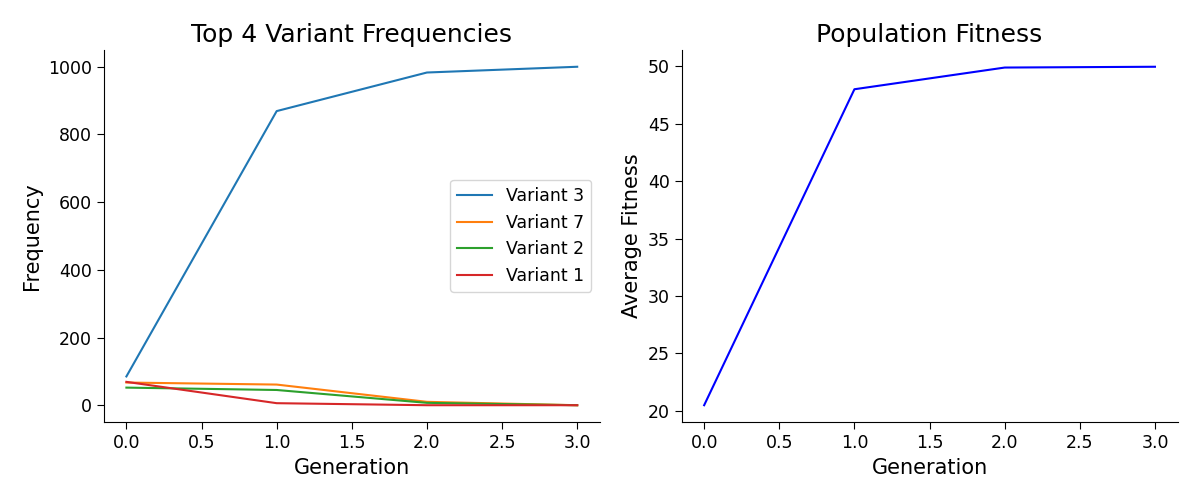

In [6]:
# @title evolutionary simulation method
#### integrate into utils later

def evolutionary_simulation(population_size=1000, num_generations=100,
                            slct_temp=None, mutation_rate=0.01, has_mutation=False,
                            cheating_population=False,
                            initial_variant=None,
                            stop_at_converged=True,
                            seed=None,
                            make_plot=True, generation_printout = False,
                            num_receptors=4,
                            num_food_items=4, num_non_food_items=4,
                            food_markers=None, non_food_markers=None,
                            reward=1, cost=1, food_freq=0.5,
                            hard_mode='hard',
                            n_trials=100, use_expectation=False):

  """
  Simulates the evolutionary process in a population of genotypes within the StrikeNoStrike environment.

  Args:
    population_size (int): The number of individuals in the population.
    num_generations (int): The number of generations over which evolution is simulated.
    slct_temp (float): Selection temperature, controlling the strength of selection, if None then use proportional selects default is None
    mutation_rate (float): The per-bit mutation rate applied to the population.
    has_mutation (bool): Flag to enable/disable mutation.
    cheating_population (bool): If True, initializes a population with a known advantage.
    initial_variant (np.ndarray): If provided, initializes population with this genotype.
    stop_at_converged (bool): If True, stops simulation once population converges to a single genotype.
    seed (int): Seed for random number generator for reproducible results.
    make_plot (bool): If True, generates a plot of the simulation results.
    generation_printout (bool): If True, prints detailed information about each generation.
    num_receptors (int): The number of receptors in the genotype.
    num_food_items (int): The number of food items in the environment.
    num_non_food_items (int): The number of non-food items in the environment.
    food_markers (np.ndarray): Specific food markers to initialize the environment.
    non_food_markers (np.ndarray): Specific non-food markers to initialize the environment.
    reward (float): The reward value for correctly identifying food.
    cost (float): The cost value for incorrectly identifying non-food as food.
    food_freq (float): The frequency at which food items appear in the environment.
    hard_mode (bool): If True, makes the environment more challenging by making food/non-food items more similar.
    n_trials (int): The number of trials used to compute genotype fitness.
    use_expectation (bool): If True, uses expectation for fitness calculation instead of stochastic simulation.

  Returns:
    List: The population fitness history across generations.
  """

  rng = np.random.default_rng(seed)
  # Initialize population with random genotypes or a specified initial variant.
  if initial_variant is not None:
    population = np.repeat([initial_variant], population_size, axis=0)
  else:
    population = rng.integers(0, 2, size=(population_size, num_receptors),
                              dtype=np.bool_)
    if cheating_population:
      # Introduce a known advantageous structure to half of the population.
      half_pop_size = population_size // 2
      first_half_zeros = np.zeros((half_pop_size, num_receptors // 2), dtype=np.bool_)
      second_half_ones = np.ones((half_pop_size, num_receptors - num_receptors // 2), dtype=np.bool_)
      population[:half_pop_size] = np.hstack([first_half_zeros, second_half_ones])

  # Initialize environment with given or generated markers.
  if food_markers is not None and non_food_markers is not None:
    snse = StrikeNoStrikeEnv(num_receptors=num_receptors,
                             food_markers=food_markers,
                             non_food_markers=non_food_markers,
                             reward=reward, cost=cost,
                             food_freq=food_freq,
                             rng=rng)
  else:
    snse = StrikeNoStrikeEnv(num_receptors=num_receptors,
                             num_food_items=num_food_items,
                             num_non_food_items=num_non_food_items,
                             reward=reward, cost=cost, hard_mode=hard_mode,
                             food_freq=food_freq, rng=rng)

  # Track frequency and fitness of genotypes over generations.
  all_freqs_history = collections.defaultdict(lambda: [0]*num_generations)
  all_fitness_history = collections.defaultdict(lambda: [None]*num_generations)
  pop_fitness_history = []
  observed_genotypes = set()
  peak_fitness = 0
  generation_of_peak_fitness = -1

  print(f"Population size: {population_size}")
  #print(f"Initial population {population[:10,:]}")
  if initial_variant is not None:
    print(f"Initial variant: {initial_variant}")
  print(f"Food markers:")
  display(np.array(snse.food_markers,dtype=int))
  print(f"Non-food markers:")
  display(np.array(snse.non_food_markers, dtype=int))
  print(f"Reward: {snse.reward}")
  print(f"Cost: {snse.cost}")
  print(f"Food frequency: {snse.food_freq}")
  print("---------------------------------------")

  # Main evolutionary loop across generations.
  for generation in tqdm(range(num_generations), desc='Simulating Generations'):
    # Calculate scores for each genotype.
    scores = [snse.compute_score(geno, n_trials=n_trials,
                                 use_expectation=use_expectation)
              for geno in population]

    # Convert scores to selection probabilities
    if slct_temp is None:
      # use proportional normalization
      pos_scores = [max(score, 0) for score in scores]
      if np.sum(scores) > 0:
        prob_scores = pos_scores / np.sum(pos_scores)
      else:
        prob_scores = np.ones_like(pos_scores) / len(pos_scores)
    else:
      # using selection temperature for softmax normalization
      exp_scores = np.exp(np.array(scores) / slct_temp)
      prob_scores = exp_scores / np.sum(exp_scores)


    # Count and display population makeup
    # ~~~~~~~~~ just display and tracking logic below ~~~~~~~~~~~~~~~~~~~~~~
    pop_counter = collections.Counter([tuple(np.array(ind, dtype=int))
                                       for ind in population])
    # Sort population counter
    pop_counter = {k: v for k, v in
                   sorted(pop_counter.items(), key=lambda item: item[1], reverse=True)}
    # Calculate the average score for each genotype
    genotype_to_scores = collections.defaultdict(list)
    for ind, score in zip(population, scores):
      genotype_key = tuple(np.array(ind, dtype=int))
      genotype_to_scores[genotype_key].append(score)
    avg_scores_by_type = {k: np.mean(v) for k, v in
                          sorted(genotype_to_scores.items(), key=lambda item: np.mean(item[1]), reverse=True)}

    newly_observed_genotypes = set(pop_counter.keys()) - observed_genotypes

    for new_genotype in newly_observed_genotypes:
      all_freqs_history[new_genotype][:generation] = [0]*generation
      all_fitness_history[new_genotype][:generation] = [None]*generation
    observed_genotypes.update(newly_observed_genotypes)

    # Update history dictionaries
    for genotype in observed_genotypes:
      freq = pop_counter.get(genotype, 0)
      all_freqs_history[genotype][generation] = freq
      avg_score = avg_scores_by_type.get(genotype, None)
      all_fitness_history[genotype][generation] = avg_score

    pop_fitness_history.append(np.mean(scores))

    if generation_printout:
      print(f"Generation {generation+1}: Mean Score = {np.mean(scores)}")
      print(f"Population makeup: {pop_counter}")
      print(f'Average scores by type: {avg_scores_by_type}')
      print('')
    # ~~~~~~~~~ just display and tracking logic above ~~~~~~~~~~~~~~~~~~~~~~
    if len(pop_counter) == 1:
      if stop_at_converged:
        print(f"Population has converged to a single genotype in generation {generation + 1}. Stopping simulation.")
        break
    # Resample population based on probabilities derived from scores
    # this is where selection happens based on scores
    population = population[
        rng.choice(np.arange(population_size),
                   size=population_size, p=prob_scores)]

    # mutation applied to next generation using XOR "^"
    # to introduce new variants, note this is a bitwise mutation rate
    if has_mutation:
      mutation_mask = rng.random(population.shape) < mutation_rate
      population ^= mutation_mask

  # simulation is done
  last_10_percent = int(0.1 * num_generations)
  avg_last_10_percent_fitness = np.mean(pop_fitness_history[-last_10_percent:])
  print(f"Average mean population fitness for the last 10% of rounds: {avg_last_10_percent_fitness:.4f}")

  def bits_to_int(bits):
    return int("".join(str(x) for x in bits), 2)

  if make_plot:
    # simulation is done, make a plot
    avg_freqs = {genotype: np.mean(freqs[:generation+1]) for genotype, freqs in all_freqs_history.items() if genotype in observed_genotypes}
    top_4_genotypes = sorted(avg_freqs, key=avg_freqs.get, reverse=True)[:4]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Plot for top 4 variant frequencies
    ax[0].set_title("Top 4 Variant Frequencies")
    ax[0].set_xlabel("Generation")
    ax[0].set_ylabel("Frequency")
    for geno in top_4_genotypes:
      ax[0].plot(all_freqs_history[geno][:generation+1], label=f"Variant {bits_to_int(geno)}")
    ax[0].legend()

    # Plot for population fitness
    ax[1].set_title("Population Fitness")
    ax[1].set_xlabel("Generation")
    ax[1].set_ylabel("Average Fitness")

    if num_generations > 100:
      # Actual data with lower alpha value
      ax[1].plot(pop_fitness_history[:generation+1], alpha=0.3, color='blue')
      # Smoothed time average (rolling mean) in a strong color
      smoothed_fitness = pd.Series(pop_fitness_history[:generation+1]).rolling(window=5).mean()
      ax[1].plot(smoothed_fitness, color='blue')
    else:
      ax[1].plot(pop_fitness_history[:generation+1], color='blue')

    remove_ip_clutter(fig)
    plt.tight_layout()
    plt.show()

  return(pop_fitness_history)


# Note: You'd replace this last part with your actual function call and parameters.
# evolutionary_simulation(slct_temp=5.0, random_init=False, num_generations=25, has_mutation=False)



fitness_hist = evolutionary_simulation(slct_temp=5.0, num_generations=25,
                        has_mutation=False)

Population size: 10000
Food markers:


array([[0, 1, 1, 1],
       [1, 0, 1, 1]])

Non-food markers:


array([[0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 1, 1, 0],
       [0, 1, 1, 0],
       [0, 1, 1, 0],
       [1, 0, 0, 1],
       [0, 1, 1, 0],
       [1, 0, 0, 1]])

Reward: 1
Cost: 1
Food frequency: 0.5
---------------------------------------


Simulating Generations:   0%|          | 0/8000 [00:00<?, ?it/s]

New best genotype score 68.0 reached at generation 1
New best genotype score 70.0 reached at generation 4
New best genotype score 71.0 reached at generation 7
New best genotype score 72.0 reached at generation 9
New best genotype score 74.0 reached at generation 13
New best genotype score 75.0 reached at generation 20
New best genotype score 76.0 reached at generation 22
New best genotype score 77.0 reached at generation 27
New best genotype score 78.0 reached at generation 61
New best genotype score 79.0 reached at generation 64
New best genotype score 80.0 reached at generation 87
New best genotype score 81.0 reached at generation 92
New best genotype score 82.0 reached at generation 94
New best genotype score 83.0 reached at generation 134
New best genotype score 84.0 reached at generation 993
New best genotype score 85.0 reached at generation 994
New best genotype score 86.0 reached at generation 1005
New best genotype score 87.0 reached at generation 1530
New best genotype score 8

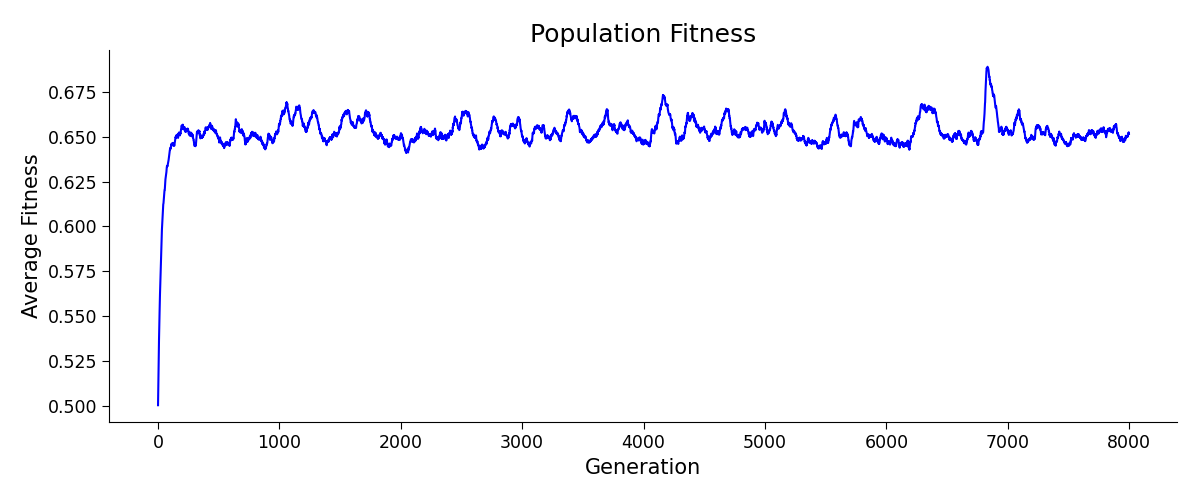

In [7]:
def simple_evolutionary_simulation(pop_size=1000, n_gen=100,
                                   mutation_rate=0.01, has_mutation=True,
                                   initial_variant=None,
                                   stop_at_converged=True,
                                   seed=None,
                                   make_plot=True, generation_printout = False,
                                   n_rcpt=200,
                                   slct_str = 0.01,
                                   r=1, c=1, p=0.5,
                                   n_trials=2,
                                   verbose=True):

  """
  Simulates the evolutionary process in a population of genotypes within the StrikeNoStrike environment.

  """
  rng = np.random.default_rng(seed)
  # Initialize population with random genotypes or a specified initial variant.
  if initial_variant is not None:
    population = np.repeat([initial_variant], pop_size, axis=0)
  else:
    population = rng.integers(0, 2, size=(pop_size, n_rcpt),
                              dtype=np.bool_)

  # Initialize environment with given or generated markers.
  food_markers = np.ones(n_rcpt, dtype=np.bool_).reshape(1, n_rcpt)
  non_food_markers = np.array(np.ones((n_rcpt, n_rcpt)) - np.eye(n_rcpt), dtype=np.bool_)
  # Initialize environment.
  max_score = n_trials * 0.5 * r

  # Track frequency and fitness of genotypes over generations.
  pop_fitness_history = []

  if verbose:
    print(f"Population size: {pop_size}")
    if initial_variant is not None:
      print(f"Initial variant: {initial_variant}")
    print(f"Food markers:")
    display(np.array(snse.food_markers,dtype=int))
    print(f"Non-food markers:")
    display(np.array(snse.non_food_markers, dtype=int))
    print(f"Reward: {snse.reward}")
    print(f"Cost: {snse.cost}")
    print(f"Food frequency: {snse.food_freq}")
    print("---------------------------------------")

  def compute_score(g):
    return n_trials * 0.5 * (r - c*(n_rcpt-np.sum(g))/n_rcpt)
  # Main evolutionary loop across generations.

  #
  gen_with_opt = 0
  best_geno_so_far = 0
  for generation in tqdm(range(n_gen), desc='Simulating Generations'):

    geno_sums = np.sum(np.array(population, dtype=float), axis=1)

    # Calculate scores for each genotype
    scores = n_trials * 0.5 * (r - c * (n_rcpt - geno_sums) / n_rcpt)

    if make_plot and generation_printout:
      if (generation % 100 == 0) or (generation == n_gen - 1):
        fig, ax = plt.subplots(figsize=(12, 5))
        sns.histplot(geno_sums, bins=30, kde=False, ax=ax)
        ax.set_title("Distribution of Genotype Sums")
        ax.set_xlabel("Sum of Genotype")
        ax.set_ylabel("Frequency")
        mean_geno_sum = np.mean(geno_sums)
        std_geno_sum = np.std(geno_sums)
        range_geno_sums = np.linspace(mean_geno_sum - 3*std_geno_sum, mean_geno_sum + 3*std_geno_sum, 100)
        normal_pdf = norm.pdf(range_geno_sums, mean_geno_sum, std_geno_sum)
        ax.plot(range_geno_sums, normal_pdf * len(geno_sums) * (max(geno_sums) - min(geno_sums)) / len(range_geno_sums), color='red')
        plt.show()

    best_geno_this_gen = np.max(geno_sums)
    if best_geno_this_gen > best_geno_so_far:
      best_geno_so_far = best_geno_this_gen
      if verbose:  # Use verbose flag to control printing
        print(f"New best genotype score {best_geno_so_far} reached at generation {generation+1}")

    if best_geno_this_gen == n_rcpt:
      gen_with_opt += 1
      if gen_with_opt >= 100:
        break

    pos_scores = [max(score, 0) for score in scores]
    if np.sum(scores) > 0:
      prob_scores = pos_scores / np.sum(pos_scores)
    else:
      prob_scores = np.ones_like(pos_scores) / len(pos_scores)

    pop_fitness_history.append(np.mean(scores))

    if generation_printout:
      print(f"Generation {generation+1}: Mean Score = {np.mean(scores)}")
      print('')

    population = population[
        rng.choice(np.arange(pop_size),
                   size=pop_size, p=prob_scores)]

    # mutation applied to next generation using XOR "^"
    # to introduce new variants, note this is a bitwise mutation rate
    if has_mutation:
      mutation_mask = rng.random(population.shape) < mutation_rate
      population ^= mutation_mask

  # simulation is done
  last_10_percent = int(0.1 * n_gen)
  avg_last_10_percent_fitness = np.mean(pop_fitness_history[-last_10_percent:])
  print(f"Average mean population fitness for the last 10% of rounds: {avg_last_10_percent_fitness:.4f}")

  def bits_to_int(bits):
    return int("".join(str(x) for x in bits), 2)

  if make_plot:
    # simulation is done, make a plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    # Plot for population fitness
    ax.set_title("Population Fitness")
    ax.set_xlabel("Generation")
    ax.set_ylabel("Average Fitness")

    if n_gen > 100:
      # Actual data with lower alpha value
      ax.plot(pop_fitness_history[:generation+1], color='blue')
    else:
      ax.plot(pop_fitness_history[:generation+1], color='blue')

    remove_ip_clutter(fig)
    plt.tight_layout()
    plt.show()

  return(pop_fitness_history)


# Note: You'd replace this last part with your actual function call and parameters.
# evolutionary_simulation(slct_temp=5.0, random_init=False, num_generations=25, has_mutation=False)



fitness_hist = simple_evolutionary_simulation(n_gen=8000, has_mutation=True,
                                              n_rcpt=100,
                                              pop_size=10000, n_trials=2,
                                              mutation_rate=0.01, r=1, c=1)

$$\Delta \text{geno_sum} = \Delta \text{geno_sum}_{\text{selection}} + \Delta \text{geno_sum}_{\text{mutation}} = s \cdot \text{Var}(\text{geno_sum}) + \mu \cdot (L - 2 \cdot \text{geno_sum})$$

$$\Delta \text{Var}(\text{geno_sum}) = \Delta \text{Var}(\text{geno_sum})_{\text{selection}} + \Delta \text{Var}(\text{geno_sum})_{\text{mutation}}$$

In [8]:
# Initial variables setup
mu = 0.001  # Example mutation rate
n = 100    # Length of the genotype bit string
z_bar = 60 # Mode of the population
r = 1      # Reward (set to 1 for simplification, can be adjusted)
c = 1      # Cost (set to 1 for simplification, can be adjusted)

# Compute mu_+ and mu_-
mu_plus = mu * (1 - mu)**(n - 1) * (n - z_bar) / n
mu_minus = mu * (1 - mu)**(n - 1) * z_bar / n

# Compute selective advantages for i = 1, 2, -1, -2
s_1 = 1 / (n * (r / c - 1) + z_bar)
s_2 = 2 / (n * (r / c - 1) + z_bar)
s_minus_1 = -1 / (n * (r / c - 1) + z_bar)
s_minus_2 = -2 / (n * (r / c - 1) + z_bar)

# Compute proportions p_1, p_2, p_-1, p_-2
p_1 = mu_plus / s_1
p_2 = (p_1 * mu_plus) / s_2
p_minus_1 = mu_minus / abs(s_minus_1)
p_minus_2 = (p_minus_1 * mu_minus) / abs(s_minus_2)

# Summarizing the results in a dictionary for easy access
results = {
    "mu_plus": mu_plus,
    "mu_minus": mu_minus,
    "s_1": s_1,
    "s_2": s_2,
    "s_minus_1": s_minus_1,
    "s_minus_2": s_minus_2,
    "p_1": p_1,
    "p_2": p_2,
    "p_minus_1": p_minus_1,
    "p_minus_2": p_minus_2
}

results


{'mu_plus': 0.00036227913798346706,
 'mu_minus': 0.0005434187069752007,
 's_1': 0.016666666666666666,
 's_2': 0.03333333333333333,
 's_minus_1': -0.016666666666666666,
 's_minus_2': -0.03333333333333333,
 'p_1': 0.021736748279008025,
 'p_2': 0.00023624311287247915,
 'p_minus_1': 0.03260512241851204,
 'p_minus_2': 0.0005315470039630781}

# 1.3.1.1: Mutation Rate, Population Size, Strength of Selection and Rate of Adaptation

We will continue to use the 'strike-no-strike' decision problem of the last sequence, but within an environment specifically tailored to streamline our simulations, reasoning and analysis. Consider an organism with $n$ chemosensory receptors, each corresponding to $n$ possible food/non-food chemical markers in the environment. The expression of these receptors is determined by $n$ distinct genetic switches, represented as a bitstring $g$ of length $n$ with 1 corresponding to expression and 0 to absence of the corresponding receptor. For the food source the marker consists of all 1's. The non-food items closely mimic this food signal, with each non-food item's marker differing from the food-item marker in exactly one marker/receptor slot. With $n$ receptors, this means we have $n$ distinct non-food item markers, each with distinct location for its solitary zero disrupting an otherwise unbroken set 1's.   

Recall a successful strike at edible food yields a reward, $r$ and conversely, a missed strike has a cost, $c$. And we simplify these costs and rewards as constant increment by $r$ or decrement by $c$ respectively to offspring quality and/or quantity. The organism's decision rule is to strike only if ***all*** of its receptors pick up a marker and refrains from striking if ***any*** of its receptors are left unactivated. (When the organism has no receptors technically all of its non-existent receptors are activated and so it strikes in all situations.)

With this decision rule, in this environment, the organism will always strike at the food-item. Each additional receptor expressed serves to sift out one specific type of non-food item, thereby reducing false positives. The singular 'optimal' genotype in this simple case consists of all 1's.

Let $p$ be the probability of encountering a food item and $1-p$ the probability of an encounter with a non-food item. Given $k$ trials, an organism is expected to encounter $p k$ food items for a total expected gamete increment of $p k r$ from these food items. It can also expect to encounter $(1-p)k$ non-food items, with each of $n$ distinct non-food item types being equally likely to be encountered. If a non-food item is encountered and the organism expresses the receptor that filters it out then the organism pays no cost, but if they do not express the filtering receptor particular to that specific non-food item they pay a cost of $c$. Then, the total expected fitness decrement from false strikes is  $k (1-p) \frac{c}{n} \sum_{i=1}^{n} (1 - g_i)$. Thus the expression of each receptor, i.e. having allele '1' instead of '0' at any loci, confers a small, independent, additive fitness benefit $ k (1-p) \frac{c}{n}$. The total expected gamete increment is

$$pkr - k (1-p)\frac{c}{n} \sum_{i=1}^n (1-g_i).$$

We can further simplify, setting $p = \frac{1}{2}$ and $c=r= \frac{2n}{k}$, and assuming that $k$ is very large. Even though the gamete increment for any one individual is a random variable dependent on how many food versus non-food items they encounter and which non-food items they encounter relative to the non-food items they effectively filter out, for large enough $k$ this randomnes averages out and we can treat the gamete increment of an individual as a determinisitc function of their genotype, specifically

$$ z(g) = \sum_{i=1}^n g_i $$

In this sense our scenario is very similar to that analyzed in the to McKay book and in "Beneficial Mutation-Selection Balance and the Effect of Linkage on Positive Selection" by Desai & Fisher 2007.

Before getting into any analyses lets observe how mutation rate, population size, and strength of selection impact two things, the final fitness level achieved by the population and the time it takes for the evolutionary process to discover the optimal genotype in this simplest of possible fitness landscapes.

While mutation rate and population size are relative strightforward concepts readily captured with a single variable, strength of selection is a more nebulouse concept a bears a little bit of thought and consideration.

The word fitness is often used loosely to mean anything which influences reproductive success and survivability as a result of being 'well fit' to the environment. This is fine, but if we wish to quantify and be more precise about evolutionary dynamics, and in particular strength of selection we need to refine our thinking around the term fitness first.

In a strict sense fitness is defined as the growth (or decline) rate of the proportion of an allele, type, lineage, or really anything the can be unambiguously categorized and counted, the population from one census time to the next. So if $p_i(t)$ is the proportion of type $i$ in the population at time $t$ and $p_i(t+1)$ the proportion at time $t+1$ then the fitness of type $i$ in that population with that census interval is $w_i(t) = \frac{p_i(t+1)}{p_i(t)}$.

This definition of fitness hinges on the idea of a population, discrete census times, and unmabiguous categorization and counting of types. There is an equivalent continuous time versions of this definition based on differential equations of continuously evoloving proportions instead of ratios between census time counts.

For fitness defined in terms of population proportions like this, average fitness across the population is always be exactly 1, So fitness is alway about **relative** advantage. How much more quickly does one gene spread versus another, how much more quickly does one lineage expand compared to another. In evolutionary models the function often refered to as the 'fitness' function does not directly give fitness in the sense of growth rate (as defined above), but rather some score upon which selection and reproduction is based. We will call such functions a 'fitness score' function to differentiate it from fitness in the strict sense of repropuctive rate. In our model above $z(g)$ is such a 'fitness score' function. It gives a score to each genotype, but how this score translates into an actual rate of reproduction will depend on the specific details of the evolutionary model. Because fitness in the strict sense is **relative** growth, the fitness of any one type will **always** depend on the relative frequencies and 'fitness scores' of the various other types in the population. The details of this dependency emerge from the specifics of the evolutionaru model, in particular exactly how selective reproduction is determined by the 'fitness score'.

In the coding exercise below we will implement three different kinds of selection mechanism and see how they impact an evolutionary simulation while holding mutation rate, and population size constant. This will help us to develop a sense of the impact of 'selection strength' and how it might be operationalized both in our simulations and models, but also out in the real world both by breeders (artificial selection) and in the wild (natural selection).

Different selection types.
Each individual in the population has a genotype $g$, and a resulting score $z(g) = \sum{i=1}^n g_i$, i.e. the number of 'good bits'. But, how should these scores translate into probabilities of reproduction, or reproductive rates? There are many reasonable models, that correspond (roughly) to different realistic situations. Here are a few


1. Proportional Selection: Each individual's probability of being a parent is strictly proportional to their score. This corresponds roughly to broadcast style egg laying and fertilzation as utilized by many sea creatures and plants. In our interpretation of $r$ and $c$ being in terms of gametes produced that then 'compete' in the sense of being lucky and landing viable lair sites, this is a good model. This also aligns with the idea of each gene giving a constant additive increase to 'fitness score'. Note however that as the average 'fitness score' of the population increases, the relative impact on reproductive rate from any one gene will decrease.
2. Truncation Selection (Deterministic Uniform) : Each individuals's probability of being a parent is exactly 1 if they have a score above a certain threshold quantile, and exactly 0 if they are below that threshold quantile. The number of offspring produced by each parent is the same, so e.g. if a population with fixed size, and a cut-off quantile or $0.5$, each parent would produce exactly 2 offspring. If $z(g)$ were interpreted as offspring quality instead of quantity, and there was strict 'survival of the fittest' this would be a good model. Similarly, if $z(g)$ corresponded to something a breeding farmer was trying to maximize like milk or egg production, or weight gain effeciency per feedstock inputs over some time interval, then truncation selection is often utilized  
3. Softmax Proportional Selection: Each individual's probability of being a parent is proportional to a (scaled) exponential of their score. For low temperature scaling, this becomes somewhat like truncation selection, with only the most fit individuals having any chance of reproduction, i.e. very strong selection. With high temperature scaling selection is very weak. With probability of reproduction proportional to the exponential score, gene gives a constant multiplicative increase to reproductive rate, so that the relative impact on reproductive rate from any one gene remains constant regardless of the current baseline 'fitness score'.

Various combinations of these three basic types (and many other forms besides) are possible, but focussing on these three is suffocient for our illustrative purposes.

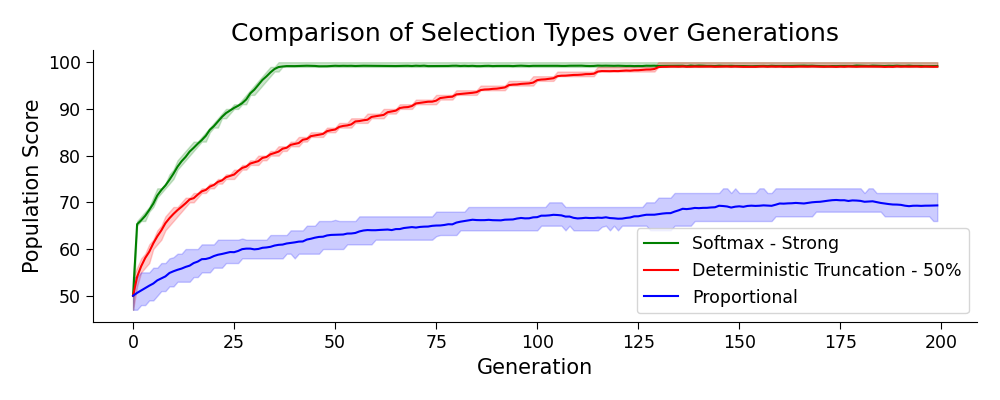

In [45]:
def selection_type_simulation(pop_size=1000, n_gen=100, n_rcpt=100,
                              mutation_rate=0.005, has_mutation=True,
                              selection_type='proportional', #softmax, deterministic truncation, proportional truncation
                              softmax_temp=1, truncation_threshold=0.5,
                              seed=None):
  """
  Simulates the evolutionary process in a population of genotypes playing the
  Strike-No-Strike game using different types of selection and compare the
  outcomes.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  # Initialize population
  population = rng.integers(0, 2, size=(pop_size, n_rcpt),
                                dtype=np.bool_)

  # Track statistics genotype scores over generations.
  mean_hist = np.zeros(n_gen)
  var_hist = np.zeros(n_gen)
  skew_hist = np.zeros(n_gen)
  lower_quartile_hist = np.zeros(n_gen)
  upper_quartile_hist = np.zeros(n_gen)

  for generation in range(n_gen):
    # Calculate scores for each genotype
    scores = np.sum(np.array(population, dtype=float), axis=1)

    mean_ = np.mean(scores)
    var_ = np.var(scores)
    skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
     (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    mean_hist[generation] = mean_
    var_hist[generation] = var_
    skew_hist[generation] = skew_
    lower_quartile_hist[generation] = np.percentile(scores, 25)
    upper_quartile_hist[generation] = np.percentile(scores, 75)

    # Calculate fitness for each genotype

    # Selective Reproduction
    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      if np.sum(scores) > 0:
        prob_scores = pos_scores / np.sum(scores) # this line as exercise
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = np.exp(stabilized_scores / softmax_temp) # this line
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)  # and this line as exercise
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      # Deterministic truncation selection
      selected = scores >= np.quantile(scores, truncation_threshold) # this line as exercise
      selected_indices = np.arange(len(scores))[selected]
      # Create the new population
      new_population = []
      base_replication_count = int(pop_size / len(selected_indices))
      additional_replications = pop_size % len(selected_indices)
      for idx in selected_indices:
        new_population.extend([population[idx]] * base_replication_count) # this line as exercise
      # If there are additional replications needed, add the highest scoring individuals
      if additional_replications > 0:
        sorted_selected_indices = selected_indices[np.argsort(-scores[selected])]
        new_population.extend([population[idx] for idx in sorted_selected_indices[:additional_replications]])
      population = np.array(new_population)
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")
    if selection_type != 'deterministic truncation':
      population = rng.choice(population, size=pop_size, p=prob_scores) # this line as exercise

    # mutation
    mutation_mask = rng.random(population.shape) < mutation_rate
    population ^= mutation_mask

  return mean_hist, var_hist, skew_hist, upper_quartile_hist, lower_quartile_hist


def plot_selection_results(ax, selection_type, n_gen, color, label, seed,
                           softmax_temp=1, truncation_threshold=0.5,
                           mutation_rate=0.005, pop_size=1000):
    (mean_hist, var_hist, skew_hist,
     upper_quartile_hist, lower_quartile_hist) = selection_type_simulation(
        selection_type=selection_type,
        n_gen=n_gen,
        seed=seed,
        softmax_temp=softmax_temp,
        truncation_threshold=truncation_threshold,
        mutation_rate=mutation_rate,
        pop_size=pop_size
    )
    generations = np.arange(n_gen)
    ax.fill_between(generations, lower_quartile_hist, upper_quartile_hist,
                    color=color, alpha=0.2)
    ax.plot(generations, mean_hist, color=color, label=label)

# Number of generations
n_gen = 200
seed = 123

fig, ax = plt.subplots(figsize=(10, 4))

plot_selection_results(ax, 'softmax', n_gen, 'green', 'Softmax - Strong', seed)
#plot_selection_results(ax, 'softmax', n_gen, 'lightgreen', 'Softmax - Weak',
#                       seed, softmax_temp=7)
plot_selection_results(ax, 'deterministic truncation', n_gen, 'red',
                       'Deterministic Truncation - 50%', seed)
#plot_selection_results(ax, 'deterministic truncation', n_gen, 'pink',
#                       'Deterministic Truncation - 99%', seed,
#                       truncation_threshold=0.99)
plot_selection_results(ax, 'proportional', n_gen, 'blue', 'Proportional', seed)

ax.set_xlabel('Generation')
ax.set_ylabel('Population Score')
ax.set_title('Comparison of Selection Types over Generations')
ax.legend()

remove_ip_clutter(fig)
plt.show()

Both 'softmax' and 'deterministic truncation' selection are able to drive the the populations score up to the 'perfect' score of 100, but 'proportional' selection does not. What is going on here? As the average score of the population increases, the **relative** fitness advantage of an additional 'score point' becomes very slight, so slight that the 'signal' from the environment becomes overwhelmed by the stochasticy in selection. A larger population can serve as a partial counter to this stochasticity allowing weakly selected traits to become dominant in a population. Note that in our model truncation selection is deterministic and assumes that individuals can be perfectly sorted by score. In reality even if 'survival of the fittest' style selection is being applied, there is always the possibility of some 'error in measurment' whether that be by the breeder or the environment. All this to show that strength of selection is really important in determining how quickly, in terms of generations, a good solution is found.

Run the code cell below and use the output to answer these questions?
1. What do you think will happen if mutation rate is increased.
2. What do you think will happen if population size is increased.

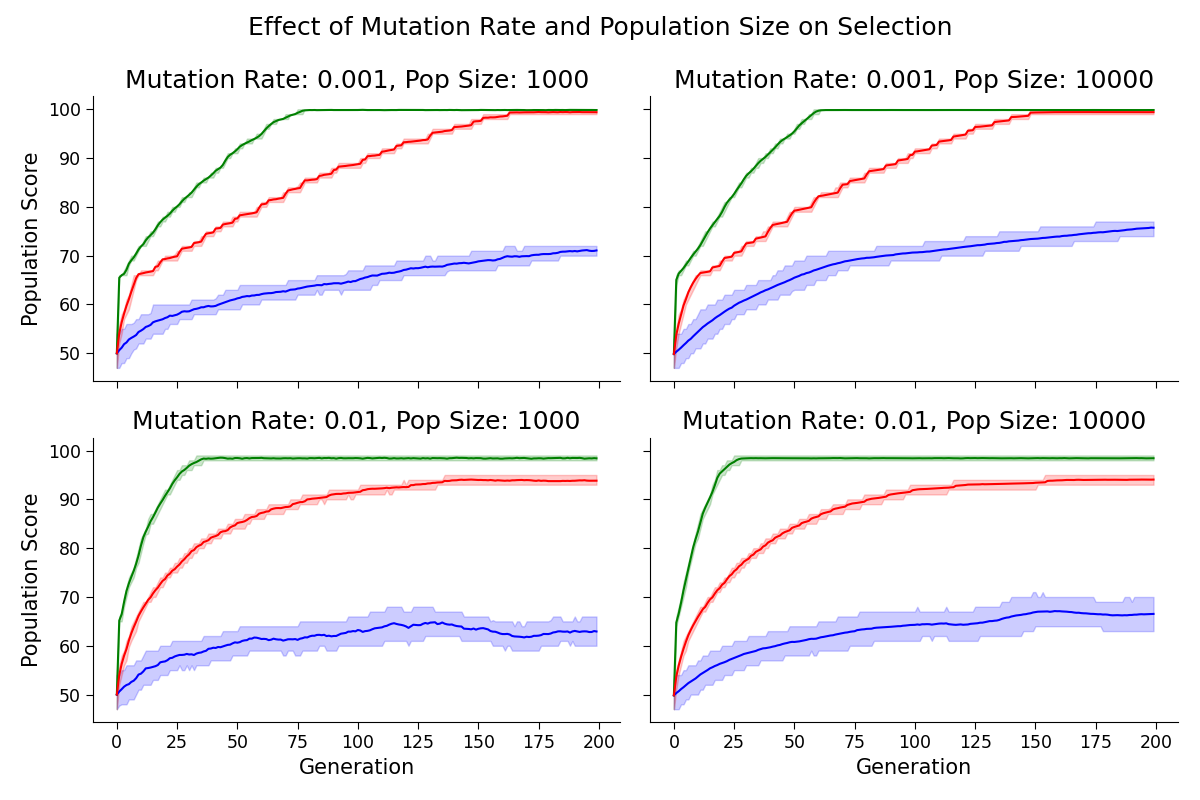

In [49]:
# Define different values for mutation rates and population sizes
mutation_rates = [0.001, 0.01]  # Example mutation rates
population_sizes = [1000, 10000]  # Example population sizes

# Define the number of generations and the seed
n_gen = 200
seed = 123

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
fig.suptitle('Effect of Mutation Rate and Population Size on Selection')

# Iterate over different mutation rates and population sizes
for i, mutation_rate in enumerate(mutation_rates):
  for j, pop_size in enumerate(population_sizes):
    ax = axs[i, j]
    plot_selection_results(ax, 'softmax', n_gen, 'green', 'Softmax',
                           seed, softmax_temp=1, truncation_threshold=0.5,
                           mutation_rate=mutation_rate, pop_size=pop_size)
    plot_selection_results(ax, 'proportional', n_gen, 'blue', 'Proportional',
                           seed, softmax_temp=1, truncation_threshold=0.5,
                           mutation_rate=mutation_rate, pop_size=pop_size)
    plot_selection_results(ax, 'deterministic truncation', n_gen, 'red', 'Truncation',
                           seed, softmax_temp=1, truncation_threshold=0.5,
                           mutation_rate=mutation_rate, pop_size=pop_size)
    ax.set_title(f'Mutation Rate: {mutation_rate}, Pop Size: {pop_size}')
    if i==1:
      ax.set_xlabel('Generation')
    if j==0:
      ax.set_ylabel('Population Score')
# Adjust layout and show plot
plt.tight_layout()
remove_ip_clutter(fig)
plt.show()


In [35]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

class EvolutionSimulationWidget:

    def __init__(self):
        # Make sliders
        self.population_size_slider = widgets.IntSlider(
            min=10, max=1000, step=10, value=100, description='Population Size')
        self.mutation_rate_slider = widgets.FloatLogSlider(
            value=0.01, base=10, min=-4, max=0, step=0.1, description='Mutation Rate (log)')
        self.selection_strength_slider = widgets.FloatSlider(
            min=0.0, max=1.0, step=0.01, value=0.5, description='Selection Strength')
        self.selection_type_dropdown = widgets.Dropdown(
            options=['proportional', 'softmax', 'deterministic truncation', 'proportional truncation'],
            value='proportional', description='Selection Type')
        # Create compute button
        self.compute_button = widgets.Button(description="Run Simulation")
        self.compute_button.on_click(self.update_plot)

        # Organize widgets
        self.sliders = widgets.VBox([self.population_size_slider,
                                     self.mutation_rate_slider,
                                     self.selection_strength_slider,
                                     self.selection_type_dropdown,
                                     self.compute_button])

        self.out = widgets.Output()
        self.final_display = widgets.HBox([self.sliders, self.out])

    def run_simulation(self):
        # Run the simulation with parameters from the sliders
        mean_hist, _, _, _, _ = selection_type_simulation(
            pop_size=self.population_size_slider.value,
            n_gen=200,  # Number of generations, you can adjust this if needed
            mutation_rate=self.mutation_rate_slider.value,
            selection_type=self.selection_type_dropdown.value,
            softmax_temp=self.selection_strength_slider.value,  # Used when softmax is selected
            truncation_threshold=self.selection_strength_slider.value,  # Used when truncation is selected
            seed=123)
        return mean_hist

    def update_plot(self, change):
        with self.out:
            clear_output(wait=True)
            mean_hist = self.run_simulation()

            # Now plot the results
            plt.figure(figsize=(10, 5))
            plt.plot(mean_hist)
            plt.xlabel('Generations')
            plt.ylabel('Average Fitness')
            plt.title('Evolutionary Simulation')
            plt.show()

# Usage
evolution_widget = EvolutionSimulationWidget()
display(evolution_widget.final_display)


In [36]:
class EvolutionSimulationWidget:

  def __init__(self):
    # Make sliders
    self.population_size_slider = widgets.IntSlider(min=10, max=1000, step=10,
                                                    value=100,
                                                    description='Population Size')
    self.mutation_rate_slider = widgets.FloatLogSlider(value=0.01, base=10,
                                                       min=-4,  # min exponent
                                                       max=0,   # max exponent
                                                       step=0.1,  # exp step
                                                       description='Mutation Rate (log)')
    self.selection_strength_slider = widgets.FloatSlider(min=0.0, max=.5,
                                                         step=0.01, value=0.1,
                                                         description='Selection Strength')
    # Create compute button
    self.compute_button = widgets.Button(description="Run Simulation")
    self.compute_button.on_click(self.update_plot)

    # Organize widgets
    self.sliders = widgets.VBox([self.population_size_slider,
                                 self.mutation_rate_slider,
                                 self.selection_strength_slider,
                                 self.compute_button])

    self.out = widgets.Output()
    self.final_display = widgets.HBox([self.sliders, self.out])

  def run_simulation(self):
    # Here you would call your actual simulation function and pass the parameters from the sliders
    r = 1.0
    n = 200
    c = self.selection_strength_slider.value * r * n
    p = 0.5

    fitness_history = evolutionary_simulation(
      num_receptors=n, num_generations=600, has_mutation=True,
      mutation_rate=self.mutation_rate_slider.value,
      population_size=self.population_size_slider.value,
      cost= c, reward=r, food_freq=p,
      seed=12,)
    return fitness_history

  def update_plot(self, change):
    with self.out:
      clear_output(wait=True)  # Clear the previous output
      fitness_history = self.run_simulation()

      # Now plot the results
      plt.figure(figsize=(10, 5))
      plt.plot(fitness_history)
      plt.xlabel('Generations')
      plt.ylabel('Average Fitness')
      plt.title('Evolutionary Simulation')
      plt.show()

# Usage
evolution_widget = EvolutionSimulationWidget()
display(evolution_widget.final_display)

Okay now that we've looked at a few simulations let's see if we can make sense of what is going on here analytically. To simplify our analysis we will assume that the number of trials is very large $k\to \infty$, and that reward and the cost to $r=c=\frac{2}{k}$ and the probability of food and non-food encounters is equal, so that the score of an individual playing the strike no-strike game is effectively deterministic and their score is simply the normalized sum of the number of allels in the 'good' state i.e. $z(g) = \frac{1}{n}\sum_{i=0}^{n} g_i$.

To understand how the distribution of the value of $z$ in the population evolves over time we need to consider the effect of mutation and the effect of selection on the value of the trait from one generation to the next. Although $z$ is in fact discrete we will use a normal approximation to describe the state of the population. For large genome and large population size, where $z$ is not too close to its boundaries (0 and 1) this is a reasonable approximation, as can be seen from comparison with the simulations.

Suppose at generation $t$ we have $z \sim \mathcal{N}(\mu, \sigma^2)$, and $\rho(z)$ the corresponding normal density function. Only some members of the population will be 'selected' to reproduce. If parents were selected uniformly from the population the distribution of the parent population would be the same as the population in general. However, the probability of being a parent depends on $z$ so selection will change the shape of this distribution. In particular we can think of the 'proportion' of the population with a particular trait value $z$ as given by $\rho(z)$, and their reproductive values as proportional to $z$. Then the expected value of $z$ in the parent population is

$$
E[z_{\text{sel}}] = \frac{\int z \cdot z \cdot \rho(z) dz}{\int z \cdot \rho(z) dz}
$$
$$
E[z_{\text{sel}}] = \frac{E[z^2]}{E[z]} = \frac{\mu^2 + \sigma^2}{\mu} = \mu \left(1 + \frac{\sigma^2}{\mu^2}\right)
$$
So, the change in $z$ due to selection is proportional to the heritable variance available for selection to act on (relative to the baseline fitness $\mu$). Selection increase the trait $z$. Since $z$ proportional to fitness this aligns with expectations. But, what does selection do to the variation?


By definition
$$ Var[z_{\text{sel}}] = E[z^2 | \text{selected}] - (E[z | \text{selected}])^2$$
and
$$ E[z^2 | \text{selected}] = \frac{\int z^3 \cdot \rho(z) dz}{\int z \cdot \rho(z) dz} =  \frac{\mu^{3}+3\mu \sigma ^{2}}{\mu} = \mu^2 + 3 \sigma^2$$
so putting this together we have

$$ Var[z_{\text{sel}}] = \left( \mu^2 + 3 \sigma^2 \right) - \left( \mu + \frac{\sigma^2}{\mu} \right)^2 = \sigma^2 \left(1 - \frac{\sigma^2}{\mu^2}\right)$$


So to summarize the effect of selection on the mean and variance of the distribution of the trait $z$ is:

$$ E[z_{\text{sel}}] = \mu \left( 1 + \frac{\sigma^2}{\mu^2}\right) $$
$$ Var[z_{\text{sel}}] = \sigma^2 \left( 1 - \frac{\sigma^2}{\mu^2}\right) $$

So the mean of $z$ increases and the variation of $z$ decreases. Selection can be seen as a process that (usually) reduces variation in the population to increase fitness. (In some situations selection can increase variance by increasing the frequency of rare types.) Heritable variation in traits is what selection work with. Selection only makes the mean fitness greater by 'weeding out' the less fit variants, and increasing the frequency of the more fit variants.

Now we turn our attention to mutation.

If a parent has trait $z$ what is the distribution of the the trait, $z_\text{mut}$, among their offspring as a result of muatation. Let $m$ be the per bit mutation rate and recall that $n$ is the total number of bits in the part of the genotype being modeled. Then child value is the sum of the parent's $z$ value less the number of 'good' bits($nz$) that mutate, with probability $m$ per bit, to 'bad' bits plus the number of 'bad' bit that flip to 'good', again with probability $m$ for each bit, that is
$$z_\text{mut} \sim z - \frac{\text{Bin}\left(nz, m\right)}{n} + \frac{\text{Bin}(n(1-z), m)}{n} $$

So $$E[z_\text{mut}] = z + (1-2z)m$$ and $$Var[z_\text{mut}] = \frac{nzm(1-m)}{n^2} + \frac{n(1-z)m(1-m)}{n^2} = \frac{m(1-m)}{n}\simeq \frac{m}{n}$$

Now, let's put mutation and selection together and look at their combined impact on our population's trait distribution, $z$. We'll assume that mutation and selection are independent processes, and their effects can be linearly superimposed. This assumption simplifies our analysis without significantly compromising the accuracy for a large population with a large genome. Letting $z'$ denote the distribution in the population of the character after one generation of selection and reproduction with mutation given $z \sim \mathcal{N}(\mu, \sigma^2)$ in the previous generation we have

$$E[z'] = E[z_\text{mut}|z_{\text{sel}}] = E[z_\text{sel}] + (1-2E[z_\text{sel}])m$$
Substituting in $E[z_\text{sel}]$ we have
$$E[z'] = \mu \left(1 + \frac{\sigma^2}{\mu^2}\right) + \left(1 - 2\mu \left(1 + \frac{\sigma^2}{\mu^2}\right)\right)m$$

and for the variance

$$ \text{Var}[z'] = \text{Var}[z_\text{mut} | z_\text{sel}] \approx \sigma^2 \left(1 - \frac{\sigma^2}{\mu^2}\right) + \frac{m}{n}$$.

Now based on our assumptions about the strength of selection we assume that the variance is relatively stable from one time step to the next, i.e. that the amount of variation added by mutation and the amount of variation removed by selection on any given generation are roughly in balance then

$$ \sigma^2 \simeq \sigma^2 \left(1 - \frac{\sigma^2}{\mu^2}\right) + \frac{m}{n}$$

$$ \frac{m}{n} \simeq \frac{\sigma^4}{\mu^2}$$

$$ \sigma^2 \simeq \mu \cdot \sqrt{\frac{m}{n}} $$

Now obviously both $\mu$ and $\sigma^2$ will changing over time until equilibrium is reached, but for large $n$ and small $m$ the rate of change for $\sigma^2$ will be much smaller, so our approximation here should not be too bad. Note that the variance added by mutation is constant, while the variance reduced by selection is proportion to the existing variance, so population variation will settle into this equilibrium eventually, our approximation here is based on the idea that this balance is roughly maintained even as the mean of the distribution shifts upward due to selection.

Also note that as the mean population value of $z$ increases, so too does the variance of $z$ (according to this model). This phenomenon arises because, although the mutation rate stays constant, the strength of selection diminishes as the mean of $z$ in the population increases. With lower strength of selection, the rate at which deleterious mutants are cleared from the population and the rate at which beneficial mutations grow and shift the population composition diminishes, and so greater variance is able to persist in the population. But why is the stength of selection decreasing as the mean value of $z$ increases? Although the absolute effect of each allele at each locus is constant, their relative impact diminishes as the the population mean of $z$ increases. This underscores another important point, ***fitness is always relative***. A function impacting fitness, like $z(g)$ in our example, might be absolute and depend solely on the traits/genes of a single individual. However, the way this score translates into frequency changes of genotypes or alleles at the population level — that is, fitness — is inherently dependent on the relative standing of those traits/genes within the population context. In other words, an individual's fitness can never be just a product of their own genes and traits, but must also depend on how those genes and corresponding traits compare to those of the rest of the population.

Using this approximation for the variance we estimate the rate of change of the trait (i.e. the proportion of the genome the improves on average in the population per generation) to be
$$ \Delta \mu = E[z'] - \mu $$
$$ \Delta \mu = \frac{\sigma^2}{\mu} + m \left( 1- 2 \left( \mu + \frac{\sigma^2}{\mu}\right) \right)$$
$$ \Delta \mu = \sqrt{\frac{m}{n}} - 2m\left(\mu - \frac{1}{2}\right) + 2m \sqrt{\frac{m}{n}}$$

The change in fitness can be interpreted as the increase caused by selection $\sqrt{\frac{m}{n}}$  (which is the root of the variation introduced each generation due to mutation), the decrase caused my mutation $ -2m \left(\mu -\frac{1}{2} \right)$ (this will be an increase when $\mu < \frac{1}{2}$), and a (comparitively small) interaction term between mutation and selection $2m \sqrt{\frac{m}{n}}.$

If the expected number of bits flipped by mutation per genotype,
$mn$, is greater than 1, then model predicts that the mean trait of the population will approaches an equilibrium value $\mu^* \simeq \frac{1}{2} + \frac{1}{2\sqrt{mn}} - \sqrt{\frac{m}{n}}$. Note that when $mn < 1$ the model predicts equilibrium values greater than one which is outside of the allowable range of $\mu$. This is because the model is somewhat inaccurate in that the true probability distribution of $z$ is non-Gaussian, asymmetrical, and quantized to integer values. This approximation works relatively well, (in terms of alignment with simulations), when the equilibrium value predicted is far enough from the upper bound on $z$ that the normal approximation is not postulating postitive variation above the mean that simply would not be present if the true distribution (which would be truncated at 1) were being used. To improve the model in these cases we would need to use the appropriate truncated normal distribution. But the model does make the prediction that for $mn > 1$ the mutation rate is so high, that the population will never attain the optimal "all 1's" genotype; the relative selective advantage of any given locus having the 1 allele instead of the 0 allele is too small compared to the rate at which mutation introduces new (typically less fit) types, and population's genotype cannot 'improve' past a certain point.

Let's see how the model model compares to a more direct simulation.

In [ ]:
def evo_sim_and_model(pop_size=10000, n_gen=100, n_rcpt=200,
                      mutation_rate=0.02, has_mutation=True,
                      use_expectation=True, num_trials=None,
                      selection_type='proportional', #softmax, truncation, deterministic_truncation
                      softmax_temp=1, truncation_threshold=0.5,
                      deterministic_truncation=True,
                      make_plot=True,
                      seed=None):
  """
  Simulates the evolutionary process in a population of genotypes playing the
  Strike-No-Strike game and compares with the model approximations.
  """

  # Run the simulation
  rng = np.random.default_rng(seed)
  population = rng.integers(0, 2, size=(pop_size, n_rcpt),
                              dtype=np.bool_)

  # Track statistics genotype scores over generations.
  mean_hist_sim = np.zeros(n_gen)
  var_hist_sim = np.zeros(n_gen)
  skew_hist_sim_theory = np.zeros(n_gen)
  skew_hist_sim_observed = np.zeros(n_gen)

  for generation in tqdm(range(n_gen), desc='Simulating Generations'):
    # Calculate scores for each genotype
    geno_sums = np.sum(np.array(population, dtype=float), axis=1)
    scores = geno_sums

    sim_mean = np.mean(scores)
    sim_var = np.var(scores)
    mean_hist_sim[generation] = sim_mean
    var_hist_sim[generation] = sim_var
    theory_skew = ((1 - 2 * mutation_rate) / np.sqrt(n_rcpt * mutation_rate * (1 - mutation_rate))) * \
                       ((n_rcpt - 2 * (sim_mean + sim_var / sim_mean)) / n_rcpt)
    skew_hist_sim_theory[generation] = theory_skew
    skew_hist_sim_observed[generation] = ((pop_size / (pop_size - 1) / (pop_size-2)) *
     (np.sum((scores-np.mean(scores))**3) / np.std(scores)))

    # Selection
    if selection_type == 'proportional':
      # Proportional selection
      pos_scores = np.where(scores < 0, 0, scores)
      if np.sum(scores) > 0:
        prob_scores = pos_scores / np.sum(scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      # this is like saying that each mutation has multiplicative instead of
      # an additve effect on fitness score, this will mean that the relative
      # fitness effect of a mutation is constant, which may be more in line
      # with what people were thinkoing
      exp_scaled_scores = np.exp((scores - np.max(scores)) / softmax_temp)
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)
    elif selection_type == 'truncation':
      # Truncation selection
      trunc_scores = np.zeros_like(scores)
      trunc_scores[scores >= np.quantile(scores, truncation_threshold)] = 1
      if np.sum(scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic_truncation':
      # Deterministic truncation selection
      selected_indices = np.where(scores >= np.quantile(scores, truncation_threshold))[0]
      num_selected = len(selected_indices)
      if num_selected == 0:
        raise ValueError("No individuals selected; adjust the truncation threshold.")
      base_replication_count = pop_size // num_selected
      additional_replications = pop_size % num_selected
      # Create the new population
      new_population = []
      for idx in selected_indices:
        new_population.extend([population[idx]] * base_replication_count)
      # If there are additional replications needed, add the highest scoring individuals
      if additional_replications > 0:
        sorted_selected_indices = selected_indices[np.argsort(-scores[selected_indices])]
        new_population.extend([population[idx] for idx in sorted_selected_indices[:additional_replications]])
      population = np.array(new_population)
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, truncation, or deterministic_truncation")
    if selection_type != 'deterministic_truncation':
      population = rng.choice(population, size=pop_size, p=prob_scores)

    # mutation
    mutation_mask = rng.random(population.shape) < mutation_rate
    population ^= mutation_mask


  # Run model calculations
  mean = n_rcpt/2  # Starting mean trait value
  var = n_rcpt/4  # Starting variance
  skew = 0 #starting skew
  sigma = np.sqrt(var)
  mean_hist_model = np.zeros(n_gen)
  var_hist_model = np.zeros(n_gen)
  skew_hist_model = np.zeros(n_gen)

  for ii in range(n_gen):
    mean_hist_model[ii] = mean
    var_hist_model[ii] = var
    skew_hist_model[ii] = skew
    delta_mean_sel = var / mean
    delta_var_sel = var * ((skew * sigma / mean) - var/mean**2)
    mean_post_sel = mean + delta_mean_sel
    var_post_sel = var + delta_var_sel

    delta_mean_mut = mutation_rate * (n_rcpt - 2*mean_post_sel)
    delta_var_mut = n_rcpt * mutation_rate * (1-mutation_rate)

    mean_post_mut = mean_post_sel + delta_mean_mut
    var_post_mut = var_post_sel + delta_var_mut

    mean = mean_post_mut
    var = var_post_mut
    sigma = np.sqrt(var)
    #skew = sigma
    skew = (sigma / mean) - (mean / sigma**3 * n_rcpt * mutation_rate * (1-mutation_rate))
    #skew = ((1-2*mutation_rate)/np.sqrt(n_rcpt * mutation_rate * (1-mutation_rate))) * \
    # ((n_rcpt - 2*(mean + sigma/mean))/n_rcpt)
    #skew = 0

  if make_plot:
    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    # Plot for mean
    axes[0].plot(mean_hist_sim, label='Simulation Mean')
    axes[0].plot(mean_hist_model, label='Model Mean')
    axes[0].set_title('Mean over Generations')
    axes[0].set_xlabel('Generation')
    axes[0].set_ylabel('Mean')
    axes[0].legend()

    # Plot for variance
    axes[1].plot(var_hist_sim, label='Simulation Variance')
    axes[1].plot(var_hist_model, label='Model Variance')
    axes[1].set_title('Variance over Generations')
    axes[1].set_xlabel('Generation')
    axes[1].set_ylabel('Variance')
    axes[1].legend()

    # Plot for skewness
    axes[2].plot(skew_hist_sim_observed, label='Observed Empirical Skewness (Simulation)')
    axes[2].plot(skew_hist_sim_theory, label='Theoretical Skewness (Simulation)')
    axes[2].plot(skew_hist_model, label='Model Skewness')
    axes[2].set_title('Skewness over Generations')
    axes[2].set_xlabel('Generation')
    axes[2].set_ylabel('Skewness')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

  results = {
    'mean_hist_sim': mean_hist_sim,
    'var_hist_sim': var_hist_sim,
    'skew_hist_sim_observed': skew_hist_sim_observed,
    'skew_hist_sim_theory': skew_hist_sim_theory,
    'mean_hist_model': mean_hist_model,
    'var_hist_model': var_hist_model,
    'skew_hist_model': skew_hist_model
    }
  return(results)

# Demonstration of the function
results = evo_sim_and_model(n_gen=600, pop_size=1000, n_rcpt=100,
                  mutation_rate=0.0001, has_mutation=True,
                  selection_type='proportional',
                  deterministic_truncation=False,
                  seed=123)


In [ ]:
results['skew_hist_sim_theory'][-20:]

## The fitness cost of mutation.

1. **Define Binomial Distributions**:
   Consider $ B_1 $ and $ B_2 $ as two independent binomial distributions with the same probability of success $ p $, but potentially different numbers of trials, denoted by $ n_1 $ and $ n_2 $. The means and variances of $ B_1 $ and $ B_2 $ are $ \mu_1, \mu_2 $ and $ \sigma_1^2, \sigma_2^2 $, respectively.

2. **Define the Difference Variable**:
   Define a new random variable $ X = B_1 - B_2 $. The mean and variance of $ X $ are $ \mu_X = \mu_1 - \mu_2 $ and $ \sigma_X^2 = \sigma_1^2 + \sigma_2^2 $.

3. **The Non-Central Moments of Binomials**:
   For a binomial distribution $ B $, the third non-central moment is $$ E[B^3] = \sigma_B^2(1 - 2p) + 3\mu_B\sigma_B^2 + \mu_B^3 $$. Similarly second and first moments are $$E[B^2] = \sigma_B^2 + \mu_B^2$$ and $$E[B] = \mu_B$$

4. **Third Moment of $ X $**:
   Expand $ E[X^3] $ as $ E[X^3] = E[B_1^3] - 3E[B_1^2]E[B_2] + 3E[B_1]E[B_2^2] - E[B_2^3] $.

5. **Substitute and Simplify**:
   Substitute the moments of $ B_1 $ and $ B_2 $ into $ E[X^3] $ and simplify. Under the assumption $ p_1 = p_2 = p $, it simplifies to $ E[X^3] = \mu_1^3 - \mu_2^3 + 3(\mu_1 - \mu_2)(\sigma_1^2 + \sigma_2^2) - 3\mu_1\mu_2(\mu_1 - \mu_2) + (\sigma_1^2 - \sigma_2^2)(1 - 2p) $.

6. **Skewness Formula for $ X $**:
   The skewness any random variable $X$ is defined as $ \gamma_X = \frac{E[X^3] - 3\mu_X\sigma_X^2 - \mu_X^3}{\sigma_X^3} $.

7. **Final Simplification and New Observation**:
   Substitute $ \mu_X = \mu_1 - \mu_2 $ and $ \sigma_X^2 = \sigma_1^2 + \sigma_2^2 $ into the skewness formula, along with the expression for $E[X^3]$. The final expression for the skewness of $ X $ simplifies to $ \gamma_X = \frac{(1-2p)(\sigma_1^2 - \sigma_2^2)}{\sigma_X^3} $. This expression can be interpreted as the skewness of a binomial distribution $ B(n_1 + n_2, p) $ scaled by $ \frac{n_1 - n_2}{n_1 + n_2} $.

8. **Empirical Validation**:
   Empirical tests through simulation, with various sample sizes, confirm that the theoretical skewness aligns closely with the empirical skewness of the distribution of $ X $, especially as sample sizes increase.


The word fitness is often used generally to mean anything which influences reproductive success and survivability as a result of being 'well fit' to the environment. This is fine, but if we wish to quantify and be more precise about evolutionary dynamics we need to refine our thinking around the term fitness.

Gene-Level Fitness - $w_g$:
The growth (or decline) rate of the frequency of a gene, i.e. the ratio of the gene frequency in the population from one census time to the next, i.e. the ratio. Mathematically, it is defined as $w_g= \frac{G_{t+1}}{G_t}$, where $G_t$ is the proportion of the gene at time $t$ and $G_{t+1}$ is the proportion at time $t+1$. Here, $t$ might index discrete generations (e.g. in the case of annual plants) or census before and after a given time intervals (e.g. in the case baterial cultures in a petri dish).

Class-Level Fitness - $w_c$:
The growth rate of a class of individuals defined by some shared trait, quantified as $w_c=\frac{C_{t+1}}{C_t}$ with $C_t$ being the class's proportion at time $t$, and $C_{t+1}$ at time $t+1$.

Individual Fitness (Asexual Reproduction) ($w_i$:
The growth rate of an individual's lineage, assuming exact copies are made. It is calculated as $w_i=\frac{N_{t+1}}{N_t}$, where $N_t$ represents the proportion of population belonging to this lineage at time $t$, and $N_{t+1}$ the proportion of individuals at time $t+1$.

Individual Fitness (Sexual Reproduction):
In sexual reproduction, individual fitness is less straightforward. Offspring are not exact copies due to genetic recombination. Fitness for individuals is defined by as the ability to pass on its genes through offspring, taking into account the shared contribution of genes from both parents. Mathematically, it might be considered as the proportion of an individual's genes in the subsequent generation, but precise quantification requires consideration of the specific genetic inheritance patterns and population dynamics.

Note that all these definiation hinge on the idea of a population, and discrete census times, equivalent continueous time versions of these definition based on differential equations instead of ratios between census times can also be given.

In populations with stable size, average fitness (of all kinds) across the population must be roughly 1. In this sense fitness is primarily about **relative** advantage. How much more quickly does one gene spread versus another, how much more quickly does one lineage expand compared to another. In evolutionary models the function often refered to as the 'fitness' function does not directly give fitness in the sense of growth rate (as defined above), but rather some score upon which selection and reproduction is based. The specific population dynamics are what translate the 'fitness score' function into 'fitness growth rate' function. Throughout we will use fitness $w$ to denote growth rate fitness, and more standard $f(g)$ to denote a fitness score function. Note that while $f(g)$ may not be game theoretic, i.e. may only depend on that genotype, and not on the relative frequencies of other genotypes in the population, **fitness is the sense of relative growth, $w_g$, will always depend on the relative frequencies of the various other types in the population.**

In [ ]:
# @title Twiddle the Genes
# @markdown Run this cell to tweak the genome. Click the compute button to see how the organism fares over 100 random trials
gt = GenomeTwiddle(show_env=True, num_receptors=4)
gt.display()

So already in this very simple example some interesting things are happening. In our example, by construction, each location on the genome represents a 'gene' for a specific receptor with two possible alleles: the presence or absence of the corresponding chemosensory receptor on an antenna. However, we might also zoom out our analysis and look at traits at the behavioural level. For example, if we say that 'Striking at Food Item 2' (with markers '1011') is a trait, then we find that any of the genes for receptor 1, 3, or 4 might equally be considered a 'Gene for Striking at Food Item 2'. In a different environment, where the markers for food and non-food items vary—for instance, if 'Food Item 2' had markers '1000 instead—then only the gene for receptor 1 might be considered the 'Gene for Striking at Food Item 2'. This hints at the potential complexity of the mapping from gene to behaviour (through ontogeny and mechanisms) and also emphasizes the strong context-dependence of this mapping, i.e. its sensitivity to the specifics of the environment.

Despite this complexity, as we'll soon see, the evolutionary process still manages to shape and select for complex traits. When you were twiddling the genes in the exercise above, you had the benefit of knowing what the markers were for the food and non-food items, the costs and rewards of different outcomes, the relative frequencies of food versus non-food items appearing, and the feedback about true and false negatives and positives. The evolutionary process is effectively blind to all of this. The problem that evolution faces is more like the following exercise, where the only feedback is a 'fitness score,' with no awareness of how that score came about. (Note that the individual organism may be aware of the differences between true and false positives, and maybe even between true and false negatives, but the evolutionary process itself is not.)

In [ ]:
# @title Twiddle the Genes in Ignorance
# @markdown Run this cell to tweak the genome. Click the compute button to see how the organism fares over 100 random trials
gt = GenomeTwiddle(show_env=False, scramble_key=True)
gt.display()

So, with just four receptors, this problem isn't so difficult. It's relatively easy to test various combinations and observe what works well and what doesn't, even with the highly stochastic feedback. But what about when there are more receptors?

In [ ]:
# @title An Overwhelming Number of Genes and Receptors
# @markdown Run this cell to tweak the genome. Click the compute button to see how the organism fares over 100 random trials
gt = GenomeTwiddle(show_env=False, num_receptors=16, scramble_key=True,
                   num_food_types=100, num_non_food_types=400)
gt.display()

The curse of dimensionality strikes again!

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

In [ ]:
import sympy as sp

# Defining the symbolic variables
n, p, b, c, k = sp.symbols('n p b c k')

# Defining the falling factorial symbolically
def symbolic_falling_factorial(n, k):
    return sp.prod(sp.Symbol('n') - i for i in range(k))

# Defining the Stirling numbers of the second kind symbolically
def symbolic_stirling_second_kind(n, k):
    if n == k:
        return 1
    elif n == 0 or k == 0:
        return 0
    else:
        return k * symbolic_stirling_second_kind(n - 1, k) + symbolic_stirling_second_kind(n - 1, k - 1)

# Defining the non-central moment of a shifted binomial distribution symbolically
def symbolic_non_central_moment_shifted_binomial(c, n, p, b):
    total = 0
    for k in range(c + 1):
        for i in range(k + 1):
            total += sp.binomial(c, k) * b**(c-k) * symbolic_stirling_second_kind(k, i) * symbolic_falling_factorial(n, i) * p**i
    return sp.simplify(total)

# Calculating the 3rd and 4th non-central moments symbolically
moment_3_symbolic = symbolic_non_central_moment_shifted_binomial(3, n, p, b)
moment_4_symbolic = symbolic_non_central_moment_shifted_binomial(4, n, p, b)

moment_3_symbolic, moment_4_symbolic

# 1.3.1.2: Evolution Acts on Populations

One of the ways that evolution is able to search high-dimensional parameters spaces (big genomes) despite the curse of dimensionality is because it operates in a massively parallel manner. Many variants are evaluated in parallel within each generation, potentially as many as there are individuals in a population.

In a very [coarse first approximation](# "This is a good first approximation but completely fails to address many critical aspects of evolution, in particular the emergence of new genetic loci."), evolution can be thought of as changes in allele frequencies within a population. In this simplified framing evolution can be seen as the aggregate effects at the population level of selection acting on individuals. Populations evolve; individuals are selected.

To see how evolution can search a large and opaque genotype space for a good solution to this 'strike' or 'no strike' problem, we will simulate evolution in a population of organisms. We'll apply the 'environmental seive' by having those individuals with the highest score in the 'strike' or 'no-strike' game be the ones most likely to have their offspring in the subsequent generation. In this first simplified simulation, we will work with asexual haploid organisms. Note that sex—and other forms of gene transfer—along with multiple chromosomes are the general rule in life. In the next sequences, we will explore how sex (and recombination enabled by diploidy) can radically amplify the effectiveness of evolution's pure brute-force parallelism.

Run the cell below see brute force parallelism of evolution find good a solution for a 20-receptor/marker organism/environment system.

In [ ]:
fitness_hist = evolutionary_simulation(
    num_receptors=20, slct_temp=5.0, random_init=False,
    num_generations=100, has_mutation=False, cost=1, reward=1,
    population_size=100, hard_mode=True, stop_at_converged=True,
    num_food_items =2, num_non_food_items=20, seed=12)

So the simulation above worked well... perhaps. With 20 receptors, there are $2^{20} \approx  1 \text{million}$ different types to evaluate. However, our population only consisted of one hundred individuals. This process quickly selected the best variant in the existing population. But, what if there are better variants that were not in this initial population? Let's take a look at the selected variant and think about whether or not a better variant is possible.


In [ ]:
# What receptors did the dominant variant have?
binary_str = bin(66520)[2:]
padded_binary_str = binary_str.zfill(20)
print(padded_binary_str)

Comparing this receptor pattern to the food and non-food markers used in the simulation above we see that this pattern will cause the organism to always strike at one of the food items (the one with marker 10110100111111111111) but not the other, and to strike at just two of the ten possible non-food items. So it will avoid most false positive strikes, but miss out on half of the food opportunities. Looking at the food and non-food markers in the simulation above we can see that an organism with receptors 00000000001111111111 will have perfect discrimination between food and non-food items. However this 'best' variant was not in the initial population and a purely selective process will never find such novel better variants. We need a way of introducing variation into the population. We need mutation.

In [ ]:
fitness_hist = evolutionary_simulation(
    num_receptors=20, slct_temp=5.0, random_init=False,
    num_generations=200, has_mutation=True, mutation_rate=0.02,
    population_size=100, hard_mode=True, n_trials=100, cost=1, reward=1,
    num_food_items =2, num_non_food_items=20, seed=12, stop_at_converged=False)

In [ ]:
# This was the receptor pattern of the dominant variant
binary_str = bin(1023)[2:]
padded_binary_str = binary_str.zfill(20)
print(padded_binary_str)

Mutation effectively introduced variation, allowing the parameter space to be searched more thoroughly. The mean population fitness stabilized around 42.7 after this simulation, compared to approximately 22.4 in the previous simulation without mutation. But can we do better? Unfortunately, we can't assume that just because this is the output of an evolutionary process, we have reached some kind of globally optimal solution. (Although in this case by inspecting the problem we can conclude that our evolutionary process with mutation did indeed find the best solution in this instance). One important reason for this is because evolution is effectively a hill climbing algorithm. Mutations make small steps in the genotype/parameter space, and if these mutations prove beneficial (which they often don't), they are more likely to be retained in subsequent generations (this is selection). These beneficial mutations then become the basis for further exploration of the parameters space through additional mutations. But there is always the possibility that there is some really great solution that was not reachable by an 'adaptive path' of mutations.

Consider a scenario where two peaks represent local optima in the fitness landscape. These peaks are separated by a 'maladaptive valley,' a region of lower fitness. An evolving population that starts near one of these peaks would likely climb toward that local optimum due to natural selection favoring incremental improvements. However, reaching the higher peak on the other side of the valley would require a sequence of mutations that initially decrease fitness before eventually leading to a much higher fitness level. In such cases, natural selection would typically weed out these 'stepping-stone' mutations before they could lead to the higher peak, causing the population to get stuck at the lower local optimum. We can see just such an example of this scenario play out the simulation below.

In [ ]:
fitness_hist = evolutionary_simulation(
    num_receptors=3, slct_temp=5.0, random_init=False,
    num_generations=1000, has_mutation=True, mutation_rate=0.0001,
    population_size=100, num_food_items =1, num_non_food_items=2, seed=12,
    cost=1.0, reward=2.0, food_freq=0.5,
    food_markers=np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]]),
    non_food_markers=np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
    initial_variant=np.array([1, 1, 1], dtype=np.bool_), stop_at_converged=False)

In this example, the population starts out completely dominated by the all receptors '111' (aka variant 7). None of the food items ('001', '010', '100') trigger a strike for this variant, nor do any of the non-food items ('011', '101', '110'). As a result, this variant never strikes and neither gains nor loses fitness from the strike/no-strike aspect of their life. Occasionally, mutation introduces a new variant, but over the course of the thousand generations in the simulation, all of these are 1-bit mutants. While these mutants still don't strike at any of the food items, they do strike at one of the non-food items, incurring a cost of $c$ in one-sixth (half of the scenarios are non-food items and one-third of those are the specific non-food item that a particular mutant will strike). Because these mutants have lower fitness than the dominant type they are swiftly removed from the population by selection.

Yet, there is a better solution. In this example, the reward for successful strikes is $r=2$, which is greater than the cost $c=1$ of striking non-food items. Given that food and non-food items are equally likely to be encountered, striking at everything results in positive expected fitness increment. This makes it a better strategy than striking at nothing, which has an expected reward of zero. However, in the simulation above, our process couldn't reach this superior solution. This is because these local optima in the fitness landscape were separated by a so-called 'fitness valley,' and there was no 'adaptive path' bridging them.

In [ ]:
# @markdown Run this cell to visualize the 3 marker/receptor genotype space and the 'fitness valley' of this particular example.
def one_bit_difference(node1, node2):
    """Check if two nodes have a 1-bit difference."""
    return sum(a != b for a, b in zip(node1, node2)) == 1

# Create a new graph
G = pgv.AGraph(strict=True)

# Add nodes for food types and non-food types
nodes = [[0, 0, 0],
         [1, 0, 0], [0, 1, 0], [0, 0, 1],
         [1, 1, 0], [1, 0, 1], [0, 1, 1],
         [1, 1, 1]]


positions = {
    str([0, 0, 0]): "0,1",
    str([1, 0, 0]): "2,2",
    str([0, 1, 0]): "2,1",
    str([0, 0, 1]): "2,0",
    str([1, 1, 0]): "4,2",
    str([1, 0, 1]): "4,1",
    str([0, 1, 1]): "4,0",
    str([1, 1, 1]): "6,1"
    }


for node in nodes:
    if node in [[1, 0, 0], [0, 1, 0], [0, 0, 1]]:
        G.add_node(str(node), label=str(node), color="red", pos=positions[str(node)], pin=True)
    elif node in [[1, 1, 0], [1, 0, 1], [0, 1, 1]]:
        G.add_node(str(node), label=str(node), color="red", pos=positions[str(node)], pin=True)
    else:
        G.add_node(str(node), label=str(node), color="blue", pos=positions[str(node)], pin=True)

G.node_attr['width'] = '1'
G.node_attr['height'] = '1'

# Add edges for nodes with 1-bit difference
for i in range(len(nodes)):
    for j in range(i, len(nodes)):
        if one_bit_difference(nodes[i], nodes[j]):
            G.add_edge(str(nodes[i]), str(nodes[j]))

# Save the graph to a PNG file
filename = "evolution_graph.png"
G.layout(prog='neato')
G.draw(filename, format='png')

# Display the PNG file using Image
Image(filename)

The blue nodes in the genotype space represent local optima of the fitness function, while the red nodes depict the fitness valley that separates them.

**Exercise**

The expected fitness value of genotype '000', which strikes at everything, is calculated as:
$$\text{# trials} \cdot (\text{food frequency} \cdot r + (1 - \text{food frequency}) \cdot c) = 100 \cdot (0.5 \cdot 2 - 0.5 \cdot 1) = 50$$
Similarly the expected fitness value of genotype '111' is calculated as 0.

1. Calculate the expected fitness for the 1-bit genotypes ('100', '010', '001') situated in the 'fitness valley'. Note: They all have the same expected fitness, and each food item and non-food item is equally likely to be the item present in a given trial. [Answer](## "$100 \cdot(\frac{1}{6}$ \cdot 2 - \frac{2}{6} \cdot 1) = 0$")

2. Calculate the expected fitness for the 2-bit genotypes ('110', '101', '011') located in the 'fitness valley'. Again, they all share the same expected fitness, with each food item and non-food item having an equal likelihood of being the item present in a given trial. [Answer](## "$100 \cdot (\frac{1}{6} \cdot -1) \approx -16.67$")

One way to traverse such fitness valleys is by increasing the mutation rate, enabling the population to explore more widely. In the simulation above, with the mutation rate set at $\mu=0.0001$, mutants differing from the dominant type by more than one bit were extremely rare (i.e., they didn't appear during our 1,000-generation simulation). However, when we increase the mutation rate, in the simulation below we see that crossing this 'valley' becomes much more feasible.

In [ ]:
fitness_hist = evolutionary_simulation(
    num_receptors=3, slct_temp=5.0, random_init=False,
    num_generations=400, has_mutation=True, mutation_rate=0.01,
    population_size=100, num_food_items =1, num_non_food_items=2, seed=12,
    cost=1.0, reward=2.0, food_freq=0.5,
    food_markers=np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]]),
    non_food_markers=np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
    initial_variant=np.array([1, 1, 1], dtype=np.bool_), stop_at_converged=False)

Cranking up the mutation worked, in this case. Can mutation be too high though? Let's increase the mutation rate in the next simulation to $\mu=0.1$ and see what happens.

In [ ]:
fitness_hist = evolutionary_simulation(
    num_receptors=3, slct_temp=5.0, random_init=False,
    num_generations=400, has_mutation=True, mutation_rate=0.1,
    population_size=100, num_food_items =1, num_non_food_items=2, seed=12,
    cost=1.0, reward=2.0, food_freq=0.5,
    food_markers=np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]]),
    non_food_markers=np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
    initial_variant=np.array([1, 1, 1], dtype=np.bool_), stop_at_converged=False)

With this higher mutation rate we observe that even though the optimal variant is identified, the high mutation rate results in a decrease in overall population fitness. In this simulation The mean population fitness is approximately 35.9, significantly lower than the expected fitness score of 50 for the best variant. This hints at a fundamental trade-off between exploration (seeking new solutions) and exploitation (utilizing current best solutions). Low mutation rates can trap the evolutionary process in suboptimal local fitness peaks, hindering the discovery of superior solutions. However, a high mutation rate reduces overall fitness, since mutations typically deviate from an already effective genotype. With this in mind, let's look a little more formally at how evolution can (and can't) be thought of as fitness optimization process.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 1.2.3.3: How Evolution 'Optimizes' Fitness  


Because of selection, the population's dominant genotype is more likely to shift toward regions of higher fitness. Over time, this leads to populations typically being found in these high fitness regions, which explains the highly adapted traits observed in nature. In this sense both real-world evolutionary processes and the simulated versions we've explored can be thought of optimization algorithms finding good parameters for a fitness function. But there are some key differences. One such key difference is that evolution has no termination condition. Evolution doesn't stop when a 'good enough' or 'best' solution is reached because the process is blind to the overall structure of the problem being solved. So, even after stumbling upon a 'good' solution, mutations continue, and they mostly end up being counterproductive. When a complicated and efficient system is working well, most changes will make things worse!

This is somewhat at odds with our observations last chapter where normative evolutionary thinking was used to explain the observation of many adaptive behaviours and traits out in the natural world. How can an ongoing restless process like evolution result in highly adapted organism?

The answer lies in the dynamic properties of evolutionary processes. With enough selection pressure, evolution exhibits 'sticky attractors' within the landscape of genetic possibilities. These are states that, once attained, tend to be stable over long periods, even amidst ongoing mutations. The 'stickiness' of these attractors means that, despite continuous evolution, populations tend to remain within these high-fitness states.

This discussion above, while illustrative, is somewhat abstract. To make this argument more concrete we will need to focus on a specific well defined system. Let's start.

Consider a genotype space denoted $G$, consisting of sequences of bits of length $n$. There's a fitness function $f(g): G \rightarrow \mathbb{R}$ that maps each genotype $g$ in $G$ to a real number representing its fitness. For the sake of simplicity, we'll assume that fitness depends solely on an individual's genotype, not on the genotypes of others in the population, or the genotypes present in other evolving population, and that this function (which represent the environment) remains constant throughout the process. We will address changing fitness functions and fitness function that depend on the genotype of other individuals later in this chapter.

For analytical simplicity, let's assume that selection pressure is strong and mutation rates are low. This leads to two significant effects: the population is generally dominated by a single variant, and given the rarity of mutations, we need only consider whether a new mutant can supplant the current dominant variant to understand the long-term dynamics of this evolutionary process. This method of analysis, known as 'mutant invasion analysis', is a cornerstone of quantitative genetics and evolutionary game theory [further reading].

By setting the mutation rate low in our simulation we can see these two effects in action.

In [ ]:
# Simulation with low mutation rate and strong selection
fitness_hist = evolutionary_simulation(
    num_receptors=3, slct_temp=5.0, random_init=False,
    num_generations=600, has_mutation=True, mutation_rate=0.0001,
    population_size=100, num_food_items =1, num_non_food_items=2, seed=12,
    cost=1.0, reward=1.0, food_freq=0.5,
    food_markers=np.array([[1, 1, 1]]),
    non_food_markers=np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
    initial_variant=np.array([0, 0, 0], dtype=np.bool_), stop_at_converged=False)

Because we assume mutations are rare and selection is strong we can focus our analysis on the probability of our evolutionary process transitioning from a population with dominant variant $g$ to one with dominant variant $g'$. This transition probability is the product of two factors:
1. The probability of a mutant type $g'$ arising in a population where $g$ is dominant.
2. The fixation probability, $\phi(g, g')$, which is the probability of $g'$ becoming the dominant variant once introduced by mutation.

First let's consider the probability of a mutant arising. Given a per-bit mutation rate, $\mu$, a genome length of $n$ bits, and a population size $N$, we can calculate:
* Probability of no mutants showing in a generation: $$(1-\mu)^{n \cdot N}$$
* Probability of exactly one 1-bit mutant in a generation: $$N \cdot [n \cdot \mu \cdot (1-\mu)^{n-1}] \cdot (1-\mu)^{n \cdot(N-1)}$$
* Probability of more than one mutant, or a mutant with a multi-bit mutation, or some combination of these events: $$1 - N \cdot [n \cdot \mu \cdot (1-\mu)^{n-1}] \cdot (1-\mu)^{n \cdot(N-1)} - (1-\mu)^{n \cdot N}$$

For example, with $\mu = 1 \times 10^{-6}$, $N=100$ and $n=4$ then the probability of no mutants in a generation is about 99.96%, and the probability of a single, 1-bit mutant is approximately 0.04%. More complex events have an effectively negligible probability of occurring. Being able to effectively ignore complex mutation events is what the 'rare mutation' assumption is about. The time between appearances of mutant variants will follow a Poisson distribution with new mutant variants being introduced every 2501 generations on average. We also assume that selection is sufficiently strong, so that a new mutant variant will likely either dominate or be eliminated before another mutation event occurs. Not having to consider multiple mutants invading at the same time is one of the things that our 'sufficiently strong' selection assumption is about.

Next, the fixation probability $\phi(g, g')$ will depend on the fitness function $f$, population size, and selection strength. For simplicity, we assume selection is so strong that less fit mutants can never become dominant, i.e. $\phi(g,g') \approx 0$ when $f(g) > f(g')$ and $\phi(g, g') > 0$ when $f(g) \leq f(g')$.

Given this, the long term dynamics of our evolutionary process can be closely approximated by a Markov process with transition probabilities given by the transition matrix $P$. $P_{ij}$, the element in the $i^{th}$ row and the $j^{th}$ column of $P$ gives the probability of transitioning from the state indexed by $j$ into state indexed by $i$. Considering $g$ and $g'$ are unique bit strings, we can assign them natural numerical representations. The transition probabilities are then

$$P_{g'g} =
\begin{cases}
\frac{1}{n} \phi(g, g') & \text{if } g' \in \Gamma(g) \\
0 & \text{if } g' \notin \Gamma(g) \text{ and } g \neq g' \\
1 - \frac{1}{n}\sum\limits_{g' \in \Gamma(g)} \phi(g,g') & \text{if } g = g'
\end{cases}$$

Here, $\Gamma(g)$ represents all sequences that differ from $g$ by exactly one bit. (The number of bit differences between two binary sequences is known as the Hamming distance.)

In the theory of Markov processes an absorbing state is one that, once entered, cannot be left. Because of our assumption of strong selection our Markov process has such absorbing states and these correspond precisely to local maxima of the fitness function $f$. This simplifies our understanding of the long-term behavior of the evolutionary process. Specifically, over an infinitely long time horizon, the population will almost surely end up in one of these local optima and remain there. In other words, the absorbing states serve as 'sinks' that capture the evolutionary trajectory. This helps to explain why even though evolution is an ongoing process and blind to the underlying structure of the fitness function, it nevertheless often settles in at local optima of the fitness function. It is in this sense that the evolutionary process can be viewed as an optimization algorithm, and one that is guaranteed (under certain conditions, using the theory of Markov processes) to converge on local fitness maxima. Note though there are not guarantees about how these local fitness maxima related to the global maxima. This is because evolution is essentially a local 'hill-climbing' process with no awareness of the global shape of the fitness landscape. Its only awareness is of the smear of points in the genotype space that the population is currently able to sample, i.e. those points close enough to the dominant variant(s) given the mutation process.

In this argument that links absorbing states to local fitness optima—hinging on our assumption that $\phi(g,g') \approx 0$ when $f(g) > f(g')$ and $\phi(g, g') > 0$ when $f(g) \leq f(g')$—we are not able to say much about which optima the evolutionary process will end up in. In the appendix we present a more nuanced version of this argument. It uses a weaker assumption where less fit mutants do have a small, but non-negligible probability of becoming dominant, i.e. $0 < \phi(g,g') < \epsilon$ when $f(g) > f(g')$ and $\phi(g, g') \geq \epsilon$ when $f(g) \leq f(g')$. This allows for exploration of how the details of the genotype space (and in particular the geometry of that space induced by the mutation process) together with the fitness function determine which states an evolutionary process is likely to spend most of its time in.  


This concludes our introduction to the evolutionary process. In the remainder of this chapter we will:
1. See how sex and recombination radically enhance the ability of an evolutionary process to discover good variants in vast genotype spaces.
2. Get a richer sense of the ways that evolution **is not** optimization. Specifically we will develop an appreciation for the fact that the precise fitness function 'being optimized' is typically is a moving target, shifting from one generation to the next, often due to the very evolutionary changes the fitness function is driving.
3. Explore the importance of within lifetime learning, both as a response to rapid environmental change within an individual's lifetime, but also as an accelerator of the evolutionary process.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

# Quiz

In [ ]:
# @markdown **Run this cell** to take the quiz
# @markdown **Run this cell** to take the quiz
comprehension_quiz = [
  {
    "question": "What is the impact of mutation on the evolutionary process?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It always increases the fitness of individuals in a population.",
        "correct": False,
        "feedback": "Mutation does not always increase fitness; it typically introduces neutral or deleterious variations. Beneficial mutations are rare."
      },
      {
        "answer": "It introduces necessary variation to explore new genotypes.",
        "correct": True,
        "feedback": "Correct! Mutation is essential for introducing genetic variation, which allows populations to explore new genotypes and adapt over time."
      },
      {
        "answer": "It decreases genetic diversity within a population.",
        "correct": False,
        "feedback": "Mutation actually increases genetic diversity by introducing new genetic variations."
      },
      {
        "answer": "It reduces the population size over time.",
        "correct": False,
        "feedback": "Mutation itself does not necessarily reduce population size; it's the selection process that might influence population numbers based on the fitness effects of mutations."
      }
    ]
  },
  {
    "question": "How does evolution compare to a typical optimization algorithm?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "Evolution has a clear termination condition when a global maximum is reached.",
        "correct": False,
        "feedback": "Evolution lacks a termination condition and does not stop even when high-fitness solutions are found."
      },
      {
        "answer": "Evolution is a process that continually explores and exploits, without awareness of the global fitness landscape.",
        "correct": True,
        "feedback": "Exactly! Evolution continuously explores new genotypes and exploits current adaptations without a concept of the overall fitness landscape. In this way it is like a 'black-box' optimization algorithm"
      },
      {
        "answer": "Evolutionary processes always find the globally optimal solution.",
        "correct": False,
        "feedback": "Evolution does not necessarily find global optima; it often settles on local maxima due to its hill-climbing nature."
      },
      {
        "answer": "Evolution stops mutations once a sufficiently good solution is found.",
        "correct": False,
        "feedback": "Evolution does not stop mutating genotypes even after finding high-fitness solutions, which can lead to further, fitness reducing variation."
      }
    ]
  },
  {
    "question": "In the context of evolutionary simulations, what does a low mutation rate typically lead to?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "A diverse population with many different genotypes coexisting.",
        "correct": False,
        "feedback": "A low mutation rate usually results in less genetic diversity, not more."
      },
      {
        "answer": "Rapid convergence to the global fitness peak.",
        "correct": False,
        "feedback": "Low mutation rates can lead to rapid convergence, but not necessarily to global peaks—often to local ones."
      },
      {
        "answer": "The population is generally dominated by a single variant.",
        "correct": True,
        "feedback": "Correct! Low mutation rates can lead to populations being dominated by a single, high-fitness variant."
      },
      {
        "answer": "An increase in the number of harmful mutations.",
        "correct": False,
        "feedback": "A low mutation rate means fewer mutations overall, not an increase in harmful ones specifically."
      }
    ]
  },
  {
    "question": "What role do 'sticky attractors' play in evolutionary processes?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "They prevent the population from reaching any kind of fitness peak.",
        "correct": False,
        "feedback": "Sticky attractors do not prevent the attainment of fitness peaks; they are the peaks where populations tend to stabilize."
      },
      {
        "answer": "They represent states of low fitness that populations tend to avoid.",
        "correct": False,
        "feedback": "Sticky attractors are not low-fitness states; they are high-fitness states that populations are drawn to."
      },
      {
        "answer": "They are high-fitness states in the genotype space that populations are likely to remain in for long periods.",
        "correct": True,
        "feedback": "Exactly! Sticky attractors are robust high-fitness states where populations tend to remain stable over time."
      },
      {
        "answer": "They are synonymous with global maxima in the fitness function.",
        "correct": False,
        "feedback": "Sticky attractors correspond to local maxima, not necessarily global maxima, in the fitness landscape."
      }
    ]
  }
]

display_quiz(comprehension_quiz)